# Truth Kinematics of Leptons in Dark Photon Frame and Lab Frame

This notebook is intended for studying the truth level kinematics of our signal. Primarily the business of spin 1 dark photon decaying to 2 spin 1/2 leptons, and that forcing the two leptons to be back to back along the trajectory of the dark photon. Note that I will be using samples with average lab frame lxy = 30cm here

In [1]:
# python
import sys
import os
import importlib
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt

# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoAODSchema

# Register vector behavior for 4-momentum calculations
# ak.behavior.update(vector.behavior)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*datetime.utcnow.*")

# local
sidm_path = str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)

from sidm.tools import utilities, scaleout
importlib.reload(utilities)

# Set plot style
utilities.set_plot_style()
%matplotlib inline

In [49]:
class theTruth(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        dataset = events.metadata['dataset']
        genparts = events.GenPart

        # --- DARK PHOTON SELECTION, ID 32 and 2 Children ---
        is_dark_photon = (abs(genparts.pdgId) == 32) & (ak.num(genparts.children, axis=2) == 2)
        dark_photons = genparts[is_dark_photon]
        
        # --- BOUND STATE RECONSTRUCTION (Event Level) ---
        has_2_zds = ak.num(dark_photons, axis=1) == 2
        dp_pair = dark_photons[has_2_zds]
        zd1 = dp_pair[:, 0]
        zd2 = dp_pair[:, 1]
        true_bs = zd1.parent 
        
        # 4-vectors
        zd1_p4 = ak.zip({"pt": zd1.pt, "eta": zd1.eta, "phi": zd1.phi, "mass": zd1.mass}, with_name="PtEtaPhiMLorentzVector")
        zd2_p4 = ak.zip({"pt": zd2.pt, "eta": zd2.eta, "phi": zd2.phi, "mass": zd2.mass}, with_name="PtEtaPhiMLorentzVector")
        reco_bs_p4 = zd1_p4 + zd2_p4
        
        # Angle of Zd in Bound State Frame
        # Boost Zd1 back to the Bound State rest frame
        bs_boost = reco_bs_p4.boostvec
        zd1_in_bs = zd1_p4.boost(-bs_boost)
        # Angle wrt Bound State flight direction
        cos_theta_zd_bs = zd1_in_bs.pvec.unit.dot(reco_bs_p4.pvec.unit)
        
        # --- FLATTENED (Lepton Level) ---
        flat_dp = ak.flatten(dark_photons)
        d1 = flat_dp.children[:, 0]
        d2 = flat_dp.children[:, 1]
        
        def get_pdg_mass(pdg_id):
            return ak.where(abs(pdg_id) == 13, 0.105658, 0.000511)

        d1_mass_fixed = get_pdg_mass(d1.pdgId)
        d2_mass_fixed = get_pdg_mass(d2.pdgId)

        d1_p4_fix = ak.zip({"pt": d1.pt, "eta": d1.eta, "phi": d1.phi, "mass": d1_mass_fixed}, with_name="PtEtaPhiMLorentzVector")
        d2_p4_fix = ak.zip({"pt": d2.pt, "eta": d2.eta, "phi": d2.phi, "mass": d2_mass_fixed}, with_name="PtEtaPhiMLorentzVector")
        dp_p4 = ak.zip({"pt": flat_dp.pt, "eta": flat_dp.eta, "phi": flat_dp.phi, "mass": flat_dp.mass}, with_name="PtEtaPhiMLorentzVector")
        
        ll_sys_fix = d1_p4_fix + d2_p4_fix
        mass_diff_fix = (ll_sys_fix.mass - dp_p4.mass) / dp_p4.mass
        dp_gamma = dp_p4.energy / dp_p4.mass
        
        # --- ANGULAR VARIABLES ---
        dp_boost = dp_p4.boostvec
        d1_in_dp = d1_p4_fix.boost(-dp_boost)
        d2_in_dp = d2_p4_fix.boost(-dp_boost)
        cos_theta_dp = d1_in_dp.pvec.unit.dot(dp_p4.pvec.unit)
        
        # --- Leading/Subleading Sorting in LAB Frame ---
        is_leading = d1.pt > d2.pt
        lead_pt_lab = ak.where(is_leading, d1.pt, d2.pt)
        sub_pt_lab = ak.where(is_leading, d2.pt, d1.pt)
        lead_eta_lab = ak.where(is_leading, d1.eta, d2.eta)
        sub_eta_lab = ak.where(is_leading, d2.eta, d1.eta)

        # --- Sort Status and PDG IDs Codes ---
        lead_status = ak.where(is_leading, d1.status, d2.status)
        sub_status  = ak.where(is_leading, d2.status, d1.status)
        lead_pdg    = ak.where(is_leading, d1.pdgId, d2.pdgId)
        sub_pdg     = ak.where(is_leading, d2.pdgId, d1.pdgId)
        
        # Get the Rest Frame vector for the lepton that is Leading in the Lab
        lead_in_dp = ak.where(is_leading, d1_in_dp, d2_in_dp)
        sub_in_dp = ak.where(is_leading, d2_in_dp, d1_in_dp)
        
        # Get CosTheta for the Leading/Sub Lab lepton
        cos_theta_lead = lead_in_dp.pvec.unit.dot(dp_p4.pvec.unit)
        cos_theta_sub = sub_in_dp.pvec.unit.dot(dp_p4.pvec.unit)
        
        # Rest Frame Momentum (Lead vs Sub in REST frame logic)
        lead_pt_rest = ak.where(is_leading, d1_in_dp.pt, d2_in_dp.pt)
        sub_pt_rest = ak.where(is_leading, d2_in_dp.pt, d1_in_dp.pt)
        
        ll_boost = ll_sys_fix.boostvec
        d1_in_self = d1_p4_fix.boost(-ll_boost)
        cos_theta_self = d1_in_self.pvec.unit.dot(ll_sys_fix.pvec.unit)

        return {
            dataset: {
                # --- BOUND STATE CHECK VARIABLES ---
                "true_bs_mass": processor.column_accumulator(true_bs.mass.to_numpy()),
                "true_bs_pt":   processor.column_accumulator(true_bs.pt.to_numpy()),
                "true_bs_eta":  processor.column_accumulator(true_bs.eta.to_numpy()),
                "true_bs_phi":  processor.column_accumulator(true_bs.phi.to_numpy()),
                "reco_bs_mass": processor.column_accumulator(reco_bs_p4.mass.to_numpy()),
                "reco_bs_pt":   processor.column_accumulator(reco_bs_p4.pt.to_numpy()),
                "reco_bs_eta":  processor.column_accumulator(reco_bs_p4.eta.to_numpy()),
                "reco_bs_phi":  processor.column_accumulator(reco_bs_p4.phi.to_numpy()),
                "cos_theta_zd_bs": processor.column_accumulator(cos_theta_zd_bs.to_numpy()),
                "zd_eta_lab":      processor.column_accumulator(zd1.eta.to_numpy()),
                
                # --- DARK PHOTON VARIABLES ---
                "dp_mass": processor.column_accumulator(flat_dp.mass.to_numpy()),
                "dp_gamma": processor.column_accumulator(dp_gamma.to_numpy()),
                
                # --- DAUGHTER VARIABLES ---
                "d1_mass_raw": processor.column_accumulator(d1.mass.to_numpy()),
                "d1_pt_raw": processor.column_accumulator(d1.pt.to_numpy()),
                "d1_pdg": processor.column_accumulator(d1.pdgId.to_numpy()),
                "d1_status": processor.column_accumulator(d1.status.to_numpy()),
                
                # --- PHYSICS VARIABLES ---
                "ll_mass_raw_sys": processor.column_accumulator((d1+d2).mass.to_numpy()),
                "ll_mass_fix": processor.column_accumulator(ll_sys_fix.mass.to_numpy()),
                "mass_diff_fix": processor.column_accumulator(mass_diff_fix.to_numpy()),
                "cos_theta_dp": processor.column_accumulator(cos_theta_dp.to_numpy()),
                "cos_theta_self": processor.column_accumulator(cos_theta_self.to_numpy()),
                "lead_pt_rest": processor.column_accumulator(lead_pt_rest.to_numpy()),
                "sub_pt_rest": processor.column_accumulator(sub_pt_rest.to_numpy()),
                
                # --- LAB FRAME DAUGHTER VARIABLES ---
                "lead_pt_lab": processor.column_accumulator(lead_pt_lab.to_numpy()),
                "sub_pt_lab": processor.column_accumulator(sub_pt_lab.to_numpy()),
                "lead_eta_lab":   processor.column_accumulator(lead_eta_lab.to_numpy()),
                "sub_eta_lab":    processor.column_accumulator(sub_eta_lab.to_numpy()),
                "cos_theta_lead": processor.column_accumulator(cos_theta_lead.to_numpy()),
                "cos_theta_sub": processor.column_accumulator(cos_theta_sub.to_numpy()),
                "lead_status": processor.column_accumulator(lead_status.to_numpy()),
                "sub_status":  processor.column_accumulator(sub_status.to_numpy()),
                "lead_pdg": processor.column_accumulator(lead_pdg.to_numpy()),
                "sub_pdg": processor.column_accumulator(sub_pdg.to_numpy()),
            }
        }

    def postprocess(self, accumulator):
        return accumulator

In [50]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- To help with my screen ---
%config InlineBackend.figure_format = 'retina'

# --- Helpers ---
def fit_spin1(x, y):
    """
    Fits the 1 + alpha*cos^2(theta) model.
    Restricts fit range to abs(cos_theta) < 0.75 to avoid acceptance effects.
    """
    def model(x, A, alpha): return A * (1 + alpha * x**2)
    
    # Calculate bin centers
    bin_centers = (x[:-1] + x[1:]) / 2
    
    # Only fit data where -0.75 < cos_theta < 0.75
    mask = (bin_centers > -0.8) & (bin_centers < 0.8)
    
    # Filter x and y for the fit
    x_fit = bin_centers[mask]
    y_fit = y[mask]
    
    if len(y_fit) == 0 or np.sum(y_fit) == 0: 
        return [0, 0], np.zeros(100)
        
    try:
        # Fit on the restricted subset (x_fit, y_fit)
        # p0: Guess amplitude A as max of filtered data, and alpha=1.0
        popt, _ = curve_fit(model, x_fit, y_fit, p0=[np.max(y_fit), 1.0])
        
        # Return the parameters and a curve evaluated over the WHOLE range
        return popt, model(np.linspace(-1, 1, 100), *popt)
    except:
        return [0, 0], np.zeros(100)

def fit_spin1_forward(x, y):
    """
    Fits 1 + alpha*cos^2(theta) in the forward region [0.05, 0.75].
    """
    def model(x, A, alpha): return A * (1 + alpha * x**2)
    
    bin_centers = (x[:-1] + x[1:]) / 2
    
    # Fit only in range [0.05, 0.95] to avoid edge bins if empty
    mask = (bin_centers > 0.05) & (bin_centers < 0.75)
    
    x_fit = bin_centers[mask]
    y_fit = y[mask]
    
    if len(y_fit) < 3 or np.sum(y_fit) == 0: 
        return [0, 0], np.zeros(100)
        
    try:
        # Initial guess: A = max y, alpha = 0.8
        popt, pcov = curve_fit(model, x_fit, y_fit, p0=[np.max(y_fit), 0.8])
        # Generate curve for plotting 0 -> 1
        x_plot = np.linspace(0, 1, 100)
        return popt, x_plot, model(x_plot, *popt)
    except:
        return [0, 0], np.zeros(100), np.zeros(100)

def fit_gaussian(x, y):
    """
    Fits a Gaussian A * exp(-(x-mu)^2 / (2*sigma^2))
    """
    def model(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # Estimate initial parameters
    if np.sum(y) == 0: return [0, 0, 1], np.zeros(100), np.zeros(100)
    
    mean_guess = np.average(x, weights=y)
    sigma_guess = np.sqrt(np.average((x - mean_guess)**2, weights=y))
    amp_guess = np.max(y)
    
    try:
        popt, pcov = curve_fit(model, x, y, p0=[amp_guess, mean_guess, sigma_guess])
        x_plot = np.linspace(min(x), max(x), 100)
        return popt, x_plot, model(x_plot, *popt)
    except:
        return [0, 0, 1], np.zeros(100), np.zeros(100)

def split_axis(ax, position="right", size="100%", pad=0.05):
    """Splits a grid cell into two panels"""
    divider = make_axes_locatable(ax)
    return divider.append_axes(position, size=size, pad=pad)

# --- MASTER PLOTTING FUNCTION ---
def plot_master_grid(output, samples, plot_id, y_override=None, x_override=None):
    """
    All plots defined here, numbering is not logical, I'm sorry
    This ideally handles cases with 1 sample, or 9 samples
    """
    # --- Grid ---
    n_samples = len(samples)    
    if n_samples == 9:
        fig = plt.figure(figsize=(30, 26))
        outer_grid = gridspec.GridSpec(3, 3, wspace=0.4, hspace=0.5)
    elif n_samples == 1:
        fig = plt.figure(figsize=(12, 10))
        outer_grid = gridspec.GridSpec(1, 1)
    else:
        cols = 3
        rows = (n_samples + cols - 1) // cols
        fig = plt.figure(figsize=(10*cols, 9*rows))
        outer_grid = gridspec.GridSpec(rows, cols, wspace=0.4, hspace=0.5)

    print(f"--- Generating Plot Type {plot_id} ---")

    for i, sample in enumerate(samples):
        if sample not in output:
            continue
            
        cell = outer_grid[i]
        data = output[sample]
        
        # --- COMMON ---
        flavor = np.abs(data["d1_pdg"].value)
        status = data["d1_status"].value
        is_ele = (flavor == 11)
        is_mu = (flavor == 13)
        m_diff = data["mass_diff_fix"].value
        
        # --- RANGES ---
        mean_mass = np.mean(data["dp_mass"].value)
        if np.isnan(mean_mass) or mean_mass <= 0: mean_mass = 1.0
        mass_range = (0, 1.5 * mean_mass)
        pt_rest_range = (0, 0.6 * mean_mass)
        
        # =========================================================
        # PLOT ID 1: Bound State params & Dark Photon Sum params
        # =========================================================
        if plot_id == 1:
            inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=cell, wspace=0.3, hspace=0.4)
            panels = [
                (data["true_bs_pt"].value, data["reco_bs_pt"].value, r"$p_T$ [GeV]", "Transverse Momentum"),
                (data["true_bs_eta"].value, data["reco_bs_eta"].value, r"$\eta$", "Pseudorapidity"),
                (data["true_bs_phi"].value, data["reco_bs_phi"].value, r"$\phi$", "Azimuthal Angle"),
                (data["true_bs_mass"].value, data["reco_bs_mass"].value, "Mass [GeV]", "Invariant Mass")
            ]
            for j, (true_val, reco_val, xlabel, title) in enumerate(panels):
                ax = plt.subplot(inner_grid[j])
                ax.hist(true_val, bins=40, histtype='stepfilled', color='gray', alpha=0.3, label='Generator Parent', density=True)
                ax.hist(reco_val, bins=40, histtype='step', color='red', linestyle='--', linewidth=2, label=r'Reco ($Z_{d1}+Z_{d2}$)', density=True)
                ax.set_title(title, fontsize=14, fontweight='bold')
                ax.set_xlabel(xlabel, fontsize=12)
                if j == 0:
                    ax.legend(fontsize=10, loc='best')
                    ax.text(1.1, 1.35, f"Sample: {sample}", transform=ax.transAxes, ha='center', fontsize=18, fontweight='bold')

        # =========================================================
        # PLOT ID 6: STATUS CODES (FIXED SPACING)
        # =========================================================
        elif plot_id == 6:
            ax = plt.subplot(cell)
            # Split axis to create the right panel
            ax2 = split_axis(ax, position="right", size="100%", pad=0.6)
            
            # Left Panel: Electrons
            s_ele = status[is_ele]
            codes_e, counts_e = np.unique(s_ele, return_counts=True)
            ax.bar(codes_e.astype(str), counts_e, color='orange', alpha=0.7)
            ax.set_title("Electrons", fontsize=16)
            ax.set_xlabel("Status Code", fontsize=14)
            
            # Right Panel: Muons
            s_mu = status[is_mu]
            codes_m, counts_m = np.unique(s_mu, return_counts=True)
            ax2.bar(codes_m.astype(str), counts_m, color='blue', alpha=0.7)
            ax2.set_title("Muons", fontsize=16)
            ax2.set_xlabel("Status Code", fontsize=14)
            
            # --- FIX: Move Y-axis ticks to the right to prevent overlap ---
            ax2.yaxis.tick_right()
            # ax2.yaxis.set_label_position("right") # Optional: if you had a y-label
            
            # Main Title
            ax.text(0.5, 1.15, f"{sample}\nLepton Status", transform=ax.transAxes, ha='center', fontsize=18, fontweight='bold')

        # =========================================================
        # PLOT ID 7/8: pT COMPARISON
        # =========================================================
        elif plot_id in [7, 8]:
            ax = plt.subplot(cell)
            ax2 = split_axis(ax, position="bottom", size="100%", pad=0.5)
            
            mask_flav = is_ele if plot_id == 7 else is_mu
            lbl = "Electron" if plot_id == 7 else "Muon"
            mask_s1 = mask_flav & (status == 1)
            mask_s23 = mask_flav & (status == 23)
            all_pt = np.asarray(data["d1_pt_raw"].value[mask_flav])
            
            if len(all_pt) > 0:
                max_val = np.percentile(all_pt, 99) 
                bins = np.linspace(0, max_val, 50) 
            else:
                bins = 50 

            ax.hist(data["d1_pt_raw"].value[mask_s1], bins=bins, histtype='step', label='Status 1 (Final)', color='red', linewidth=1.5)
            ax.hist(data["d1_pt_raw"].value[mask_s23], bins=bins, histtype='step', label='Status 23 (Born)', color='black', linewidth=1.5)
            ax.set_title(f"\n{lbl} pT (Counts)", fontsize=16)
            ax.legend(fontsize=12)
            ax.set_xticklabels([])
            
            ax2.hist(data["d1_pt_raw"].value[mask_s1], bins=bins, histtype='step', density=True, color='red', linestyle='--', linewidth=1.5)
            ax2.hist(data["d1_pt_raw"].value[mask_s23], bins=bins, histtype='step', density=True, color='black', linestyle='--', linewidth=1.5)
            ax2.set_title("Normalized Shape", fontsize=14)
            ax2.set_xlabel(r"$p_T$ [GeV]", fontsize=14)
            ax2.set_yticks([])

        # =========================================================
        # PLOT ID 16: REST FRAME MOMENTUM
        # =========================================================
        # elif plot_id == 16:
        #     ax = plt.subplot(cell)
        #     ax2 = split_axis(ax, position="right", size="100%", pad=0.6)
            
        #     mask_e = is_ele & (status == 1)
        #     ax.hist(data["lead_pt_rest"].value[mask_e], bins=40, range=pt_rest_range, histtype='step', label='Lead', color='red')
        #     ax.hist(data["sub_pt_rest"].value[mask_e], bins=40, range=pt_rest_range, histtype='step', label='Sub', color='blue')
        #     ax.set_title("Electrons (Rest Frame) (Status 1)", fontsize=16)
        #     ax.set_xlabel(r"$p_T^*$ [GeV]", fontsize=14)
        #     ax.legend(fontsize=10)
            
        #     mask_m = is_mu & (status == 1)
        #     ax2.hist(data["lead_pt_rest"].value[mask_m], bins=40, range=pt_rest_range, histtype='step', label='Lead', color='red')
        #     ax2.hist(data["sub_pt_rest"].value[mask_m], bins=40, range=pt_rest_range, histtype='step', label='Sub', color='blue')
        #     ax2.set_title("Muons (Rest Frame) (Status 1)", fontsize=16)
        #     ax2.set_xlabel(r"$p_T^*$ [GeV]", fontsize=14)
        #     ax2.set_yticks([])
            
        #     ax.text(0.5, 1.15, f"{sample}", transform=ax.transAxes, ha='center', fontsize=18, fontweight='bold')
        
        elif plot_id == 21:
            ax = plt.subplot(cell)
            ax2 = split_axis(ax, position="right", size="100%", pad=0.6)
            
            mask_e = is_ele
            ax.hist(data["lead_pt_rest"].value[mask_e], bins=40, range=pt_rest_range, histtype='step', label='Lead', color='red')
            ax.hist(data["sub_pt_rest"].value[mask_e], bins=40, range=pt_rest_range, histtype='step', label='Sub', color='blue')
            ax.set_title(r"Electrons ($Z_d$ Rest Frame)", fontsize=16)
            ax.set_xlabel(r"$p_T^*$ [GeV]", fontsize=14)
            ax.legend(fontsize=10)
            
            mask_m = is_mu
            ax2.hist(data["lead_pt_rest"].value[mask_m], bins=40, range=pt_rest_range, histtype='step', label='Lead', color='red')
            ax2.hist(data["sub_pt_rest"].value[mask_m], bins=40, range=pt_rest_range, histtype='step', label='Sub', color='blue')
            ax2.set_title(r"Muons ($Z_d$ Rest Frame)", fontsize=16)
            ax2.set_xlabel(r"$p_T^*$ [GeV]", fontsize=14)
            ax2.set_yticks([])
            
            ax.text(0.5, 1.15, f"{sample}", transform=ax.transAxes, ha='center', fontsize=18, fontweight='bold')

        # =========================================================
        # Single pane plots
        # =========================================================
        else:
            ax = plt.subplot(cell)

            # =========================================================
            # PLOT ID 2: Zd Polarization in Bound State Frame
            # =========================================================
            if plot_id == 2:
                ax = plt.subplot(cell)
                ax.hist(data["cos_theta_zd_bs"].value, bins=50, range=(-1, 1), density=True, 
                        histtype='stepfilled', color='purple', alpha=0.5)
                ax.set_title(f"{sample}\n$Z_d$ Angle in Bound State Frame", fontsize=16)
                ax.set_xlabel(r"$\cos\theta_{Z_d}^*$ (BS Frame)", fontsize=14)
                ax.set_ylabel("Density", fontsize=14)
                ax.axhline(0.5, color='black', linestyle='--', label='Scalar Decay (Flat)')
                ax.legend()

            # =========================================================
            # PLOT ID 3: Dark Photon Mass
            # =========================================================
            elif plot_id == 3:
                ax.hist(data["dp_mass"].value, bins=50, histtype='stepfilled', color='green', alpha=0.6)
                ax.set_title(f"{sample}\nDark Photon Mass", fontsize=16)
                ax.set_xlabel("Mass [GeV]", fontsize=14)

            # =========================================================
            # PLOT ID 4: Dark Photon Boost
            # =========================================================
            elif plot_id == 4:
                ax.hist(data["dp_gamma"].value, bins=50, histtype='stepfilled', color='orange', alpha=0.6)
                ax.set_title(fr"{sample}" + "\n Dark Photon Boost " + r"($\gamma$)", fontsize=16)
                ax.set_xlabel(r"$\gamma = E/m$", fontsize=14)

            # =========================================================
            # PLOT ID 5: GenPart Leptons Stored Mass
            # =========================================================
            elif plot_id == 5:
                vals_e = data["d1_mass_raw"].value[is_ele]
                vals_m = data["d1_mass_raw"].value[is_mu]
                ax.hist(vals_e, bins=40, label='Ele', alpha=0.5)
                ax.hist(vals_m, bins=40, label='Mu', alpha=0.5)
                ax.set_title(f"{sample}\nGenPart Stored Mass", fontsize=16)
                ax.set_xlabel("Mass [GeV]", fontsize=14)
                ax.set_yscale('log')
                ax.legend(fontsize=12)
                mean_e = np.mean(vals_e) if len(vals_e)>0 else 0
                mean_mu = np.mean(vals_m) if len(vals_m)>0 else 0
                ax.text(0.5, 0.8, f"Mean Ele: {mean_e:.6f}\nMean Mu: {mean_mu:.6f}", transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

            # =========================================================
            # PLOT ID 9: Dark Photon Mass reconstructed from Electrons
            # =========================================================
            elif plot_id == 9:
                ax.hist(data["ll_mass_raw_sys"].value[is_ele], bins=50, range=mass_range, label='Raw', alpha=0.5)
                ax.hist(data["ll_mass_fix"].value[is_ele], bins=50, range=mass_range, label='Fixed', alpha=0.5)
                ax.set_title(f"{sample}\nDi-Electron Mass (Status Incl)", fontsize=16)
                ax.set_xlabel("Mass [GeV]", fontsize=14)
                ax.legend(fontsize=12)

            # =========================================================
            # PLOT ID 10: Dark Photon Mass reconstructed from Muons
            # =========================================================
            elif plot_id == 10:
                ax.hist(data["ll_mass_raw_sys"].value[is_mu], bins=50, range=mass_range, label='Raw', alpha=0.5)
                ax.hist(data["ll_mass_fix"].value[is_mu], bins=50, range=mass_range, label='Fixed', alpha=0.5)
                ax.set_title(f"{sample}\nDi-Muon Mass (Status Incl)", fontsize=16)
                ax.set_xlabel("Mass [GeV]", fontsize=14)
                ax.legend(fontsize=12)

            # =========================================================
            # PLOT ID 11/12: Dark Photon Reconstructed Mass Difference
            # =========================================================
            elif plot_id in [11, 12]:
                mask_flav = is_ele if plot_id==11 else is_mu
                lbl = "Electron" if plot_id==11 else "Muon"
                mask_s1 = mask_flav & (status == 1)
                mask_s23 = mask_flav & (status == 23)
                ax.hist(m_diff[mask_s1], bins=50, range=(-1.0, 0.1), density=True, label='Status 1 (FSR)', histtype='step', linewidth=2)
                ax.hist(m_diff[mask_s23], bins=50, range=(-1.0, 0.1), density=True, label='Status 23 (Born)', histtype='step', linewidth=2)
                ax.set_title(f"{sample}\n{lbl} Mass Diff", fontsize=16)
                ax.set_xlabel(r"$(M_{\ell\ell} - M_{Z_d})/M_{Z_d}$", fontsize=14)
                ax.set_yscale('log')
                ax.legend(fontsize=12)

            # elif plot_id == 17:
            #     mask = (status == 1)
            #     ax.hist(data["cos_theta_dp"].value[mask], bins=50, range=(-1, 1), density=True, histtype='stepfilled', color='gray')
            #     ax.set_title(fr"{sample}\nInclusive $\cos\theta$ ($Z_d$)", fontsize=16)
            #     ax.set_xlabel(r"$\cos\theta$", fontsize=14)

            # elif plot_id in [13, 14, 15]:
            #     if plot_id == 13: 
            #         col_key = "cos_theta_dp"; title = r"Pol ($Z_d$ Frame) (Status 23)"; clean=False
            #     elif plot_id == 14: 
            #         col_key = "cos_theta_self"; title = r"Pol (Self Frame) (Status 23)"; clean=False
            #     else: 
            #         col_key = "cos_theta_self"; title = r"Pol (Clean < 1e-3) (Status 23)"; clean=True
                
            #     for flav_mask, color, lbl in [(is_mu, 'blue', 'Mu'), (is_ele, 'orange', 'Ele')]:
            #         mask = flav_mask & (status == 23)
            #         if clean: mask = mask & (np.abs(m_diff) < 1e-3)
                    
            #         if np.sum(mask) > 10:
            #             cnts, bins, _ = ax.hist(data[col_key].value[mask], bins=30, range=(-1, 1), density=True, histtype='step', label=lbl, color=color, linewidth=2)
            #             popt, yfit = fit_spin1(bins, cnts)
            #             ax.plot(np.linspace(-1, 1, 100), yfit, color=color, linestyle='--', alpha=0.7, label=fr'$\alpha={popt[1]:.2f}$')
                
            #     ax.set_title(f"{sample}\n{title}", fontsize=16)
            #     ax.set_xlabel(r"$\cos\theta$", fontsize=14)
            #     ax.legend(fontsize=12)

            # =========================================================
            # PLOT ID 22: Lepton cos theta wrt Zd axis, Inclusive
            # =========================================================
            elif plot_id == 22:
                ax.hist(data["cos_theta_dp"].value, bins=50, range=(-1, 1), density=True, histtype='stepfilled', color='gray')
                ax.set_title(f"{sample}\nInclusive "+r"$\cos\theta$ ($Z_d$) (Status Incl)", fontsize=16)
                ax.set_xlabel(r"$\cos\theta$", fontsize=14)

            # elif plot_id in [18, 19, 20]:
            #     if plot_id == 18: 
            #         col_key = "cos_theta_dp"; title = r"Pol ($Z_d$ Frame) (Status Incl)"; clean=False
            #     elif plot_id == 19: 
            #         col_key = "cos_theta_self"; title = r"Pol (Self Frame) (Status Incl)"; clean=False
            #     else: 
            #         col_key = "cos_theta_self"; title = r"Pol (Clean < 1e-3) (Status Incl)"; clean=True
                
            #     for flav_mask, color, lbl in [(is_mu, 'blue', 'Mu'), (is_ele, 'orange', 'Ele')]:
            #         mask = flav_mask
            #         if clean: mask = mask & (np.abs(m_diff) < 1e-3)
                    
            #         if np.sum(mask) > 10:
            #             cnts, bins, _ = ax.hist(data[col_key].value[mask], bins=30, range=(-1, 1), density=True, histtype='step', label=lbl, color=color, linewidth=2)
            #             popt, yfit = fit_spin1(bins, cnts)
            #             ax.plot(np.linspace(-1, 1, 100), yfit, color=color, linestyle='--', alpha=0.7, label=fr'$\alpha={popt[1]:.2f}$')
                
            #     ax.set_title(f"{sample}\n{title}", fontsize=16)
            #     ax.set_xlabel(r"$\cos\theta$", fontsize=14)
            #     ax.legend(fontsize=12)
            # =========================================================
            # PLOT ID 23: Leading Lepton pT (Lab) vs CosTheta (Rest)
            # =========================================================
            # elif plot_id == 23:
            #     ax = plt.subplot(cell)
            #     # Create 2D Histogram
            #     # NOTE: Adjust the pT range (y-axis) based on your sample mass (e.g., 0-500 GeV)
            #     pt_max = 1.2 * np.percentile(data["lead_pt_lab"].value, 99)
            #     h = ax.hist2d(data["cos_theta_lead"].value, data["lead_pt_lab"].value, 
            #                   bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                
            #     ax.set_title(f"{sample}\nLead Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=16)
            #     ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
            #     ax.set_ylabel(r"Leading Lepton $p_T$ (Lab) [GeV]", fontsize=14)
            #     plt.colorbar(h[3], ax=ax, label="Counts")
    
            # =========================================================
            # PLOT ID 24: Sub-Leading Lepton pT (Lab) vs CosTheta (Rest)
            # =========================================================
            # elif plot_id == 24:
            #     ax = plt.subplot(cell)
            #     pt_max = 1.2 * np.percentile(data["sub_pt_lab"].value, 99)
            #     h = ax.hist2d(data["cos_theta_sub"].value, data["sub_pt_lab"].value, 
            #                   bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                
            #     ax.set_title(f"{sample}\nSub Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=16)
            #     ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
            #     ax.set_ylabel(r"Sub-Leading Lepton $p_T$ (Lab) [GeV]", fontsize=14)
            #     plt.colorbar(h[3], ax=ax, label="Counts")

            # =========================================================
            # PLOT ID 26: CLEAN - Leading Lepton pT vs CosTheta
            # =========================================================
            elif plot_id == 26:
                ax = plt.subplot(cell)
                
                # 1. Get the raw arrays
                mass_diff = data["mass_diff_fix"].value
                lead_pt   = data["lead_pt_lab"].value
                lead_cos  = data["cos_theta_lead"].value
                
                # 2. Create the mask locally
                # Ensure arrays are same length (they should be)
                if len(mass_diff) == len(lead_pt):
                    is_clean = np.abs(mass_diff) < 5
                    
                    # 3. Apply mask
                    pt_clean = lead_pt[is_clean]
                    cos_clean = lead_cos[is_clean]
                    
                    if len(pt_clean) > 0:
                        pt_max = 1.2 * np.percentile(pt_clean, 99)
                        h = ax.hist2d(cos_clean, pt_clean, 
                                      bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                        plt.colorbar(h[3], ax=ax, label="Counts")
                
                # Labeling
                # ax.text(0.05, 0.95, r"Clean Events Only\n$|\Delta M/M| < 10^{-3}$", transform=ax.transAxes, 
                #         fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))
                ax.set_title(f"{sample}\nLead Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=16)
                ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
                ax.set_ylabel(r"Leading Lab $p_T$ [GeV]", fontsize=14)
    
            # =========================================================
            # PLOT ID 27: CLEAN - Sub-Leading Lepton pT vs CosTheta
            # =========================================================
            elif plot_id == 27:
                ax = plt.subplot(cell)
                
                # 1. Get the raw arrays
                mass_diff = data["mass_diff_fix"].value
                sub_pt    = data["sub_pt_lab"].value
                sub_cos   = data["cos_theta_sub"].value
                
                # 2. Apply Mask
                if len(mass_diff) == len(sub_pt):
                    is_clean = np.abs(mass_diff) < 5
                    
                    pt_clean = sub_pt[is_clean]
                    cos_clean = sub_cos[is_clean]
                    
                    if len(pt_clean) > 0:
                        pt_max = 1.2 * np.percentile(pt_clean, 99)
                        h = ax.hist2d(cos_clean, pt_clean, 
                                      bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                        plt.colorbar(h[3], ax=ax, label="Counts")
    
                # Labeling
                # ax.text(0.05, 0.95, r"Clean Events Only\n$|\Delta M/M| < 10^{-3}$", transform=ax.transAxes, 
                #         fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))
                ax.set_title(f"{sample}\nSub Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=14)
                ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
                ax.set_ylabel(r"Sub-Leading Lab $p_T$ [GeV]", fontsize=14)
            # =========================================================
            # PLOT ID 28: STATUS 1 - Leading Lepton pT vs CosTheta
            # =========================================================
            elif plot_id == 28:
                ax = plt.subplot(cell)
                
                # 1. Get arrays
                mass_diff = data["mass_diff_fix"].value
                lead_pt   = data["lead_pt_lab"].value
                lead_cos  = data["cos_theta_lead"].value
                lead_st   = data["lead_status"].value  # NEW
                
                # 2. Apply Mask: Clean AND Status 1
                if len(mass_diff) == len(lead_pt):
                    # We force the lepton in the plot to be Status 1 (Stable)
                    mask = (np.abs(mass_diff) < 5) & (lead_st == 1)
                    
                    pt_clean = lead_pt[mask]
                    cos_clean = lead_cos[mask]
                    
                    if len(pt_clean) > 0:
                        pt_max = 1.2 * np.percentile(pt_clean, 99)
                        h = ax.hist2d(cos_clean, pt_clean, 
                                      bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                        plt.colorbar(h[3], ax=ax, label="Counts")
                
                # Labeling
                ax.text(0.05, 0.95, "Status 1", transform=ax.transAxes, 
                        fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))
                ax.set_title(f"{sample}\nLead Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=16)
                ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
                ax.set_ylabel(r"Leading Lab $p_T$ [GeV]", fontsize=14)
    
            # =========================================================
            # PLOT ID 29: STATUS 1 - Sub-Leading Lepton pT vs CosTheta
            # =========================================================
            elif plot_id == 29:
                ax = plt.subplot(cell)
                
                # 1. Get arrays
                mass_diff = data["mass_diff_fix"].value
                sub_pt    = data["sub_pt_lab"].value
                sub_cos   = data["cos_theta_sub"].value
                sub_st    = data["sub_status"].value # NEW
                
                # 2. Apply Mask: Clean AND Status 1
                if len(mass_diff) == len(sub_pt):
                    mask = (np.abs(mass_diff) < 5) & (sub_st == 1)
                    
                    pt_clean = sub_pt[mask]
                    cos_clean = sub_cos[mask]
                    
                    if len(pt_clean) > 0:
                        pt_max = 1.2 * np.percentile(pt_clean, 99)
                        h = ax.hist2d(cos_clean, pt_clean, 
                                      bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                        plt.colorbar(h[3], ax=ax, label="Counts")
    
                # Labeling
                ax.text(0.05, 0.95, "Status 1", transform=ax.transAxes, 
                        fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))
                ax.set_title(f"{sample}\nSub Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=14)
                ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
                ax.set_ylabel(r"Sub-Leading Lab $p_T$ [GeV]", fontsize=14)

            # =========================================================
            # PLOT ID 30: STATUS 23 - Leading Lepton pT vs CosTheta
            # =========================================================
            elif plot_id == 30:
                ax = plt.subplot(cell)
                
                # 1. Get arrays
                mass_diff = data["mass_diff_fix"].value
                lead_pt   = data["lead_pt_lab"].value
                lead_cos  = data["cos_theta_lead"].value
                lead_st   = data["lead_status"].value  # NEW
                
                # 2. Apply Mask: Clean AND Status 1
                if len(mass_diff) == len(lead_pt):
                    # We force the lepton in the plot to be Status 1 (Stable)
                    mask = (np.abs(mass_diff) < 5) & (lead_st == 23)
                    
                    pt_clean = lead_pt[mask]
                    cos_clean = lead_cos[mask]
                    
                    if len(pt_clean) > 0:
                        pt_max = 1.2 * np.percentile(pt_clean, 99)
                        h = ax.hist2d(cos_clean, pt_clean, 
                                      bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                        plt.colorbar(h[3], ax=ax, label="Counts")
                
                # Labeling
                ax.text(0.05, 0.95, "Status 23", transform=ax.transAxes, 
                        fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))
                ax.set_title(f"{sample}\nLead Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=16)
                ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
                ax.set_ylabel(r"Leading Lab $p_T$ [GeV]", fontsize=14)
    
            # =========================================================
            # PLOT ID 31: STATUS 23 - Sub-Leading Lepton pT vs CosTheta
            # =========================================================
            elif plot_id == 31:
                ax = plt.subplot(cell)
                
                # 1. Get arrays
                mass_diff = data["mass_diff_fix"].value
                sub_pt    = data["sub_pt_lab"].value
                sub_cos   = data["cos_theta_sub"].value
                sub_st    = data["sub_status"].value # NEW
                
                # 2. Apply Mask: Clean AND Status 1
                if len(mass_diff) == len(sub_pt):
                    mask = (np.abs(mass_diff) < 5) & (sub_st == 23)
                    
                    pt_clean = sub_pt[mask]
                    cos_clean = sub_cos[mask]
                    
                    if len(pt_clean) > 0:
                        pt_max = 1.2 * np.percentile(pt_clean, 99)
                        h = ax.hist2d(cos_clean, pt_clean, 
                                      bins=[50, 50], range=[[-1, 1], [0, pt_max]], cmap='turbo', cmin=1)
                        plt.colorbar(h[3], ax=ax, label="Counts")
    
                # Labeling
                ax.text(0.05, 0.95, "Status 23", transform=ax.transAxes, 
                        fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5))
                ax.set_title(f"{sample}\nSub Lep: Lab $p_T$ vs Rest $\\cos\\theta$", fontsize=14)
                ax.set_xlabel(r"$\cos\theta^*$ ($Z_d$ Frame)", fontsize=14)
                ax.set_ylabel(r"Sub-Leading Lab $p_T$ [GeV]", fontsize=14)

            # =========================================================
            # PLOT ID 32: Polarization (Leading Lab Lepton) [0, 1] - Split Flavor
            # =========================================================
            elif plot_id == 32:
                ax = plt.subplot(cell)
                
                # 1. Get Data
                data_cos = np.append(data["cos_theta_lead"].value, np.abs(data["cos_theta_sub"].value))
                data_mass_diff = np.append(data["mass_diff_fix"].value, data["mass_diff_fix"].value)
                data_st = np.append(data["lead_status"].value, data["sub_status"].value)
                data_pdg = np.append(np.abs(data["lead_pdg"].value), np.abs(data["sub_pdg"].value))
                
                # 2. Define Flavors to Loop Over
                # ID: (Color, Label)
                flavors = {11: ('orange', 'Electron'), 13: ('blue', 'Muon')}
                
                # 3. Loop and Plot
                for flav_id, (color, label) in flavors.items():
                    
                    # Mask: Clean (< 1e-3) AND Status 23 (Born) AND Flavor match
                    mask = (data_st == 23) & (data_pdg == flav_id)
                    
                    clean_cos = data_cos[mask]
                    
                    if len(clean_cos) > 10:
                        # Histogram
                        cnts, bins, _ = ax.hist(clean_cos, bins=25, range=(0, 1), density=True, 
                                                histtype='step', linewidth=2, color=color, label=f'{label} Data')
                        # Fit
                        popt, x_curve, y_curve = fit_spin1_forward(bins, cnts)
                        # Plot Fit Curve
                        if popt[0] > 0:
                            ax.plot(x_curve, y_curve, color=color, linestyle='--', linewidth=1.5, 
                                    label=fr'{label} Fit: $\alpha={popt[1]:.2f}$')
                
                ax.set_title(f"{sample}\nLeading & Sub Lepton Polarization", fontsize=16)
                ax.set_xlabel(r"$\cos\theta^*$ (Leading & Sub Lepton)", fontsize=14)
                ax.set_ylabel("Density", fontsize=14)
                ax.set_xlim(0, 1)
                ax.legend(loc='lower center', fontsize=10)
                
                # Add text for the cuts
                ax.text(0.05, 1.02, r" Status 23", transform=ax.transAxes, fontsize=10)
            # =========================================================
            # PLOT ID 33: Polarization (Leading + Abs(Sub) Status 23)
            # =========================================================
            elif plot_id == 33:
                ax = plt.subplot(cell)
                
                # 1. Get Data
                lead_cos = data["cos_theta_lead"].value
                sub_cos  = data["cos_theta_sub"].value
                lead_st  = data["lead_status"].value
                sub_st   = data["sub_status"].value
                
                # Since we want to split by flavor, we need the PDG
                # (Assuming you added 'lead_pdg' from the previous step)
                lead_pdg = np.abs(data["lead_pdg"].value)
                sub_pdg = np.abs(data["sub_pdg"].value)
                
                # 2. Define Flavors
                flavors = {11: ('orange', 'Electron'), 13: ('blue', 'Muon')}
                
                for flav_id, (color, label) in flavors.items():
                    
                    # 3. Create Lists to hold the combined data
                    combined_cos = []
                    
                    # --- LEADING Lepton Selection ---
                    # Must be Status 23 and match Flavor
                    mask_lead = (lead_st == 23) & (lead_pdg == flav_id)
                    if np.sum(mask_lead) > 0:
                        # For leading, we take cos_theta as is (usually > 0)
                        # But we enforce [0, 1] range just in case sorting failed slightly
                        data_lead = np.abs(lead_cos[mask_lead])
                        combined_cos.append(data_lead)
                        
                    # --- SUBLEADING Lepton Selection ---
                    # Must be Status 23. 
                    # Note: Subleading PDG is same as Leading PDG for signal (Z->ll)
                    mask_sub = (sub_st == 23) & (sub_pdg == flav_id) 
                    if np.sum(mask_sub) > 0:
                        # For subleading, we take ABS() to fold it into [0, 1]
                        data_sub = np.abs(sub_cos[mask_sub])
                        combined_cos.append(data_sub)
                    
                    # 4. Concatenate
                    if len(combined_cos) > 0:
                        final_data = np.concatenate(combined_cos)
                        
                        if len(final_data) > 10:
                            # Histogram
                            cnts, bins, _ = ax.hist(final_data, bins=25, range=(0, 1), density=True, 
                                                    histtype='step', linewidth=2, color=color, label=f'{label} (Born)')
                            
                            # Fit
                            popt, x_curve, y_curve = fit_spin1_forward(bins, cnts)
                            
                            # Plot Fit
                            if popt[0] > 0:
                                ax.plot(x_curve, y_curve, color=color, linestyle='--', linewidth=1.5, 
                                        label=fr'{label} Fit: $\alpha={popt[1]:.2f}$')
    
                ax.set_title(f"{sample}\nPolarization (Status 23 Born)\nLead + |Sub|", fontsize=16)
                ax.set_xlabel(r"$|\cos\theta^*|$ ($Z_d$ Frame)", fontsize=14)
                ax.set_ylabel("Density", fontsize=14)
                ax.set_xlim(0, 1)
                ax.legend(loc='lower center', fontsize=10)

            # =========================================================
            # PLOT ID 34: Zd Lab Eta (Fiducial Fit |eta| < 2.4)
            # =========================================================
            elif plot_id == 34:
                ax = plt.subplot(cell)
                
                x_data = data["zd_eta_lab"].value
                
                if len(x_data) > 0:
                    # 1. Histogram (Show full range to see what we miss)
                    cnts, bins, _ = ax.hist(x_data, bins=50, range=(-5, 5), histtype='stepfilled', 
                                            alpha=0.3, color='green', label='$Z_d$ All')
                    
                    # 2. Prepare Data for Fit
                    bin_centers = (bins[:-1] + bins[1:]) / 2
                    
                    # --- CONSTRAINT: Fit only within Fiducial |eta| < 2.4 ---
                    fiducial_mask = (np.abs(bin_centers) < 2.4)
                    
                    x_fit = bin_centers[fiducial_mask]
                    y_fit = cnts[fiducial_mask]
                    
                    # 3. Fit Gaussian
                    # We need a local wrapper or use the helper from before
                    # Assuming fit_gaussian takes (x, y) arrays
                    try:
                        popt, x_curve, y_curve = fit_gaussian(x_fit, y_fit)
                        
                        # 4. Plot Fit (Extend curve slightly for visual, but fit was restricted)
                        if popt[0] > 0:
                            # Generate curve over the plot range to see how well it describes the tails
                            x_display = np.linspace(-3, 3, 100)
                            y_display = popt[0] * np.exp(-(x_display - popt[1])**2 / (2 * popt[2]**2))
                            
                            ax.plot(x_display, y_display, color='darkgreen', linestyle='--', linewidth=2,
                                    label=fr'Fiducial Fit: $\sigma={popt[2]:.2f}$')
                            
                            # Mark the cut lines
                            ax.axvline(2.4, color='red', linestyle=':', alpha=0.5)
                            ax.axvline(-2.4, color='red', linestyle=':', alpha=0.5)
                    except:
                        pass
                
                ax.set_title(f"{sample}\n"+r"$Z_d$ Lab $\eta$ (Fit $|\eta|<2.4$)", fontsize=16)
                ax.set_xlabel(r"$Z_d$ Lab $\eta$", fontsize=14)
                ax.set_xlim(-4, 4) # Zoom in a bit
                ax.legend(loc='upper right', fontsize=10)
    
            # =========================================================
            # PLOT ID 35: Lepton Lab Eta (Fiducial Fit |eta| < 2.4)
            # =========================================================
            elif plot_id == 35:
                ax = plt.subplot(cell)
                
                x_data = data["lead_eta_lab"].value
                st_data = data["lead_status"].value
                
                mask = (st_data == 23)
                x_clean = x_data[mask]
                
                if len(x_clean) > 0:
                    cnts, bins, _ = ax.hist(x_clean, bins=50, range=(-5, 5), histtype='stepfilled', 
                                            alpha=0.3, color='orange', label='Leptons')
                    
                    # Fit Logic
                    bin_centers = (bins[:-1] + bins[1:]) / 2
                    fiducial_mask = (np.abs(bin_centers) < 2.4)
                    
                    x_fit = bin_centers[fiducial_mask]
                    y_fit = cnts[fiducial_mask]
                    
                    try:
                        popt, _, _ = fit_gaussian(x_fit, y_fit)
                        if popt[0] > 0:
                            x_display = np.linspace(-3, 3, 100)
                            y_display = popt[0] * np.exp(-(x_display - popt[1])**2 / (2 * popt[2]**2))
                            
                            ax.plot(x_display, y_display, color='brown', linestyle='--', linewidth=2,
                                    label=fr'Fiducial Fit: $\sigma={popt[2]:.2f}$')
                            
                            ax.axvline(2.4, color='red', linestyle=':', alpha=0.5)
                            ax.axvline(-2.4, color='red', linestyle=':', alpha=0.5)
                    except:
                        pass
                    
                ax.set_title(f"{sample}\n"+r"Leading Lepton $\eta$", fontsize=16)
                ax.set_xlabel(r"Lepton Lab $\eta$", fontsize=14)
                ax.set_xlim(-4, 4)
                ax.legend(loc='upper right', fontsize=10)
            
            # =========================================================
            # PLOT ID 36: pT Ratio vs Leading Lepton Angle
            # =========================================================
            elif plot_id == 36:
                ax = plt.subplot(cell)
                
                # 1. Get Data
                lead_pt = data["lead_pt_lab"].value
                sub_pt  = data["sub_pt_lab"].value
                lead_cos = data["cos_theta_lead"].value
                lead_st  = data["lead_status"].value
                sub_st  = data["sub_status"].value
                
                # 2. Compute Ratio
                # Avoid division by zero
                with np.errstate(divide='ignore', invalid='ignore'):
                    pt_ratio = sub_pt / lead_pt
                    
                # 3. Mask (Status 23)
                # We want to see the clean kinematic correlation
                mask = (lead_st == 23) & (lead_pt > 0) & (sub_st == 23) & (sub_pt > 0)
                
                x_clean = lead_cos[mask]
                y_clean = pt_ratio[mask]
                
                # 4. Plot
                if len(x_clean) > 0:
                    h = ax.hist2d(x_clean, y_clean, bins=[25, 25], range=[[-1, 1], [0, 1.1]], 
                                  cmap='turbo', cmin=1)
                    plt.colorbar(h[3], ax=ax, label="Counts")
                    
                ax.set_title(f"{sample}\n$p_T$ Ratio vs Angle", fontsize=16)
                ax.set_xlabel(r"$\cos\theta^*$ (Leading Lepton)", fontsize=14)
                ax.set_ylabel(r"$p_{T,sub} / p_{T,lead}$ (Lab Frame)", fontsize=14)
                
                # Add guidance text
                ax.text(0.05, 0.95, "Physics Check:\nRatio $\\to$ 1 at $\\cos\\theta \\approx 0$\nRatio $\\to$ 0 at $\\cos\\theta \\approx 1$", 
                        transform=ax.transAxes, fontsize=10, color='white', bbox=dict(facecolor='black', alpha=0.5))

        if y_override: ax.set_ylim(y_override)
        if x_override: ax.set_xlim(x_override)
        
    plt.show()
    # warnings.filterwarnings("default")

In [7]:
# Define samples
samples = [
    "2Mu2E_100GeV_0p25GeV_2p0mm",
    "2Mu2E_100GeV_1p2GeV_9p6mm",
    "2Mu2E_100GeV_5p0GeV_40p0mm",
    "2Mu2E_500GeV_0p25GeV_0p4mm",
    "2Mu2E_500GeV_1p2GeV_1p9mm",
    "2Mu2E_500GeV_5p0GeV_8p0mm",
    "2Mu2E_1000GeV_0p25GeV_0p2mm",
    "2Mu2E_1000GeV_1p2GeV_0p96mm",
    "2Mu2E_1000GeV_5p0GeV_4p0mm",
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", location_cfg="signal_2mu2e_v10.yaml", max_files=-1)

# Run processor
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    schema=NanoAODSchema,
)

# Annoying step I'm doing by hand here, I should try to fix this
output = runner.run(fileset, treename="Events", processor_instance=theTruth())
output = output["out"]

Output()

Output()

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(

In [8]:
# Generate the Plots
# for i in range(1, 32):
#     plot_master_grid(output, samples, plot_id=i)

## Bound State (BS) and Dark Photon (Zd) Parameters and BS Rest Frame

--- Generating Plot Type 1 ---


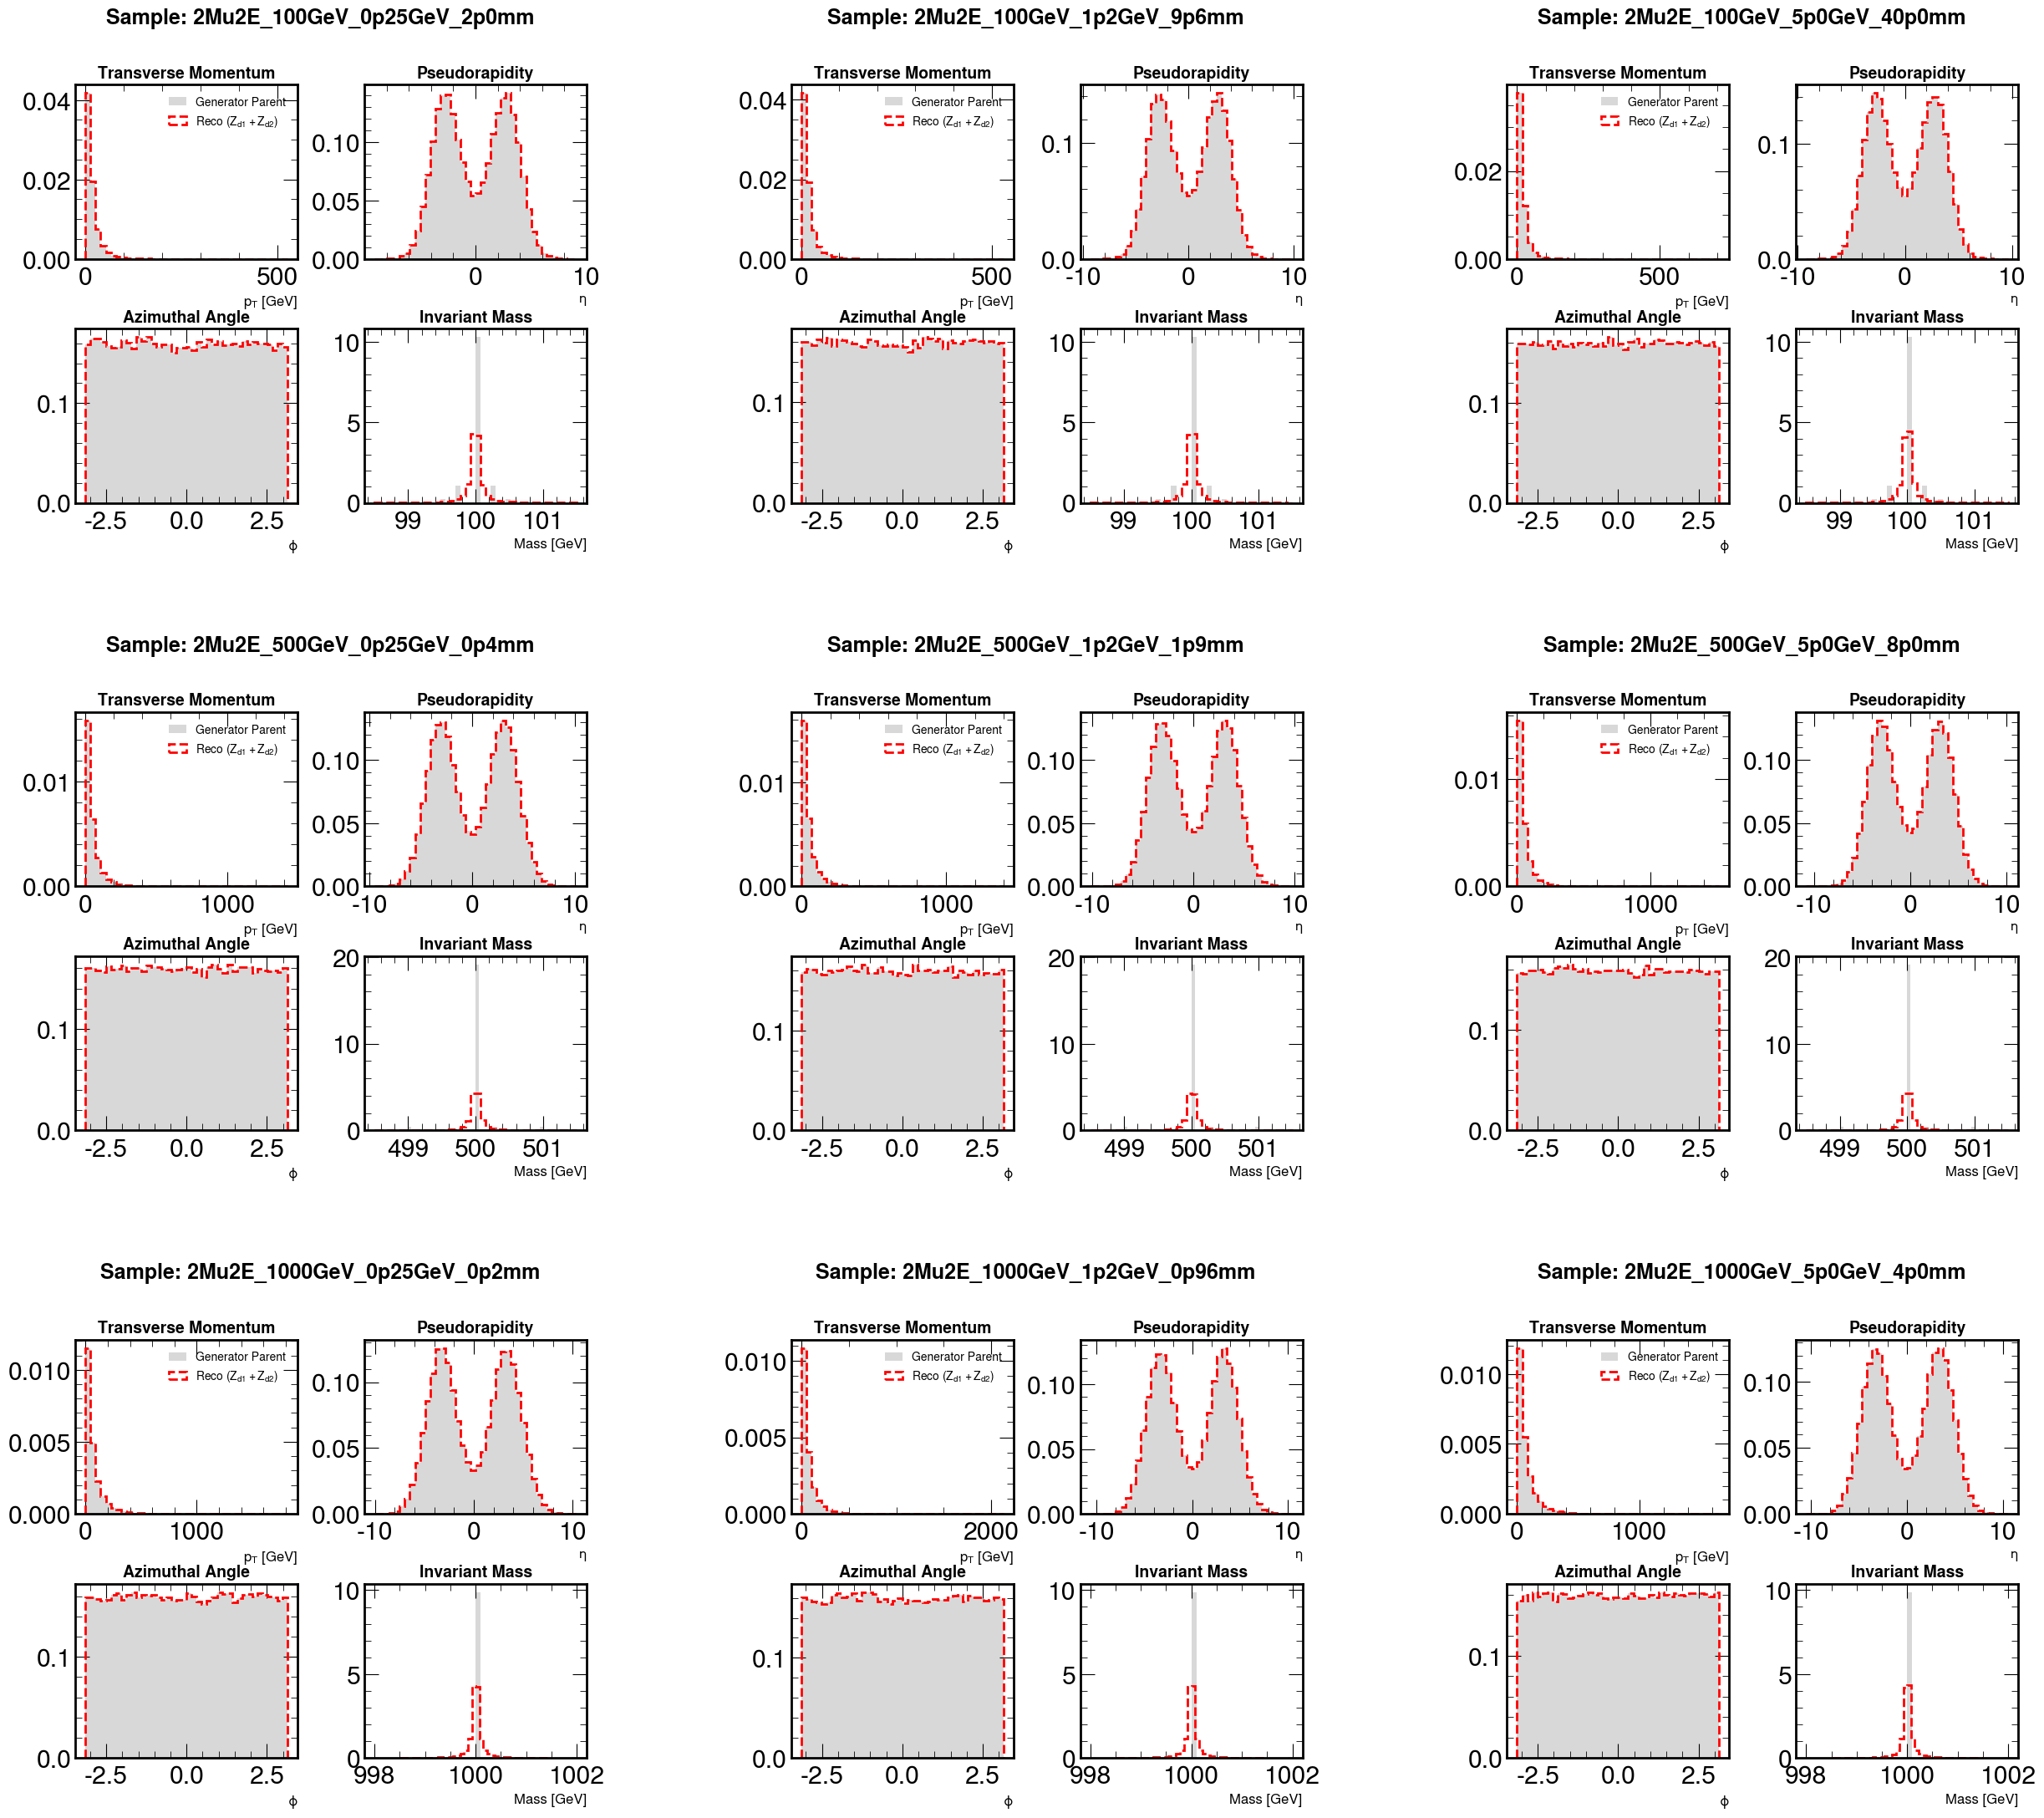

--- Generating Plot Type 3 ---


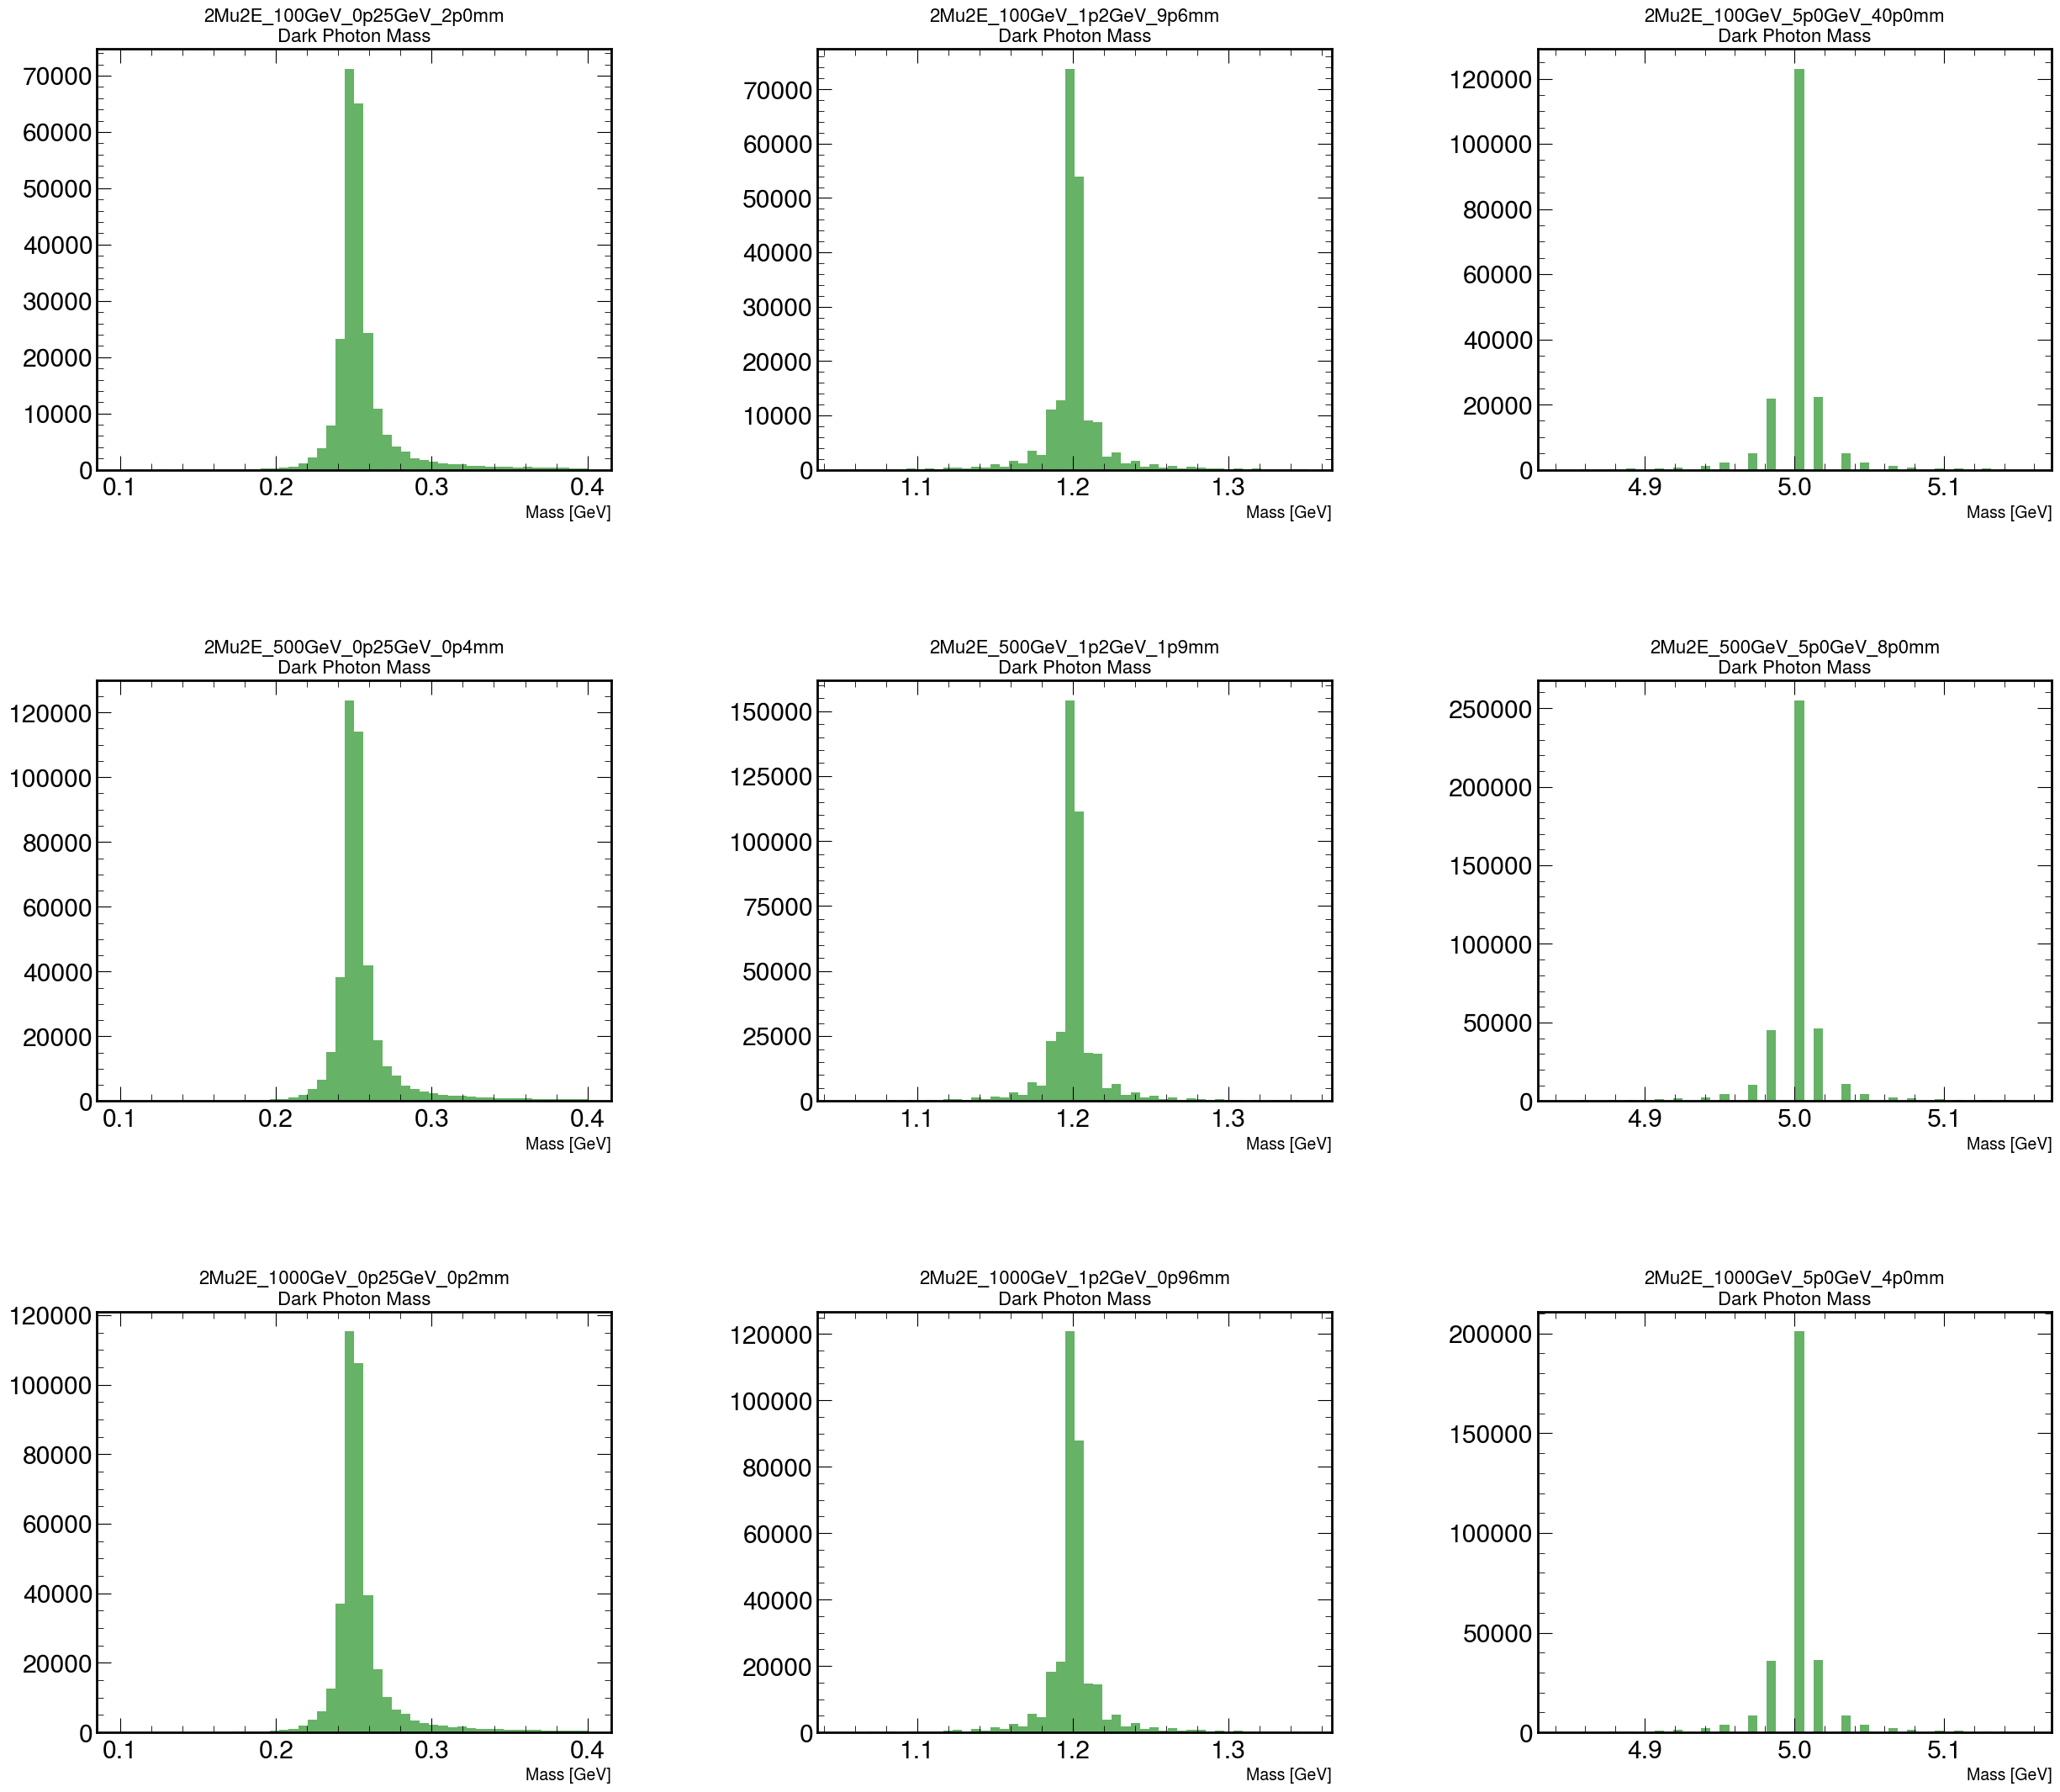

--- Generating Plot Type 4 ---


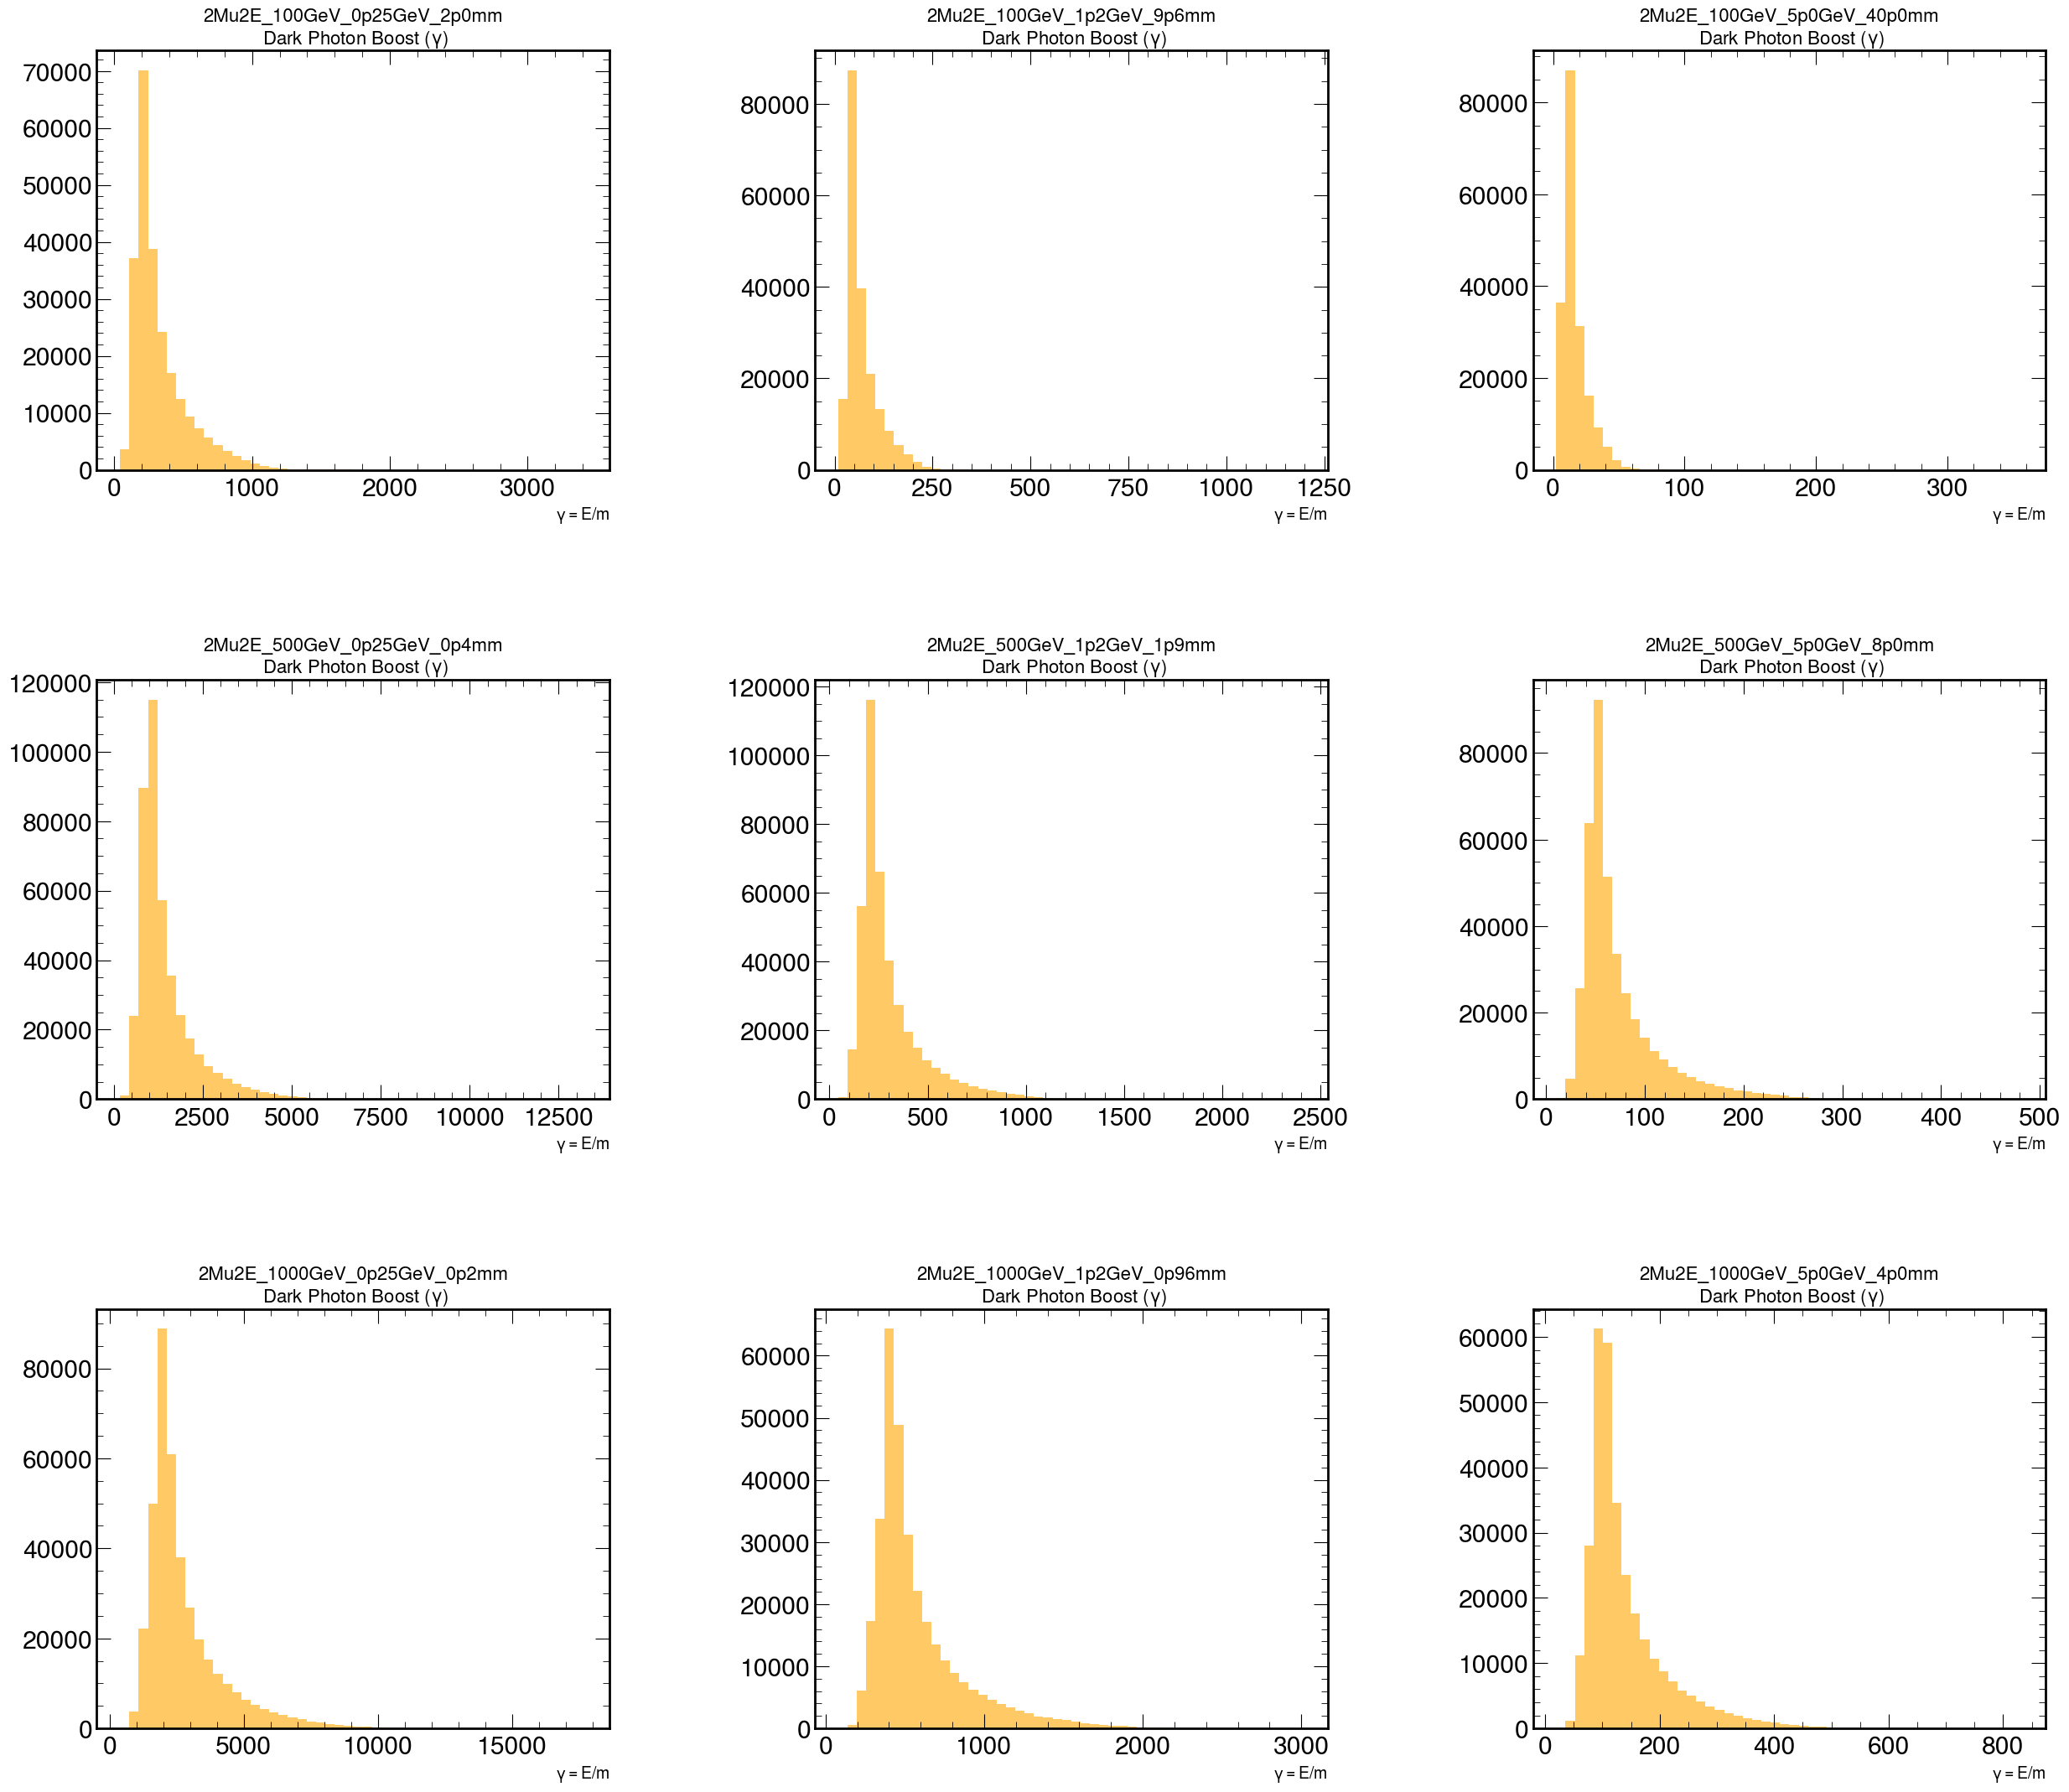

--- Generating Plot Type 2 ---


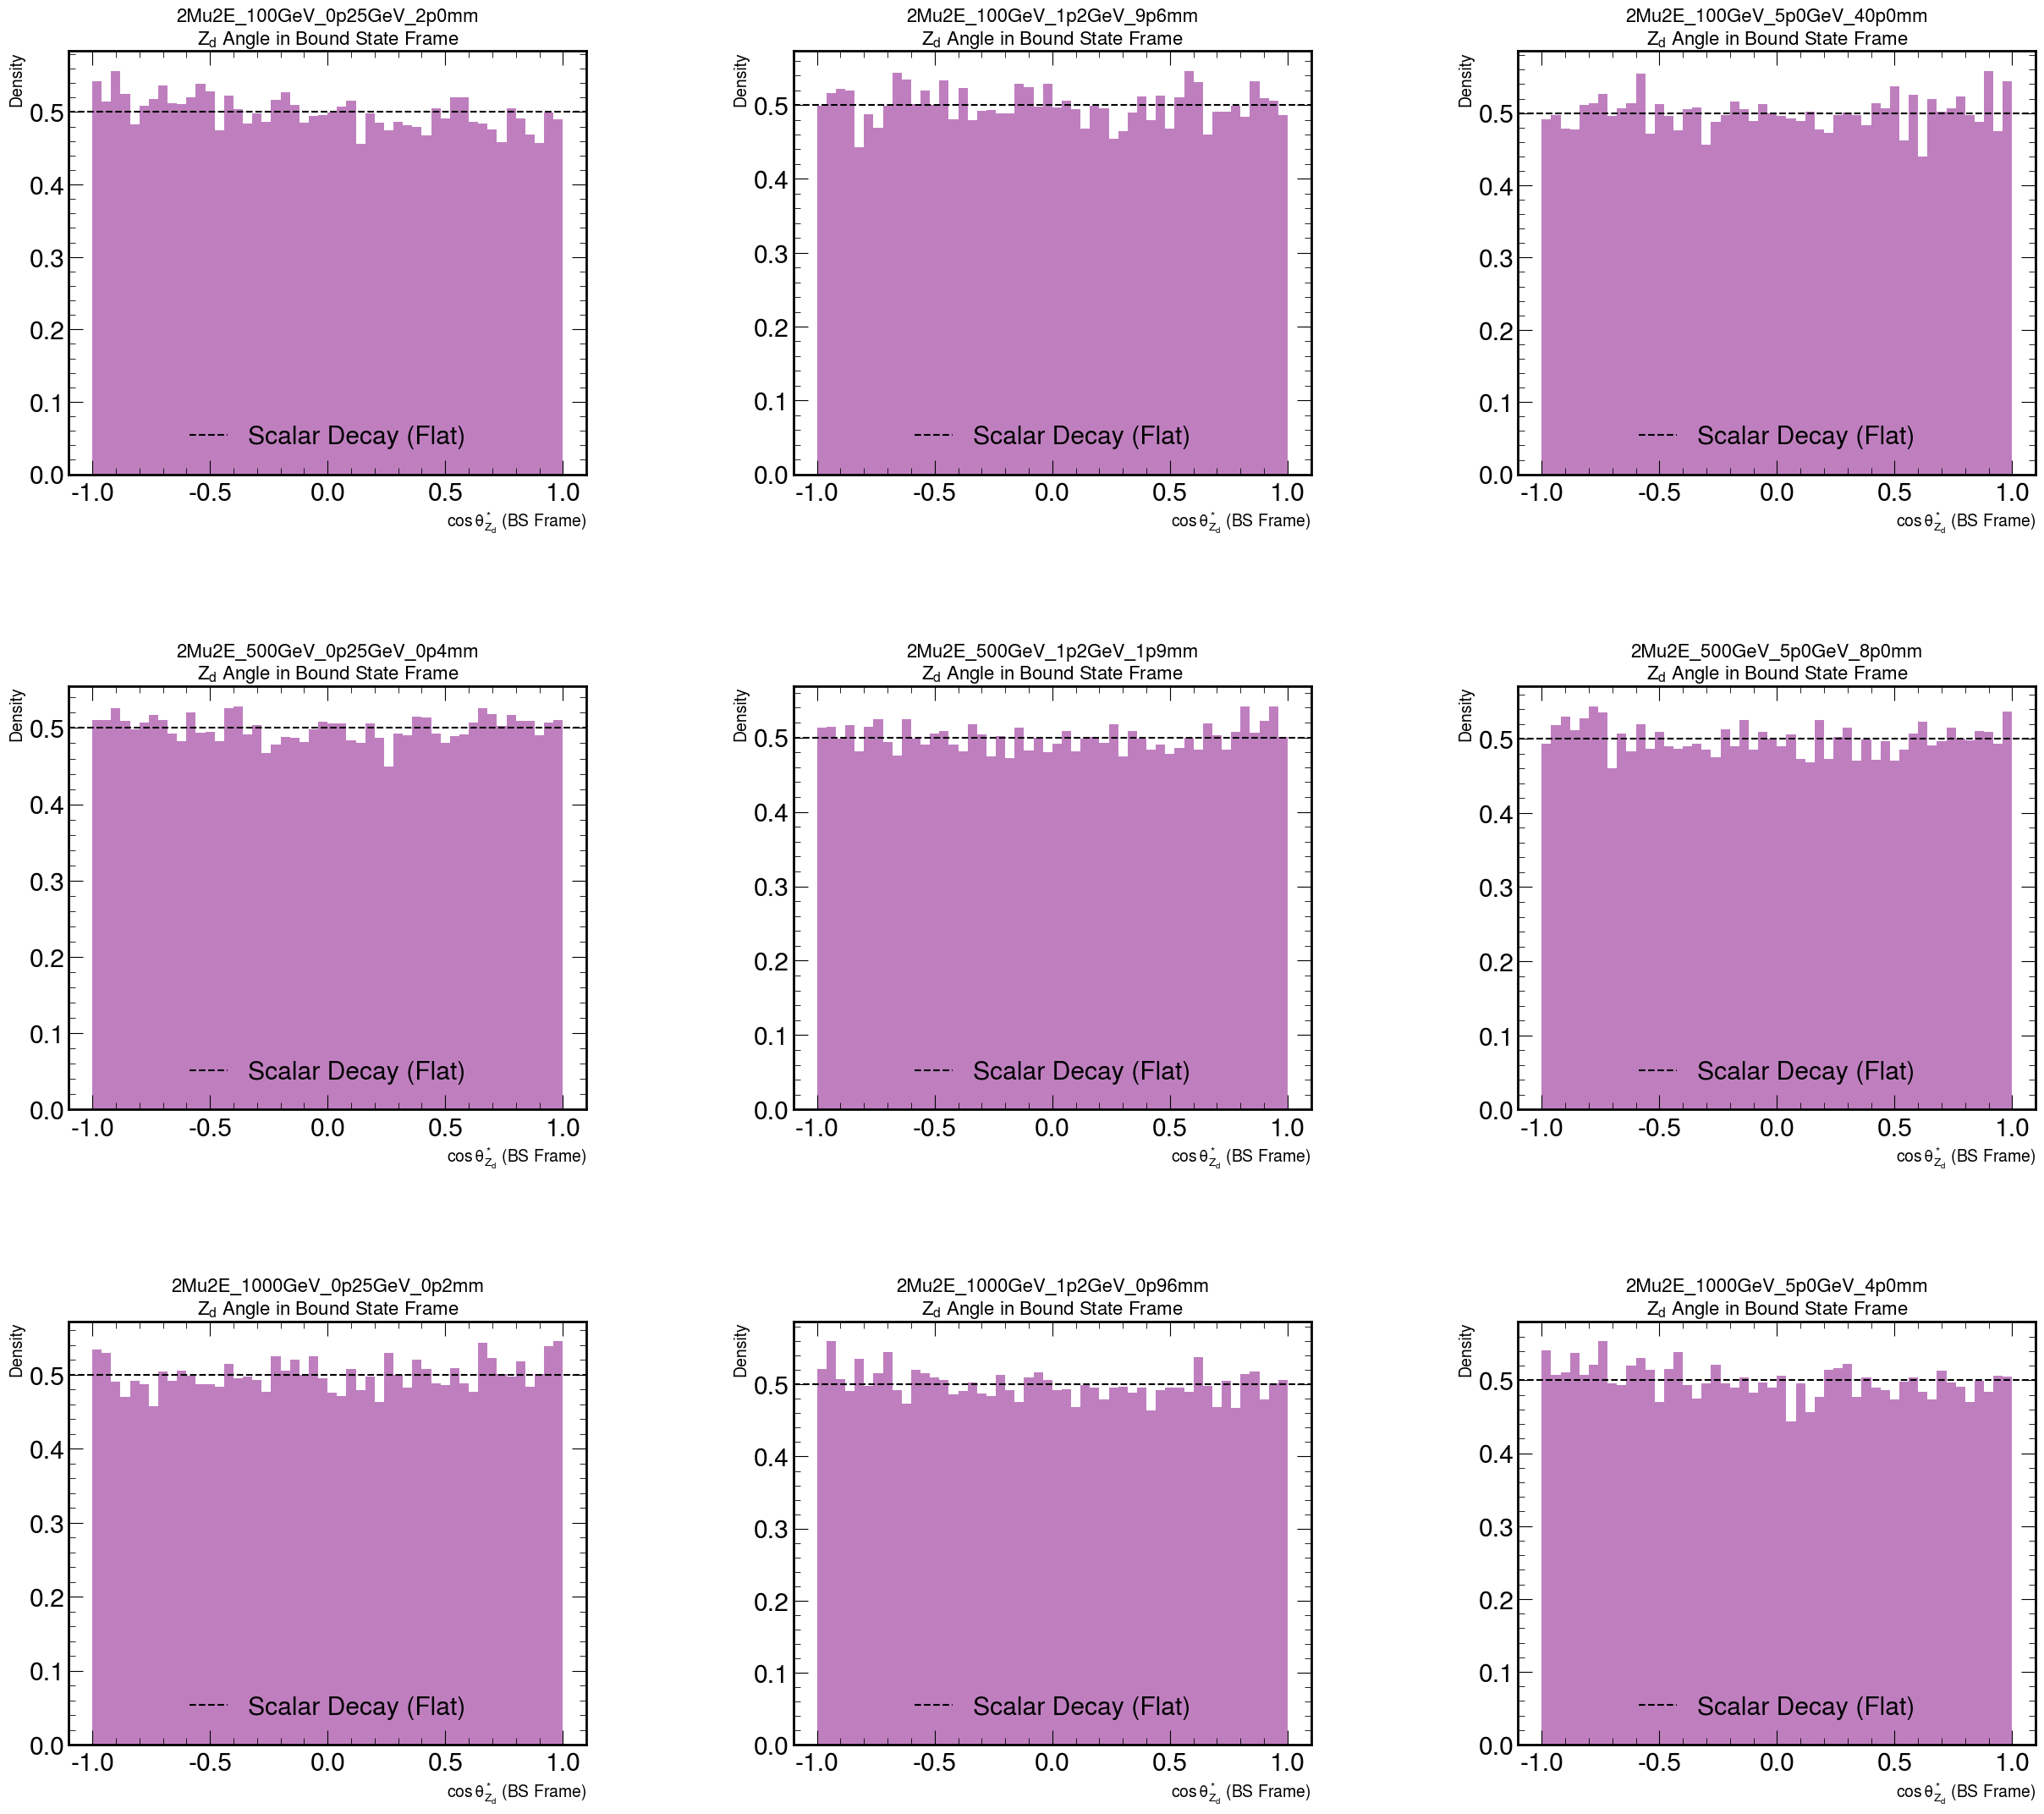

--- Generating Plot Type 34 ---


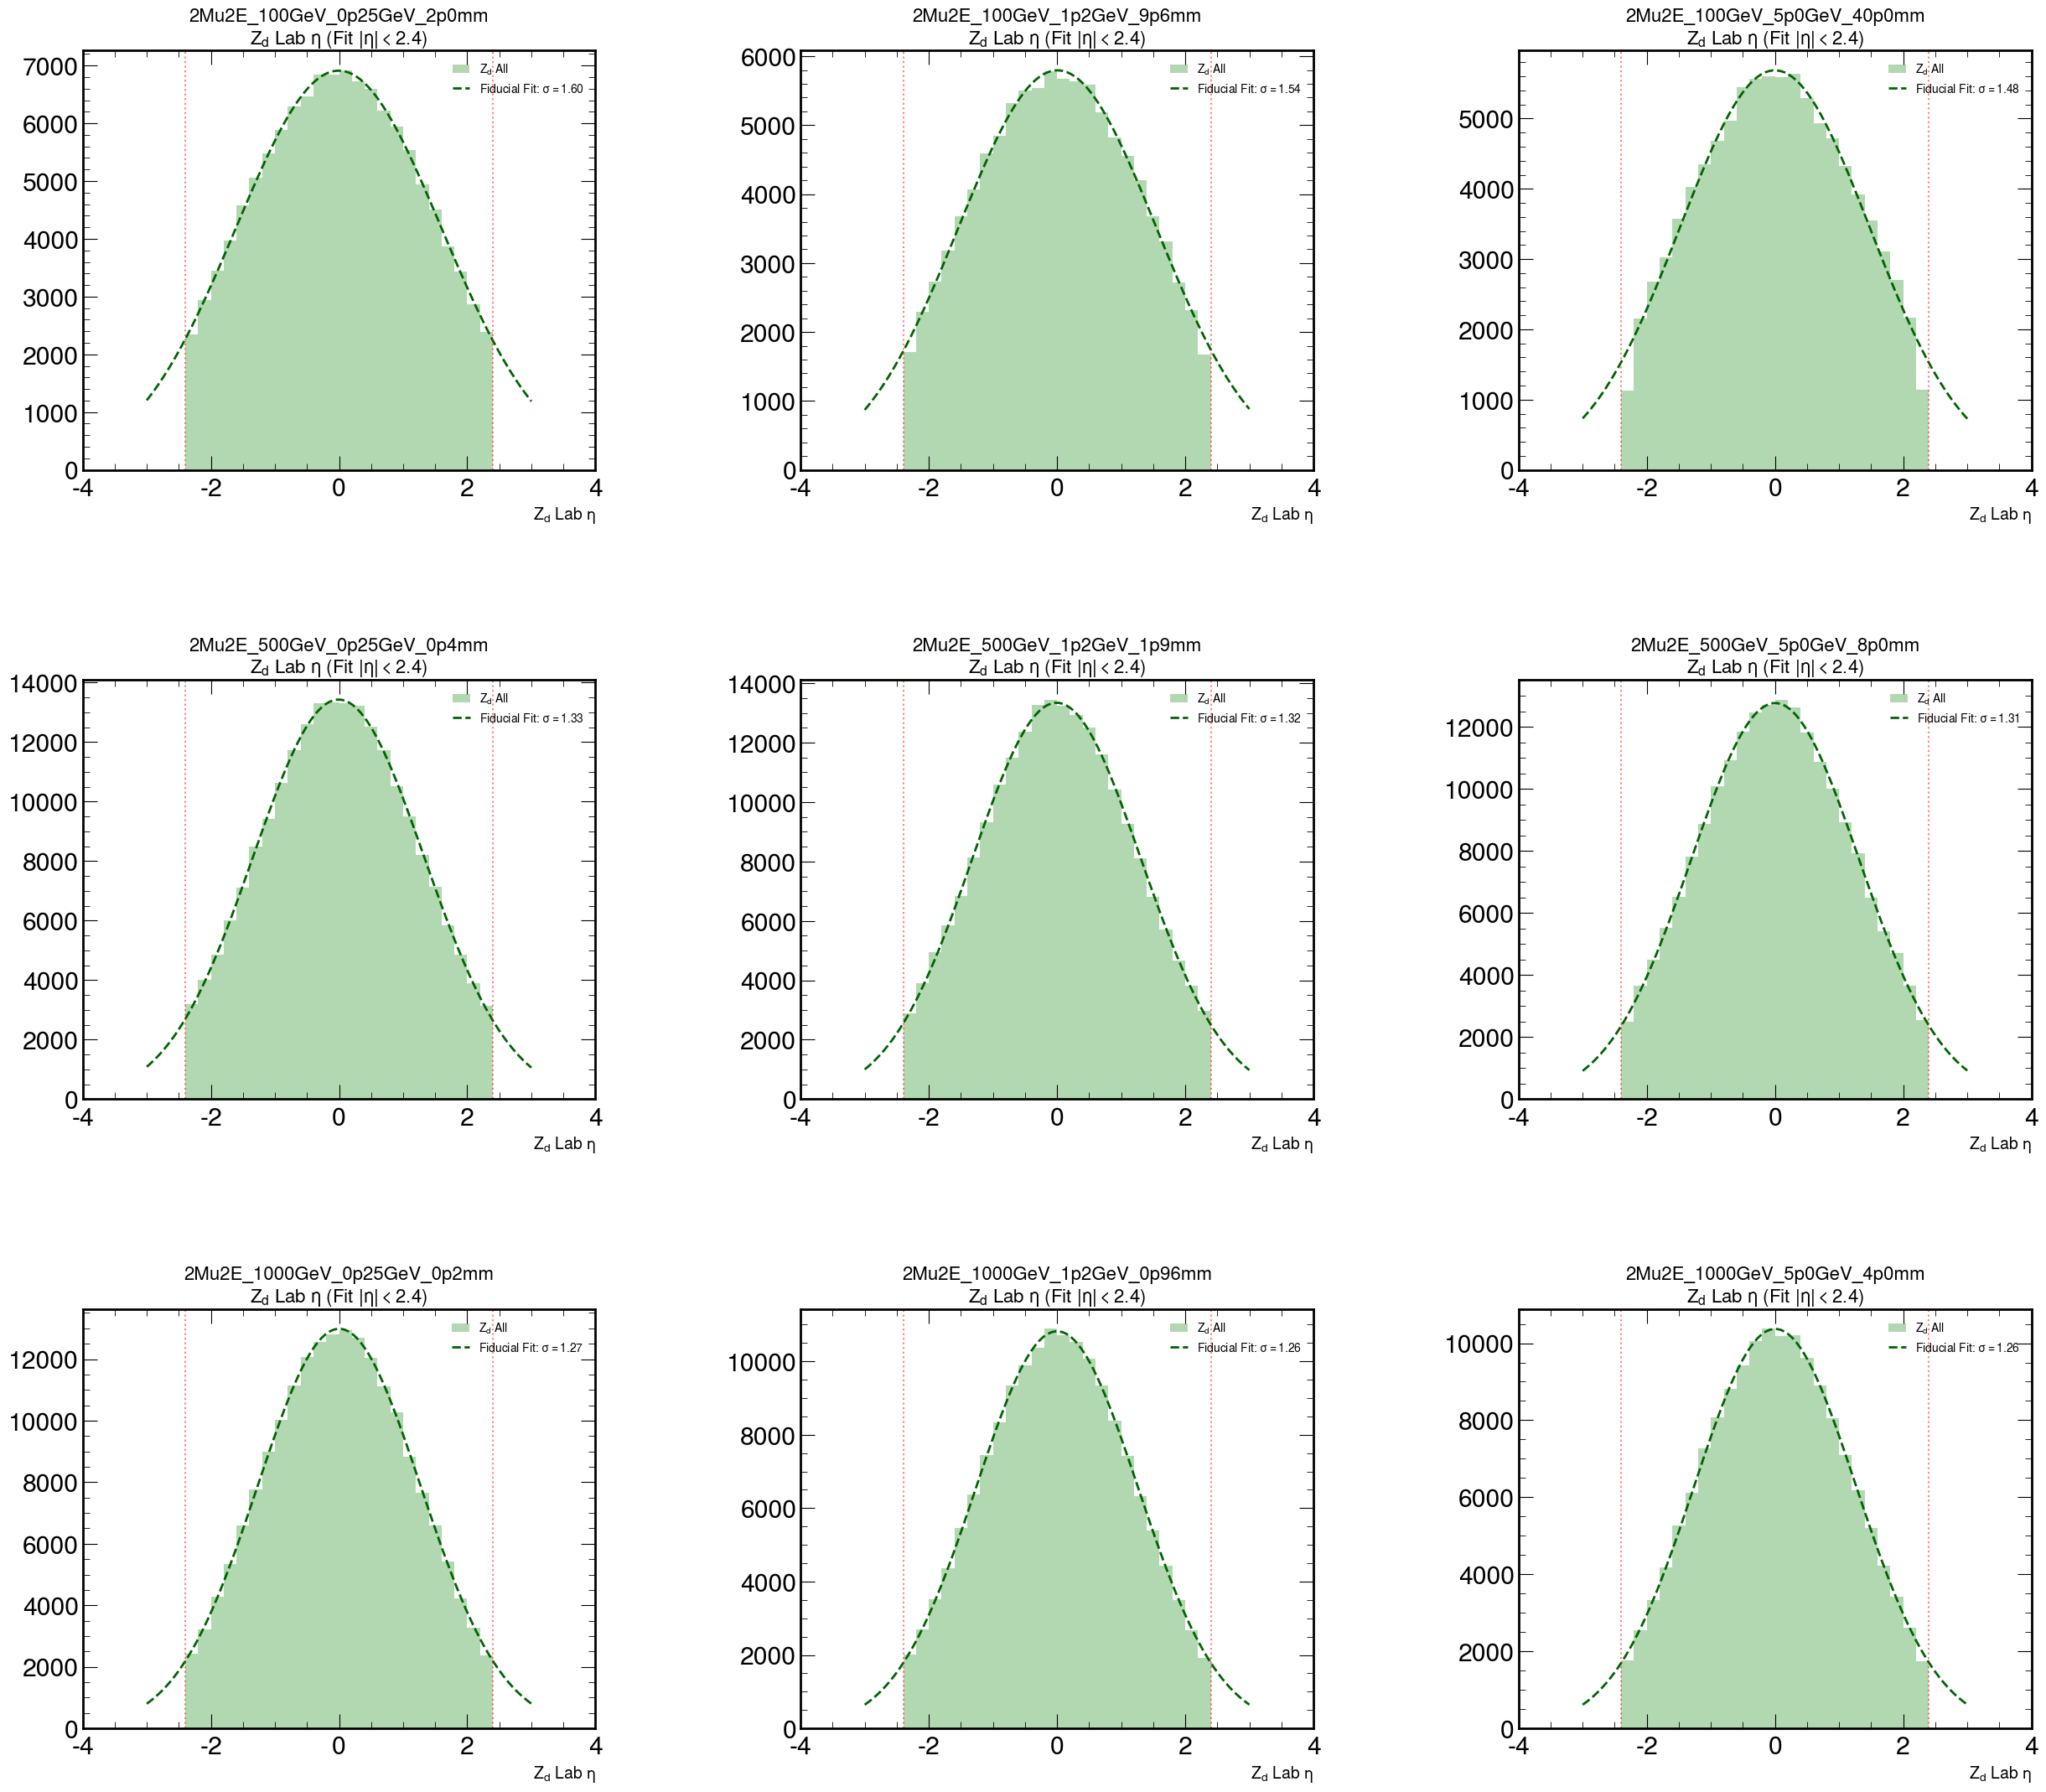

In [51]:
plot_master_grid(output, samples, plot_id=1)
plot_master_grid(output, samples, plot_id=3)
plot_master_grid(output, samples, plot_id=4)
plot_master_grid(output, samples, plot_id=2)
plot_master_grid(output, samples, plot_id=34)

1. Looks like our DM Bound State is indeed a scalar, that decays isotropically to the two dark photons.
    1. This isotropy is highlited by the flat $\cos(\theta_{Zd})$ plot in the BS frame (wrt BS boost axis)
3. The two Zd add up to recreate the BS parameters pretty well, validating this step in our simulation chain. 
4. The DP mass also seems correct given the samples, and the boost scales as expected with BS mass and Zd mass
5. The Zd has a pretty simple shape that looks like the result of the isotropic decay of the Bs, just remember that the longitudinal motion of the Bs does smear the Zd eta a bit, so this effective Gaussian is a bit wider ($\approx 1.5$) than the ideal ($\approx  0.8$).

## Lepton Parameters and the Zd Rest Frame

### Lepton mass from daughters is 0

--- Generating Plot Type 5 ---


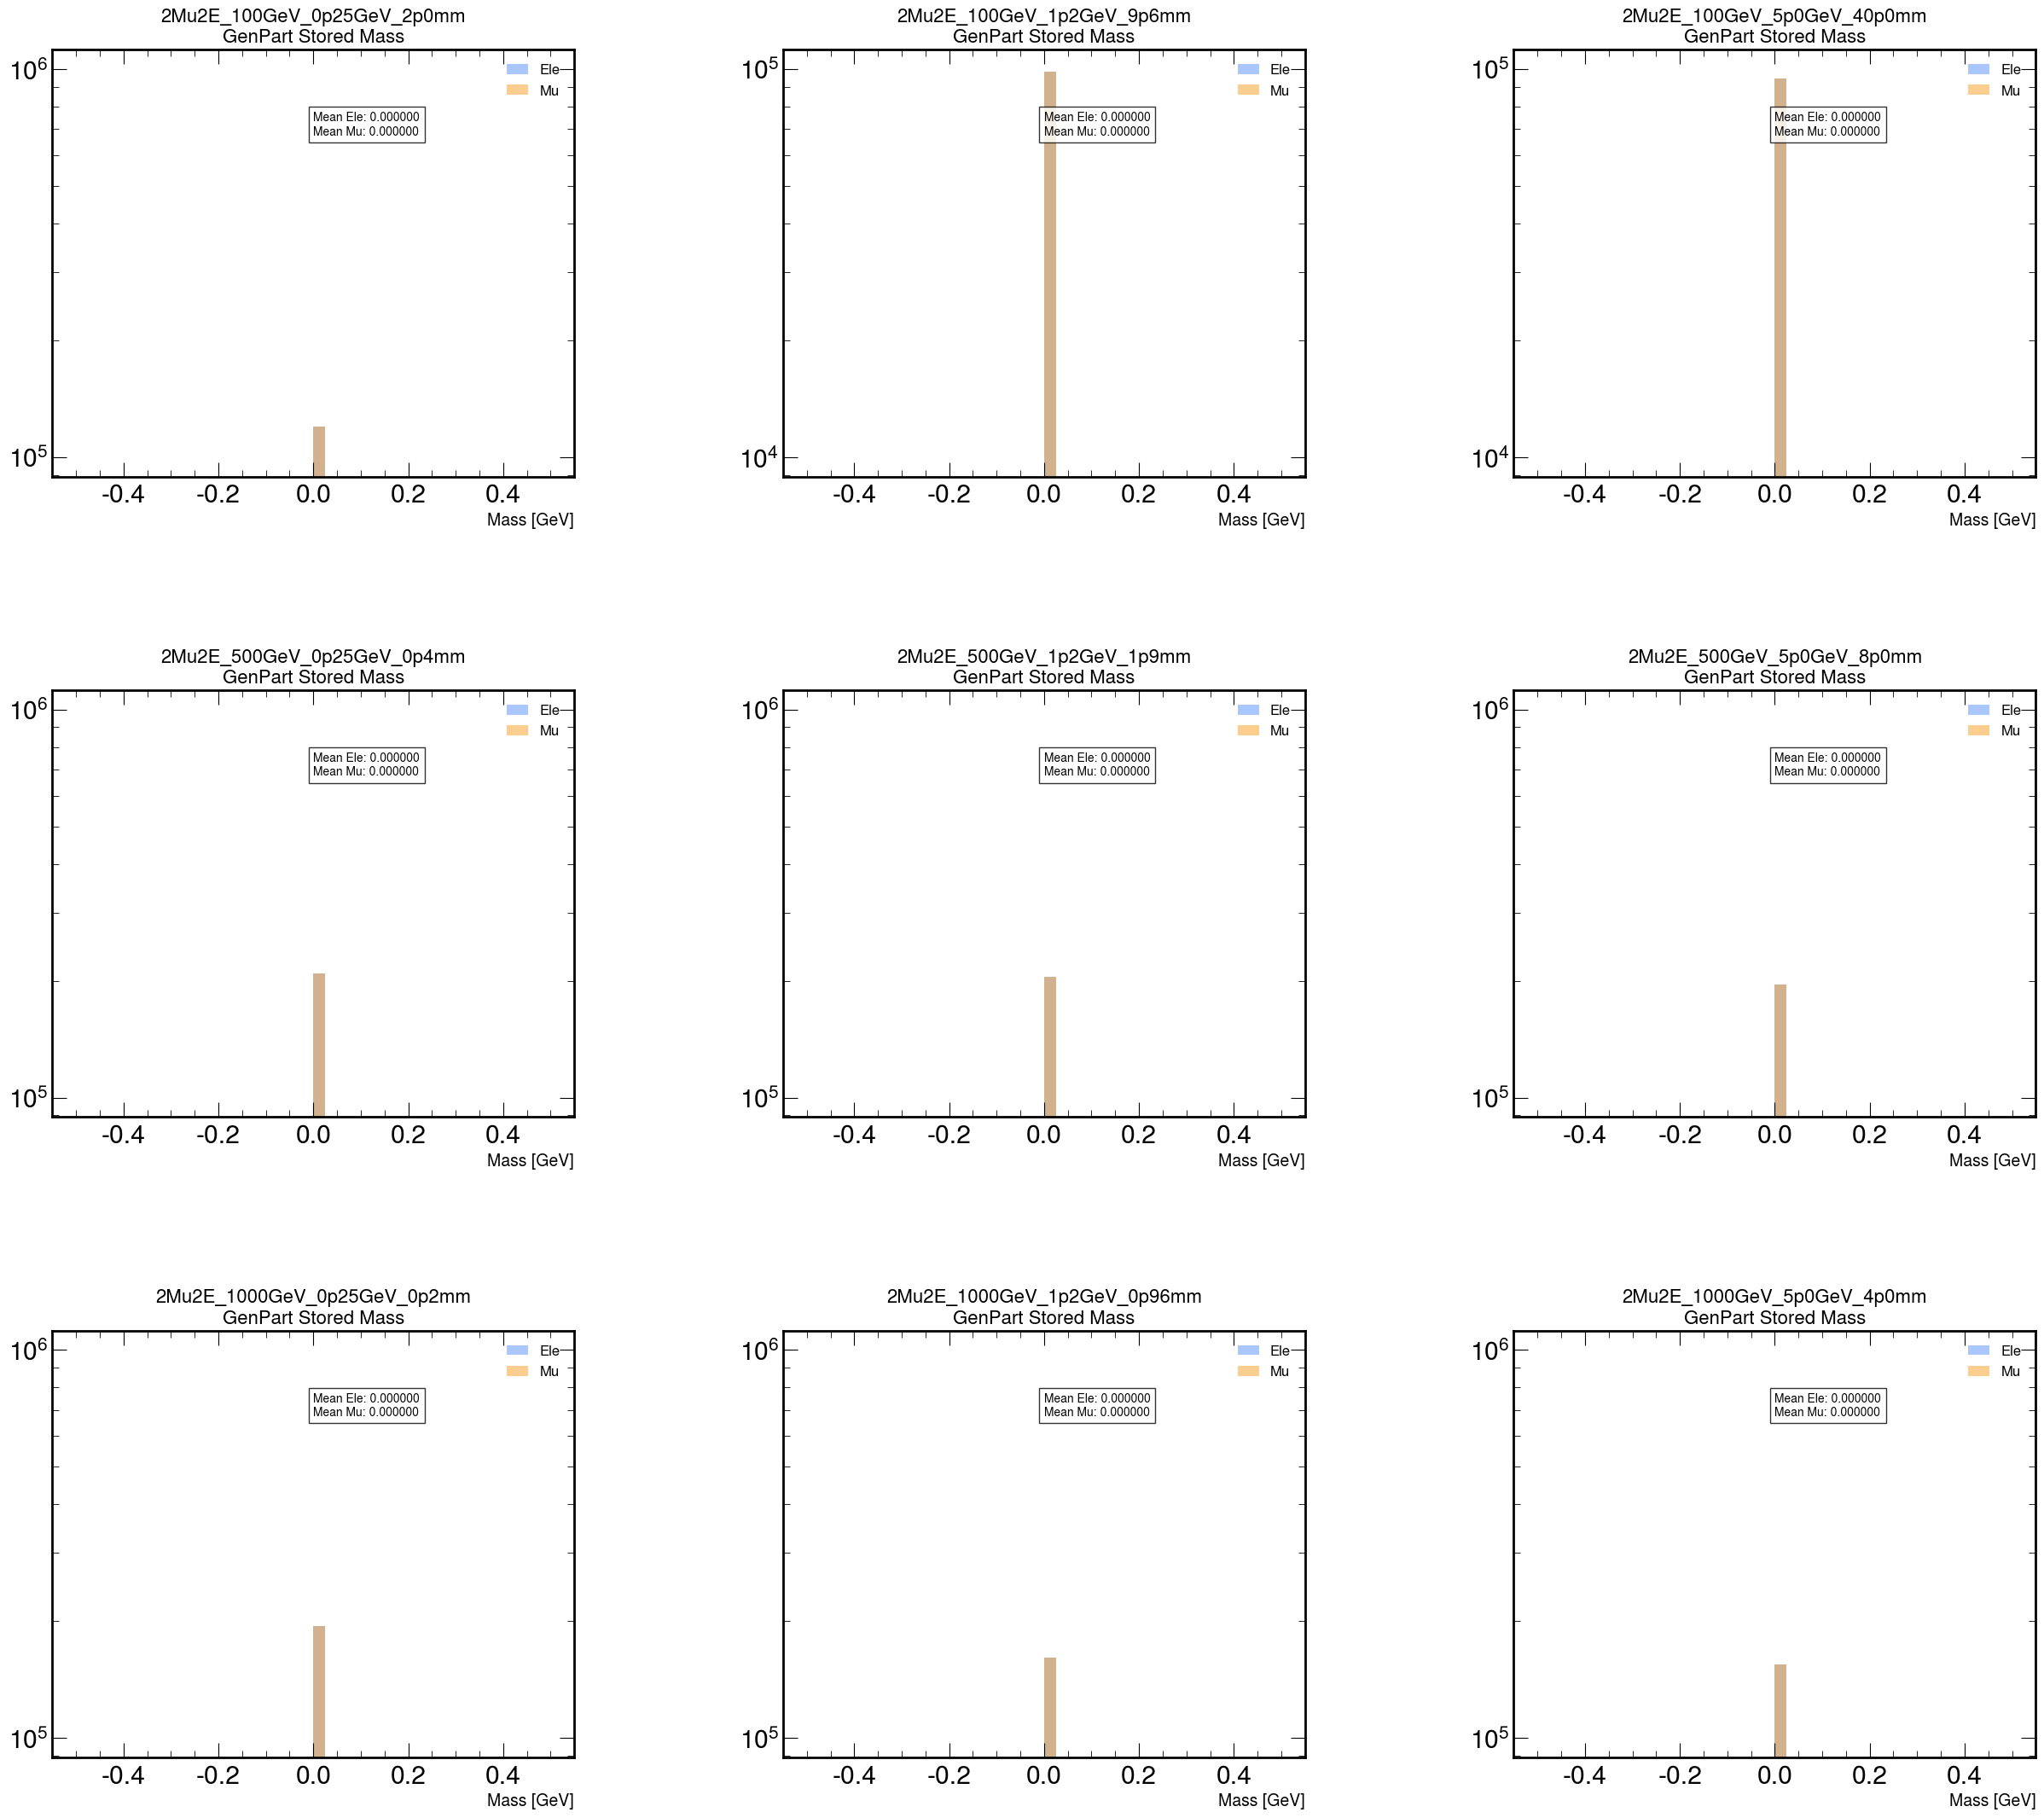

In [52]:
plot_master_grid(output, samples, plot_id=5)

First we note that the electrons and muons that are the children of the dark photons don't seem to have any mass. So we must add that back right away

### Leptons may have a mix of status codes 1 and 23, no effect on overall kinematics

--- Generating Plot Type 6 ---


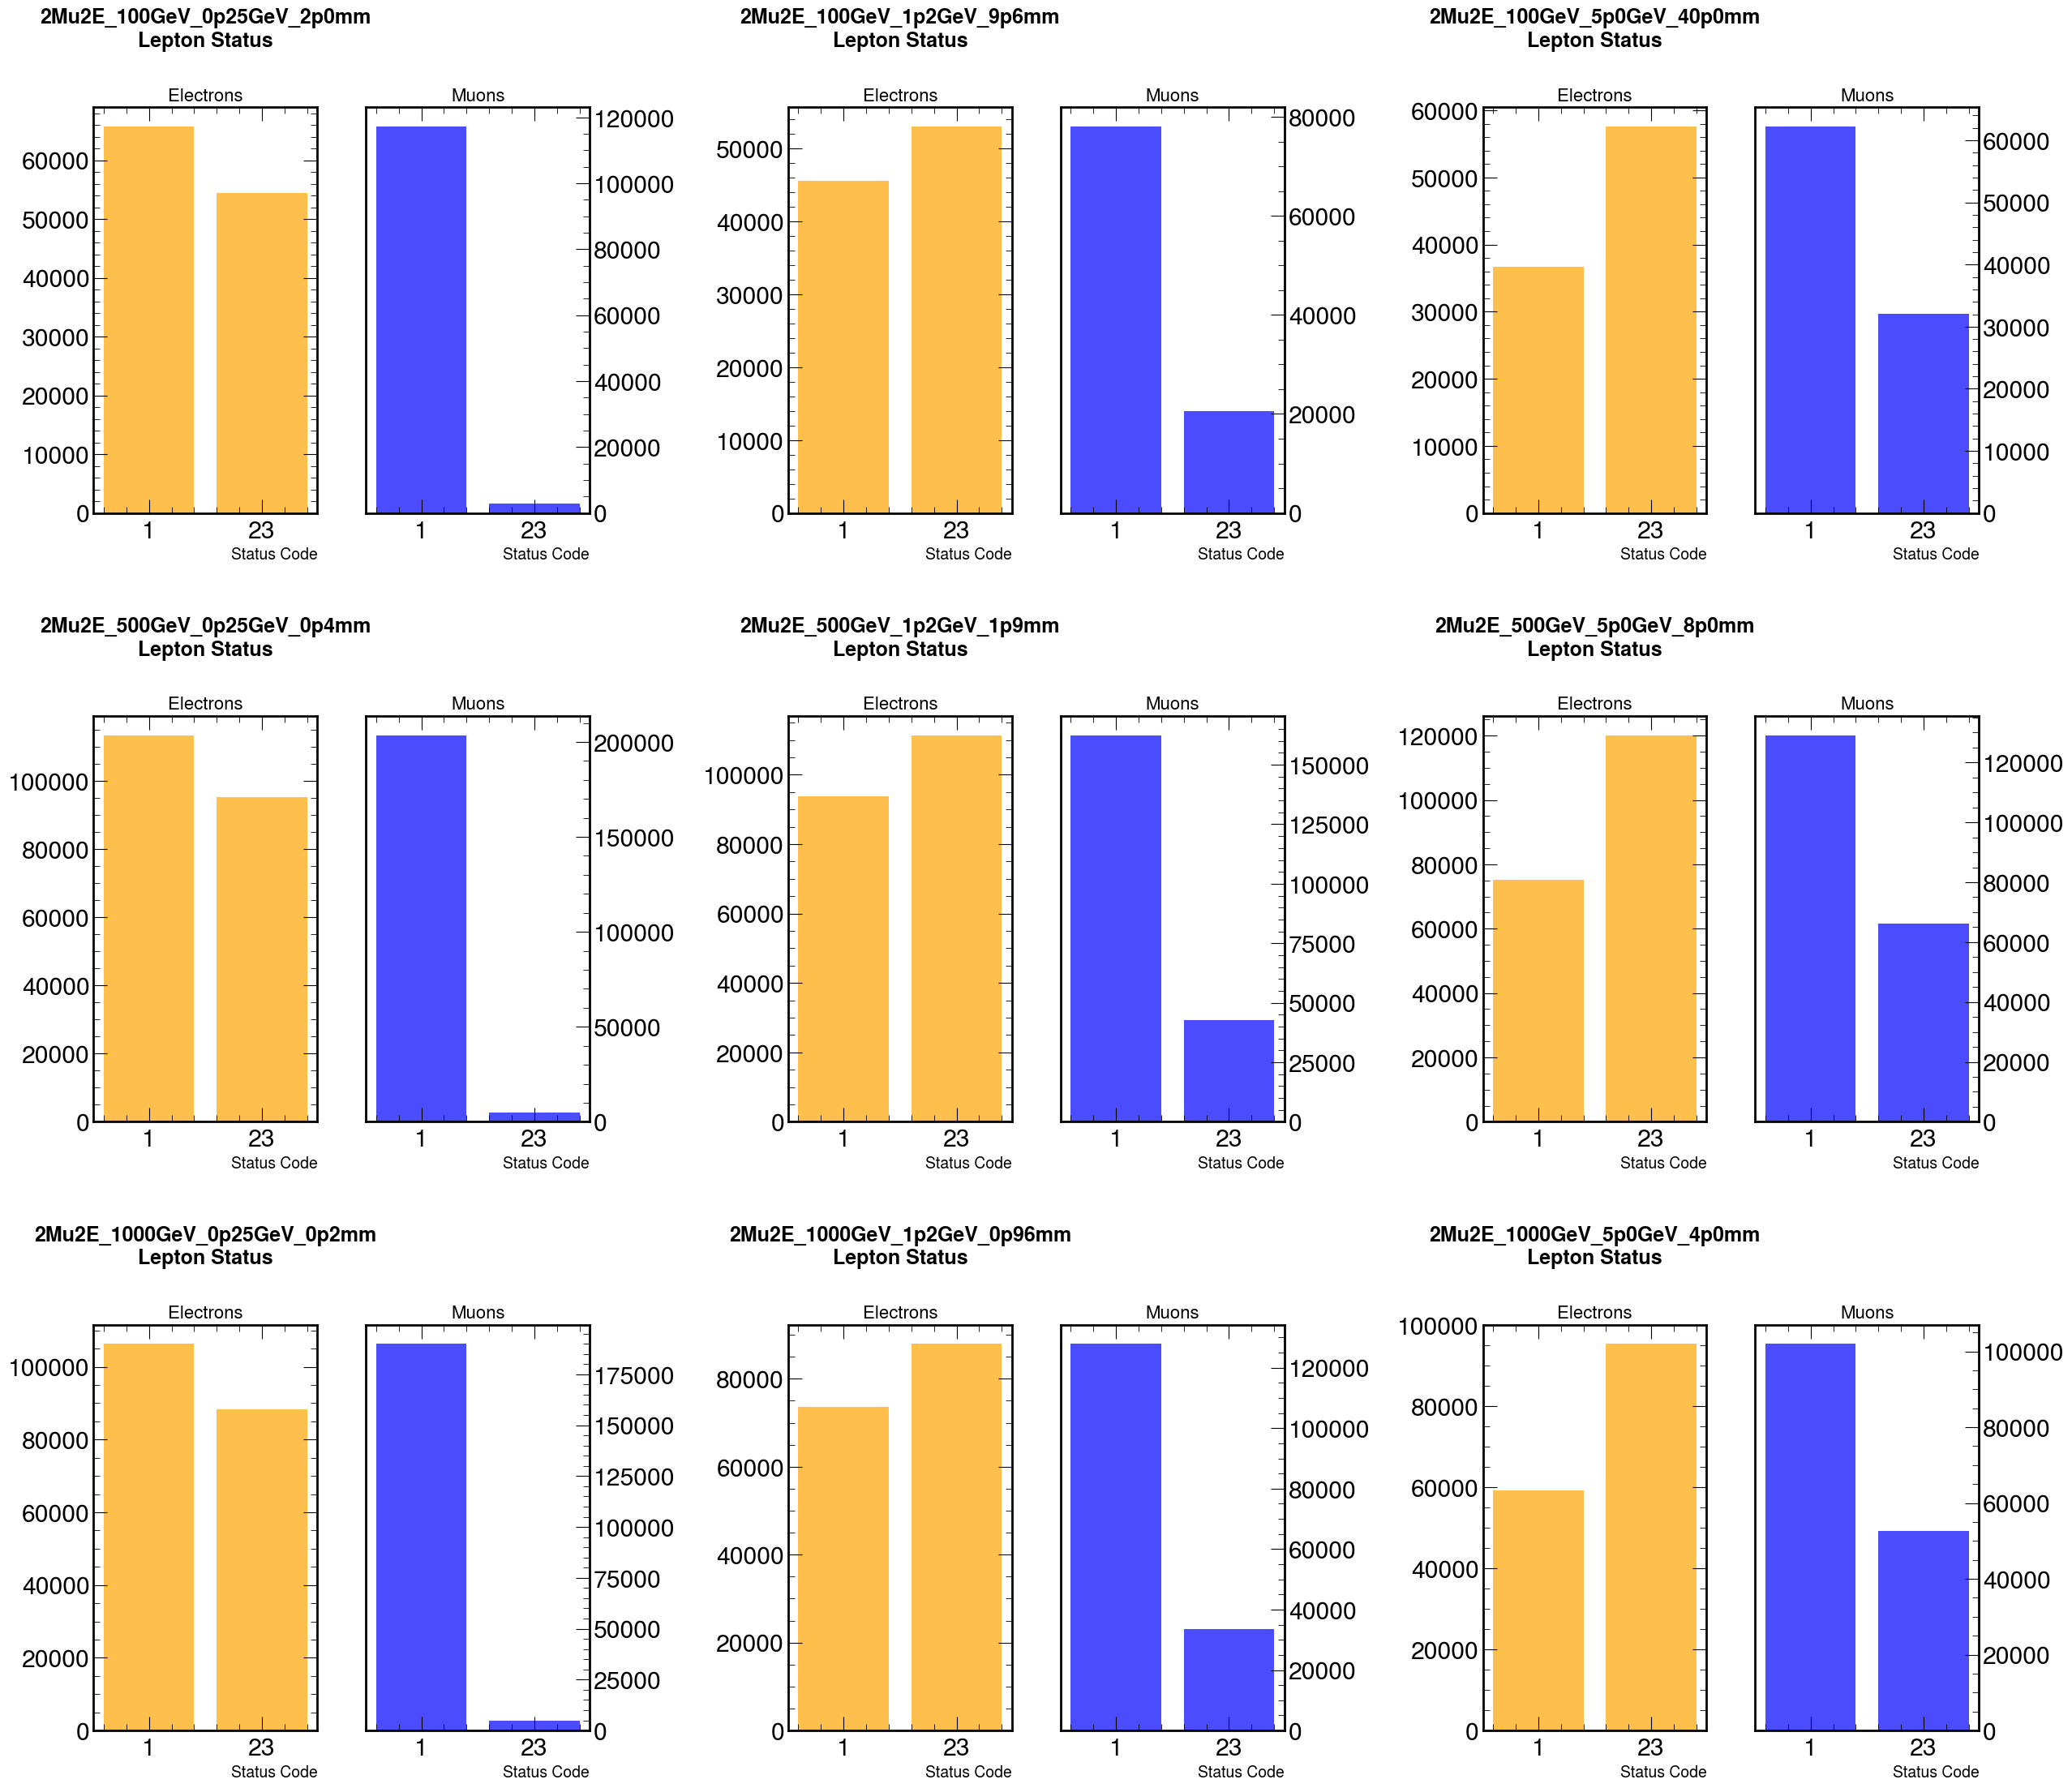

In [53]:
plot_master_grid(output, samples, plot_id=6)

Here we note that as the phase space available to the lepton grows with the available rest mass in the Zd frame, we see more status 23 leptons. This means we have greater FSR happening as the Zd gets more massive. If you see status 1, that means the daughter particle went on to hit the detector, so didn't radiate anything else. We can try to track the effect of this in the next set of plots.

--- Generating Plot Type 7 ---


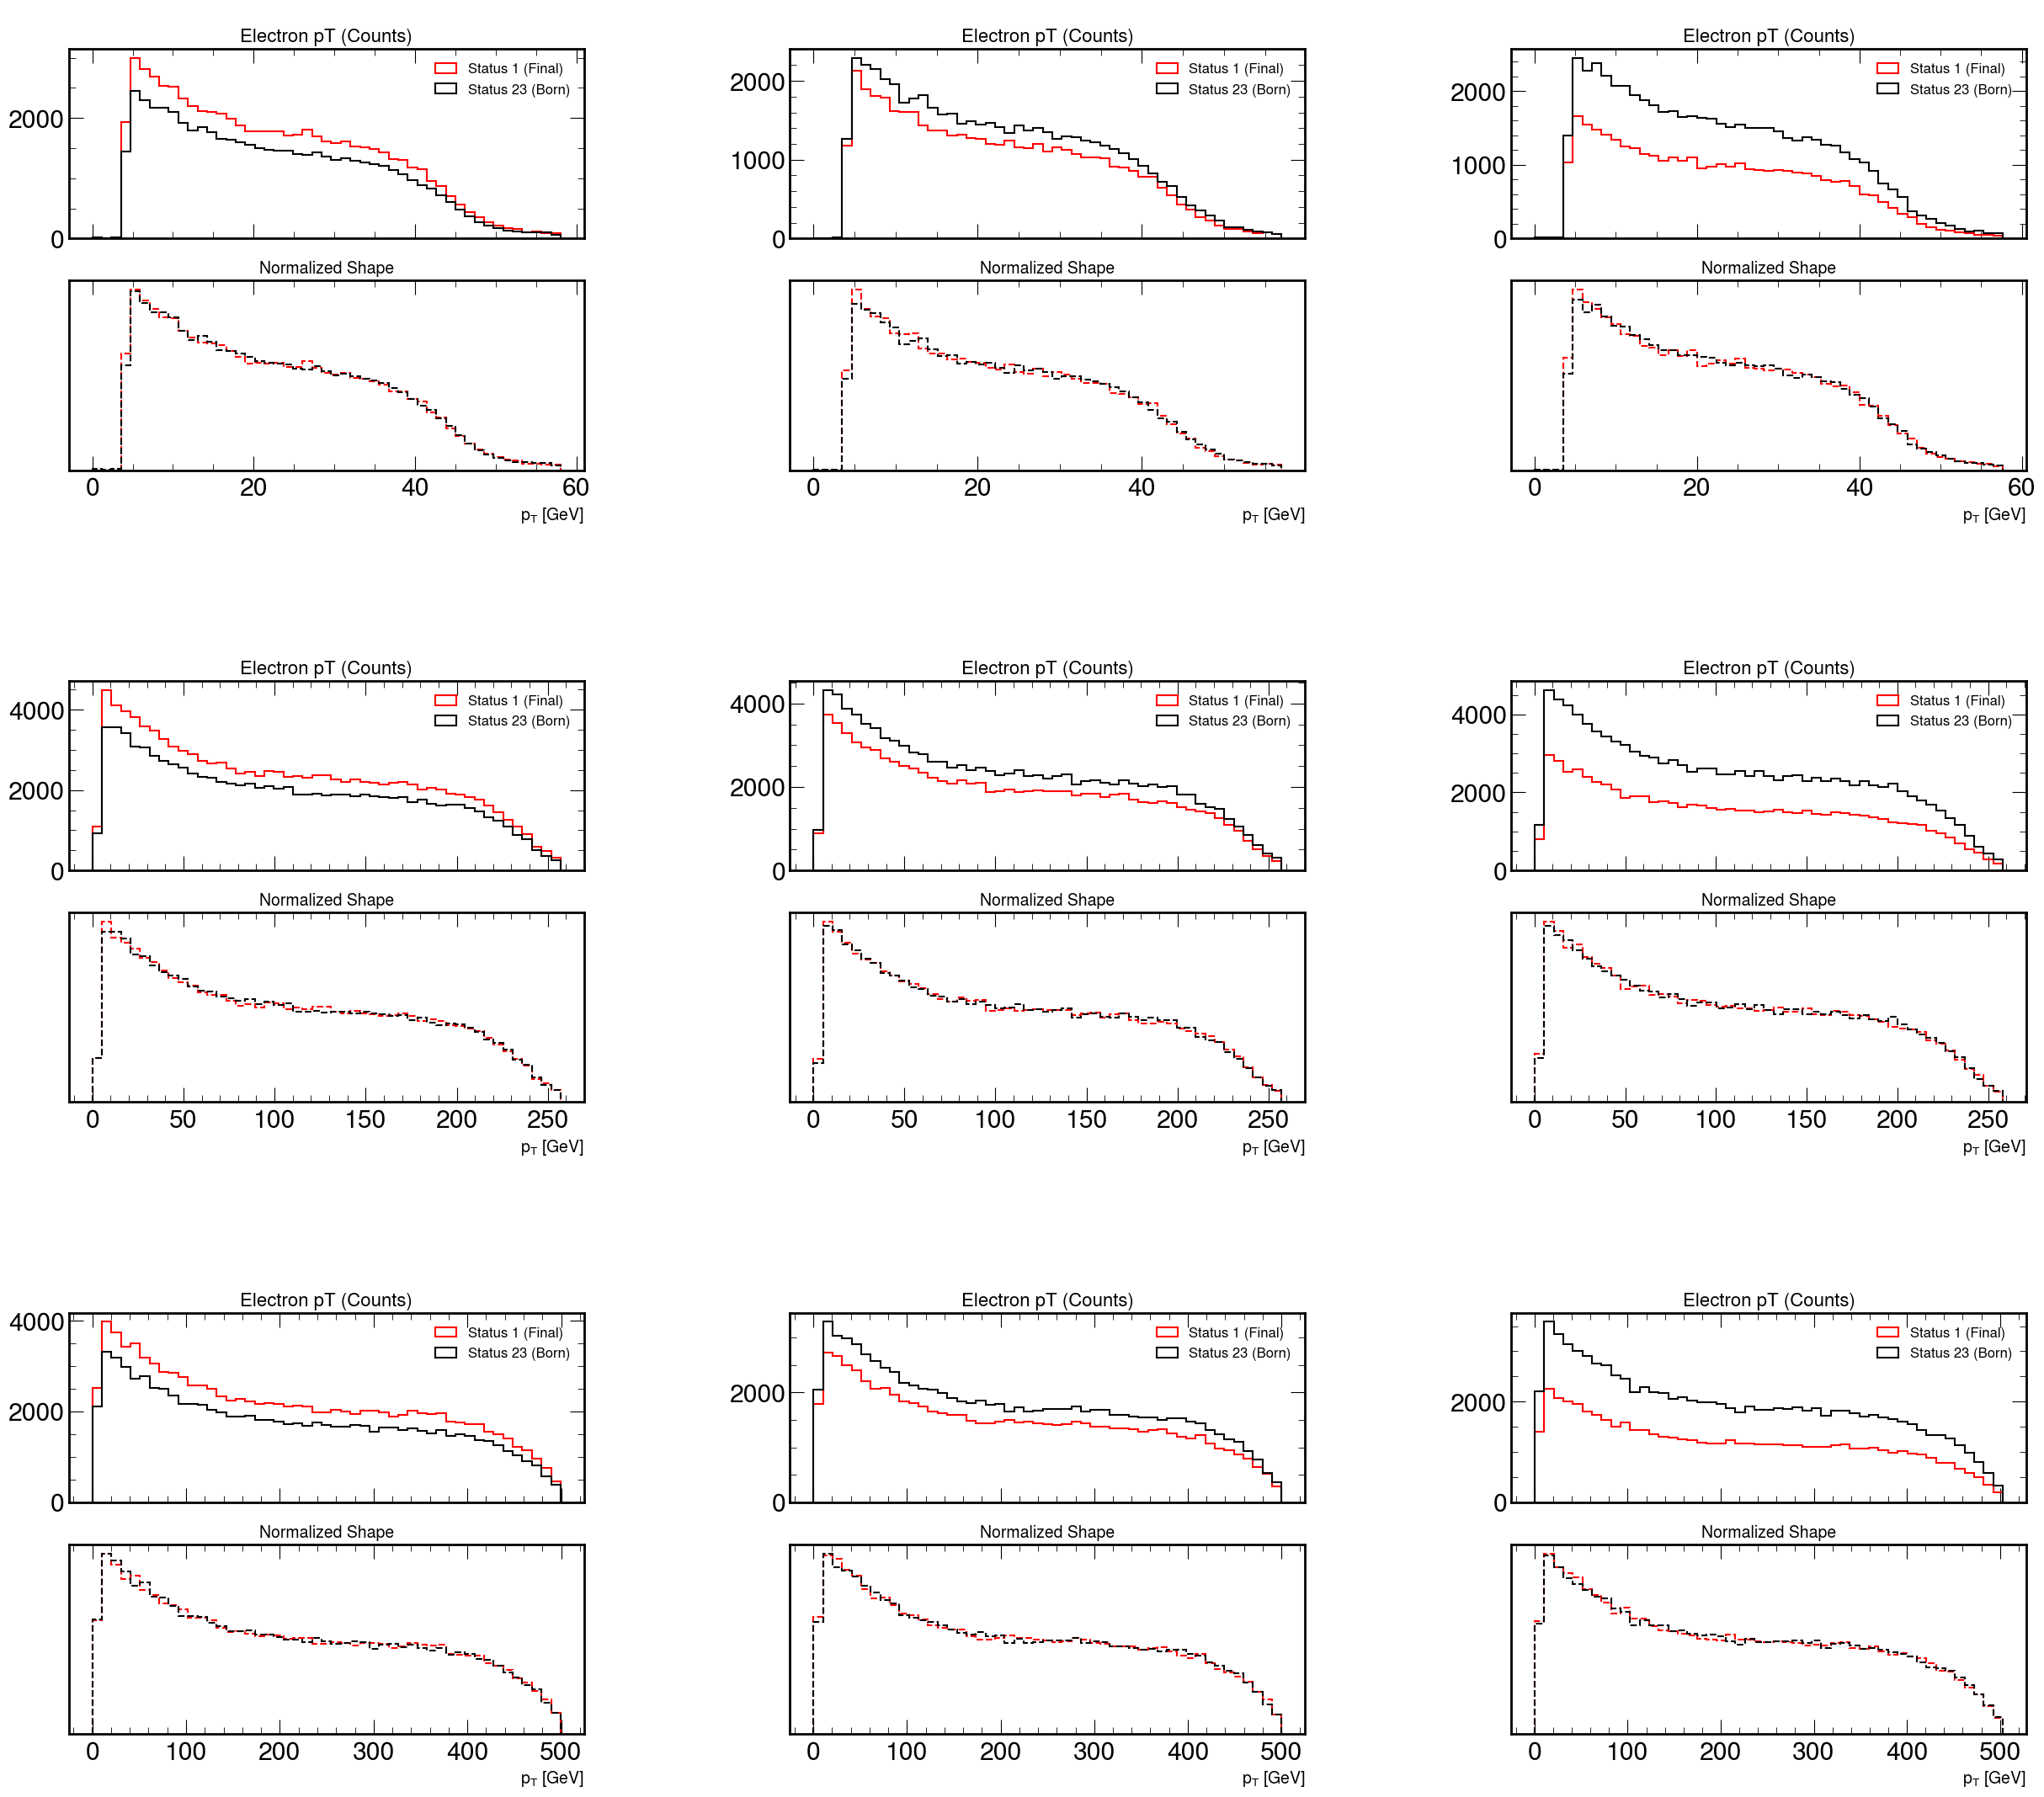

--- Generating Plot Type 8 ---


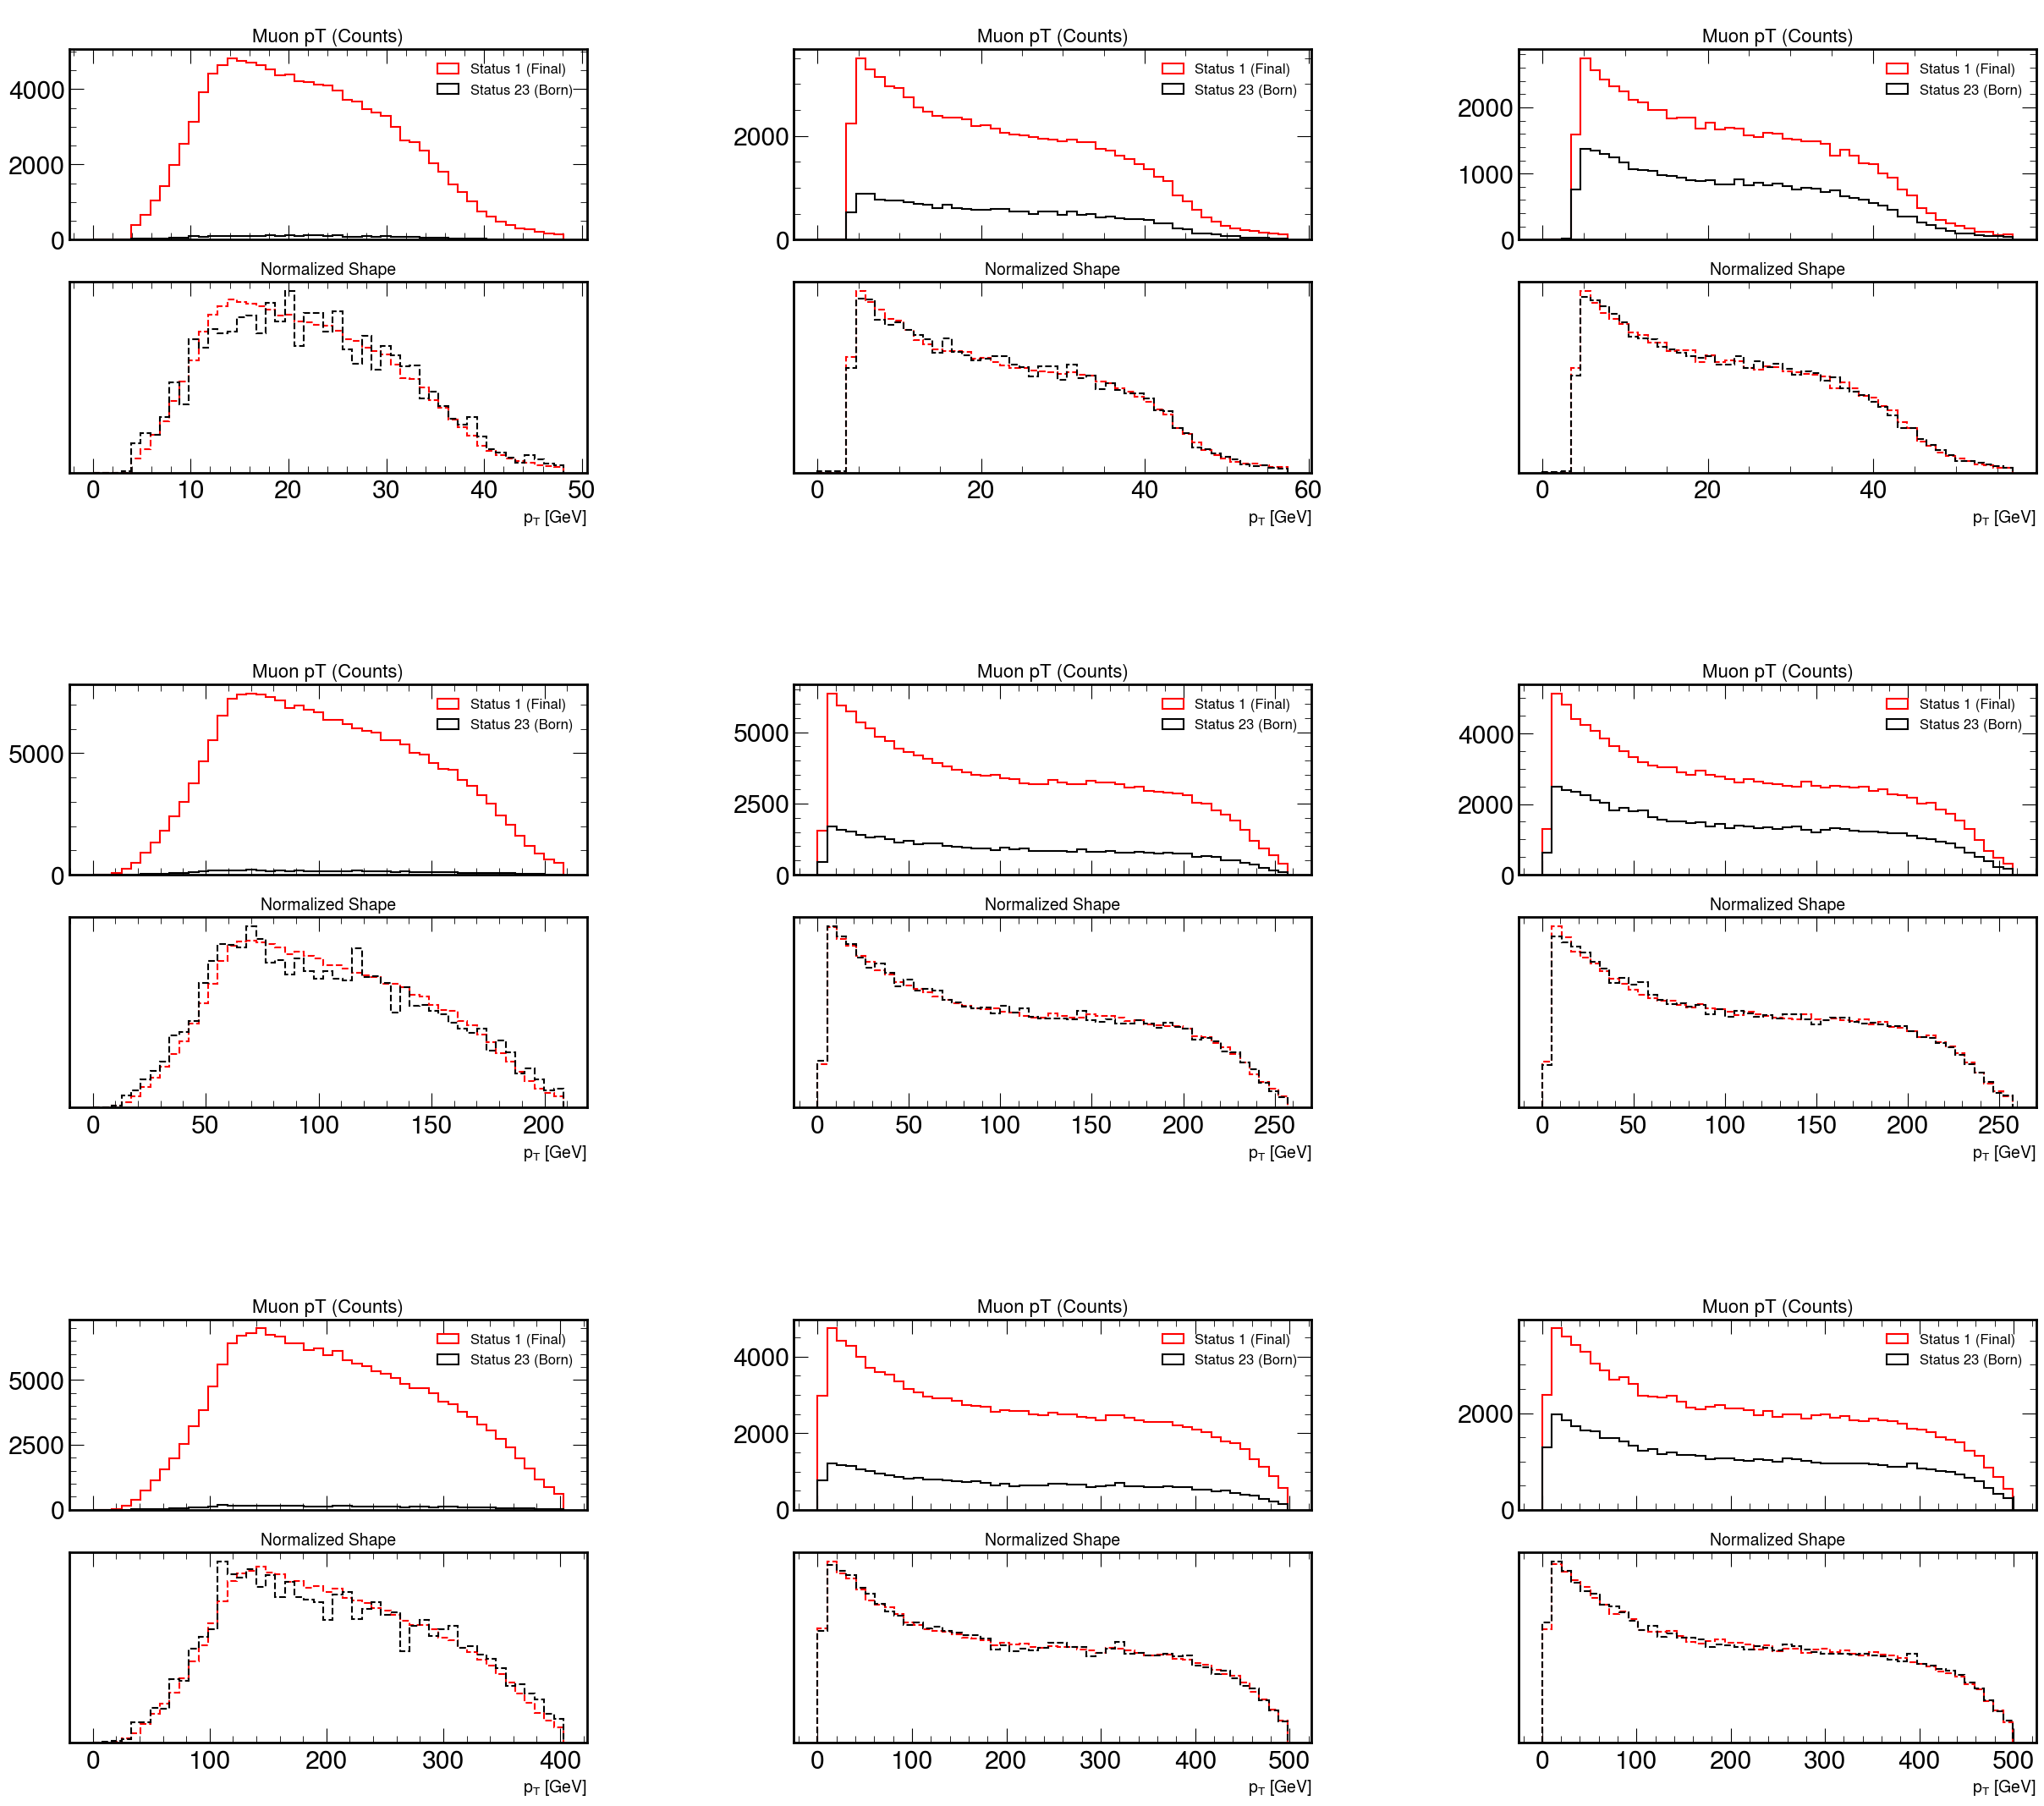

--- Generating Plot Type 11 ---


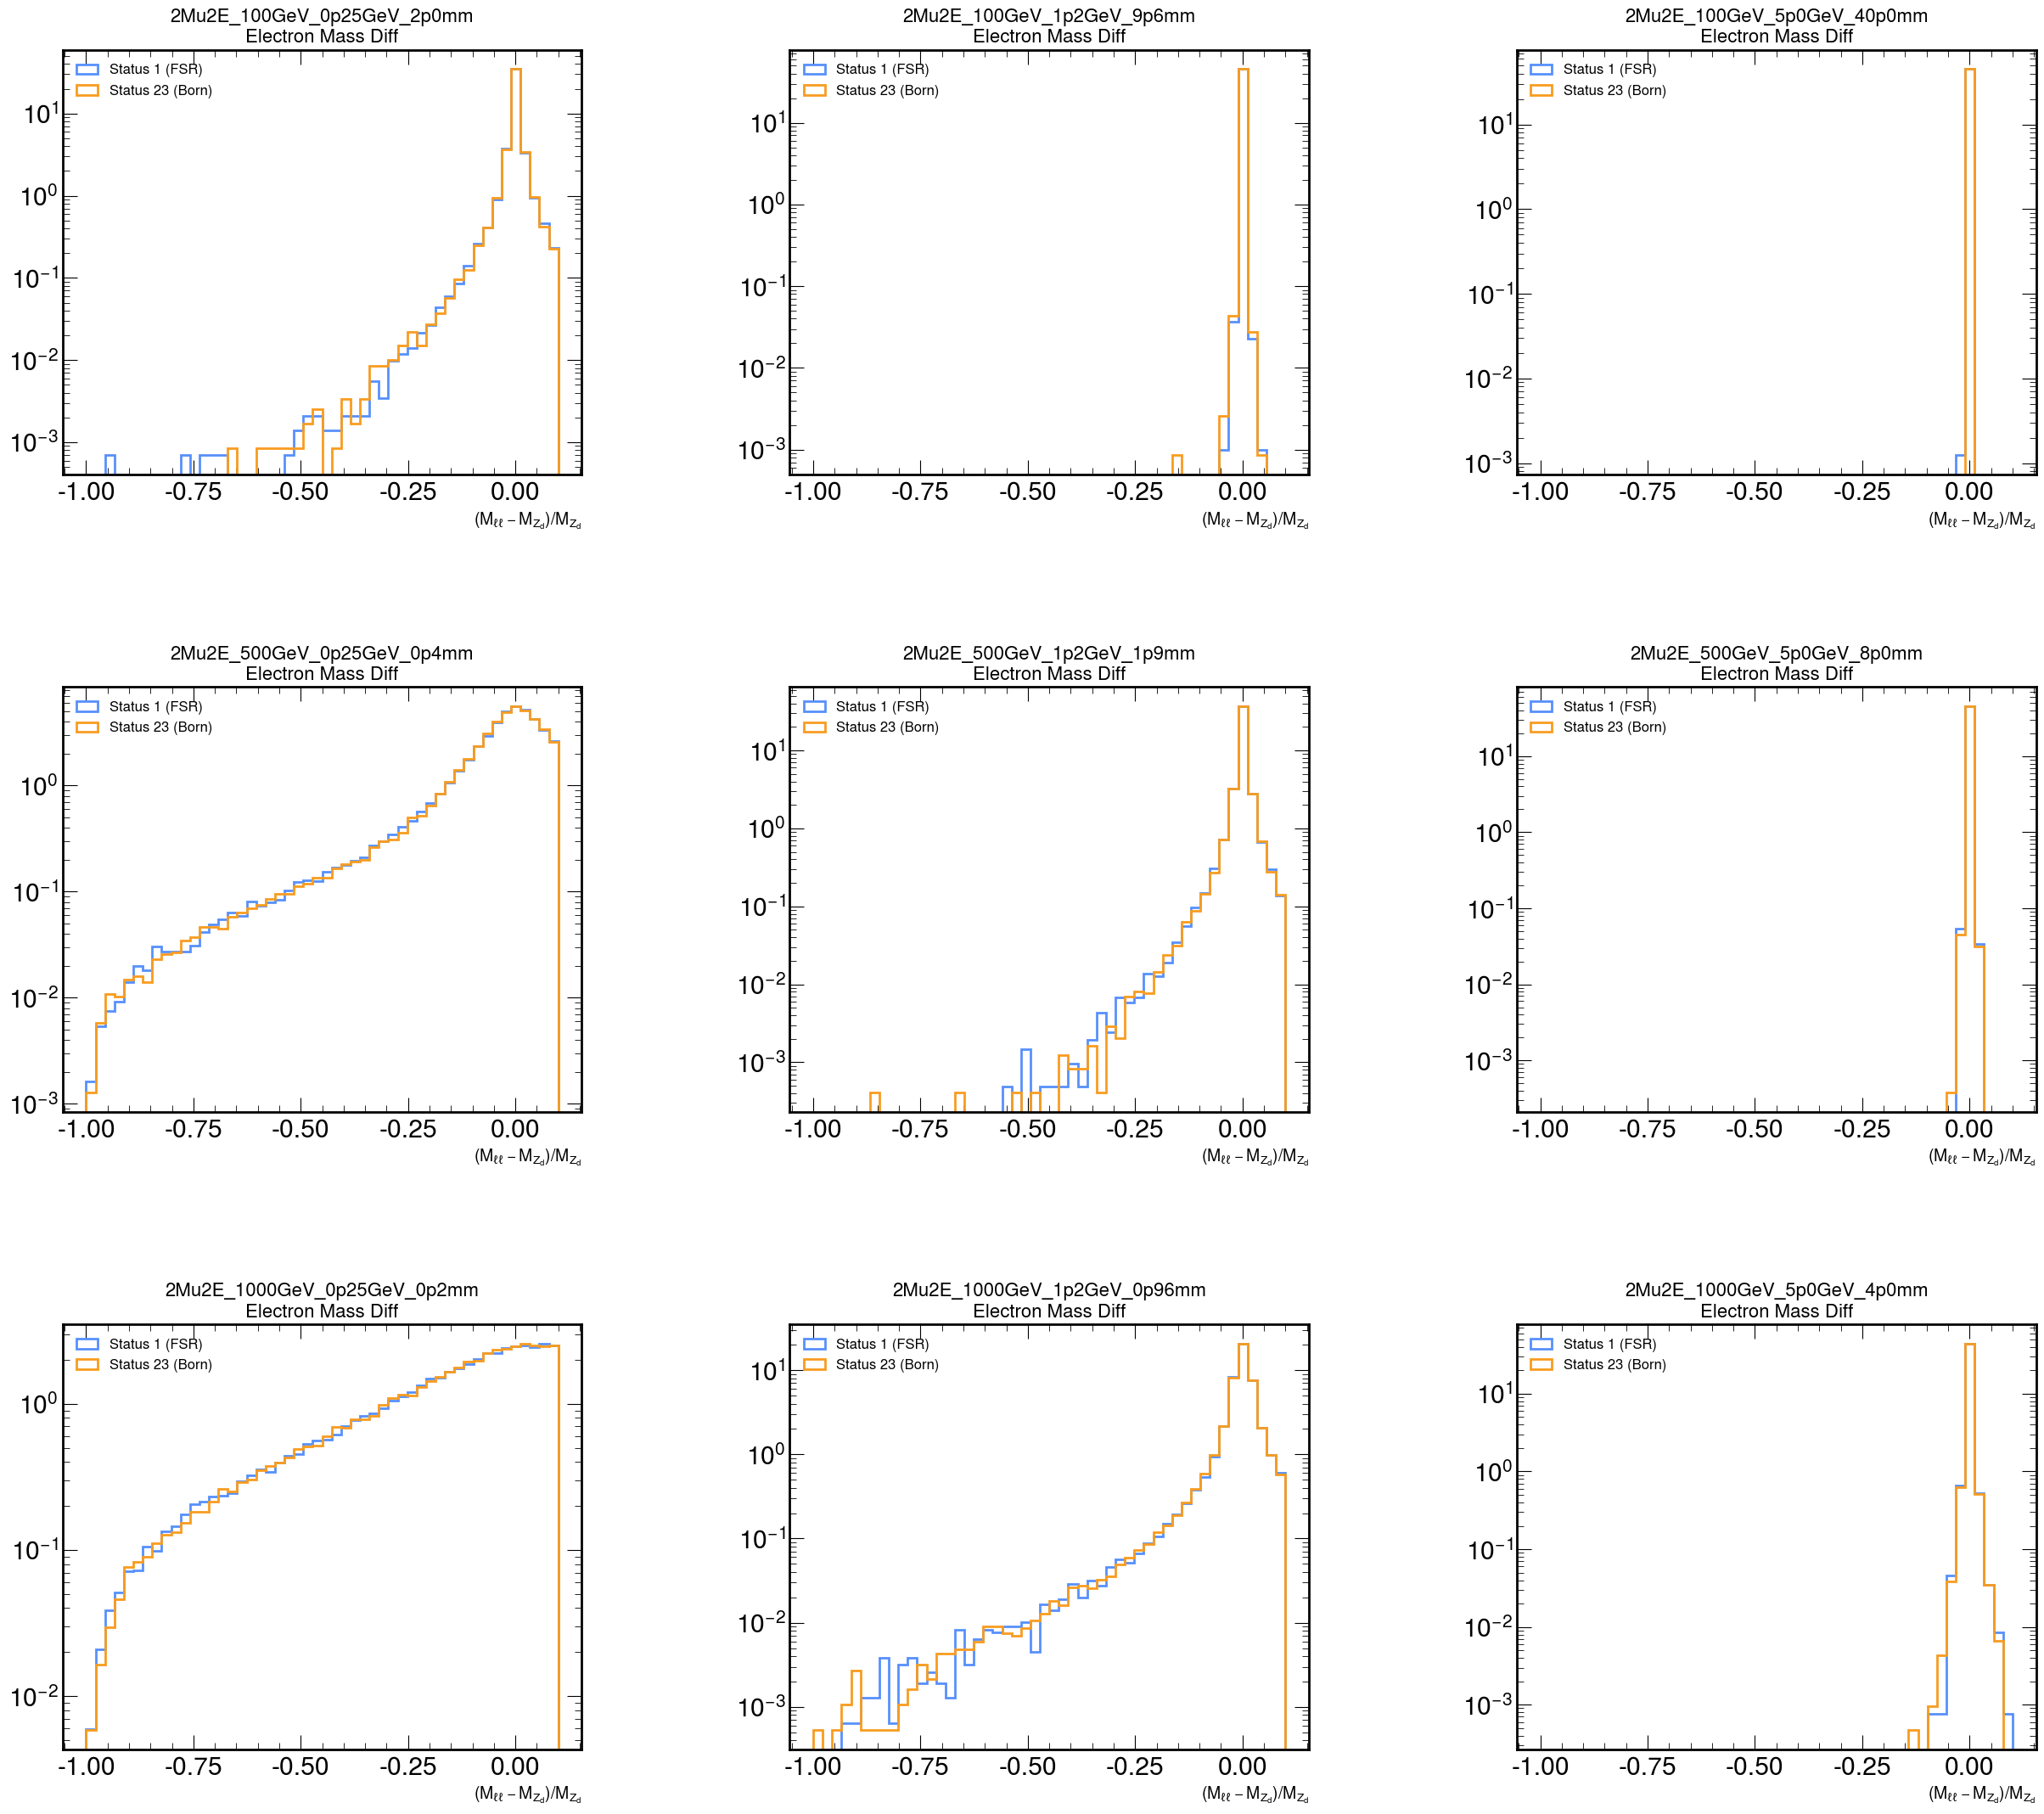

--- Generating Plot Type 12 ---


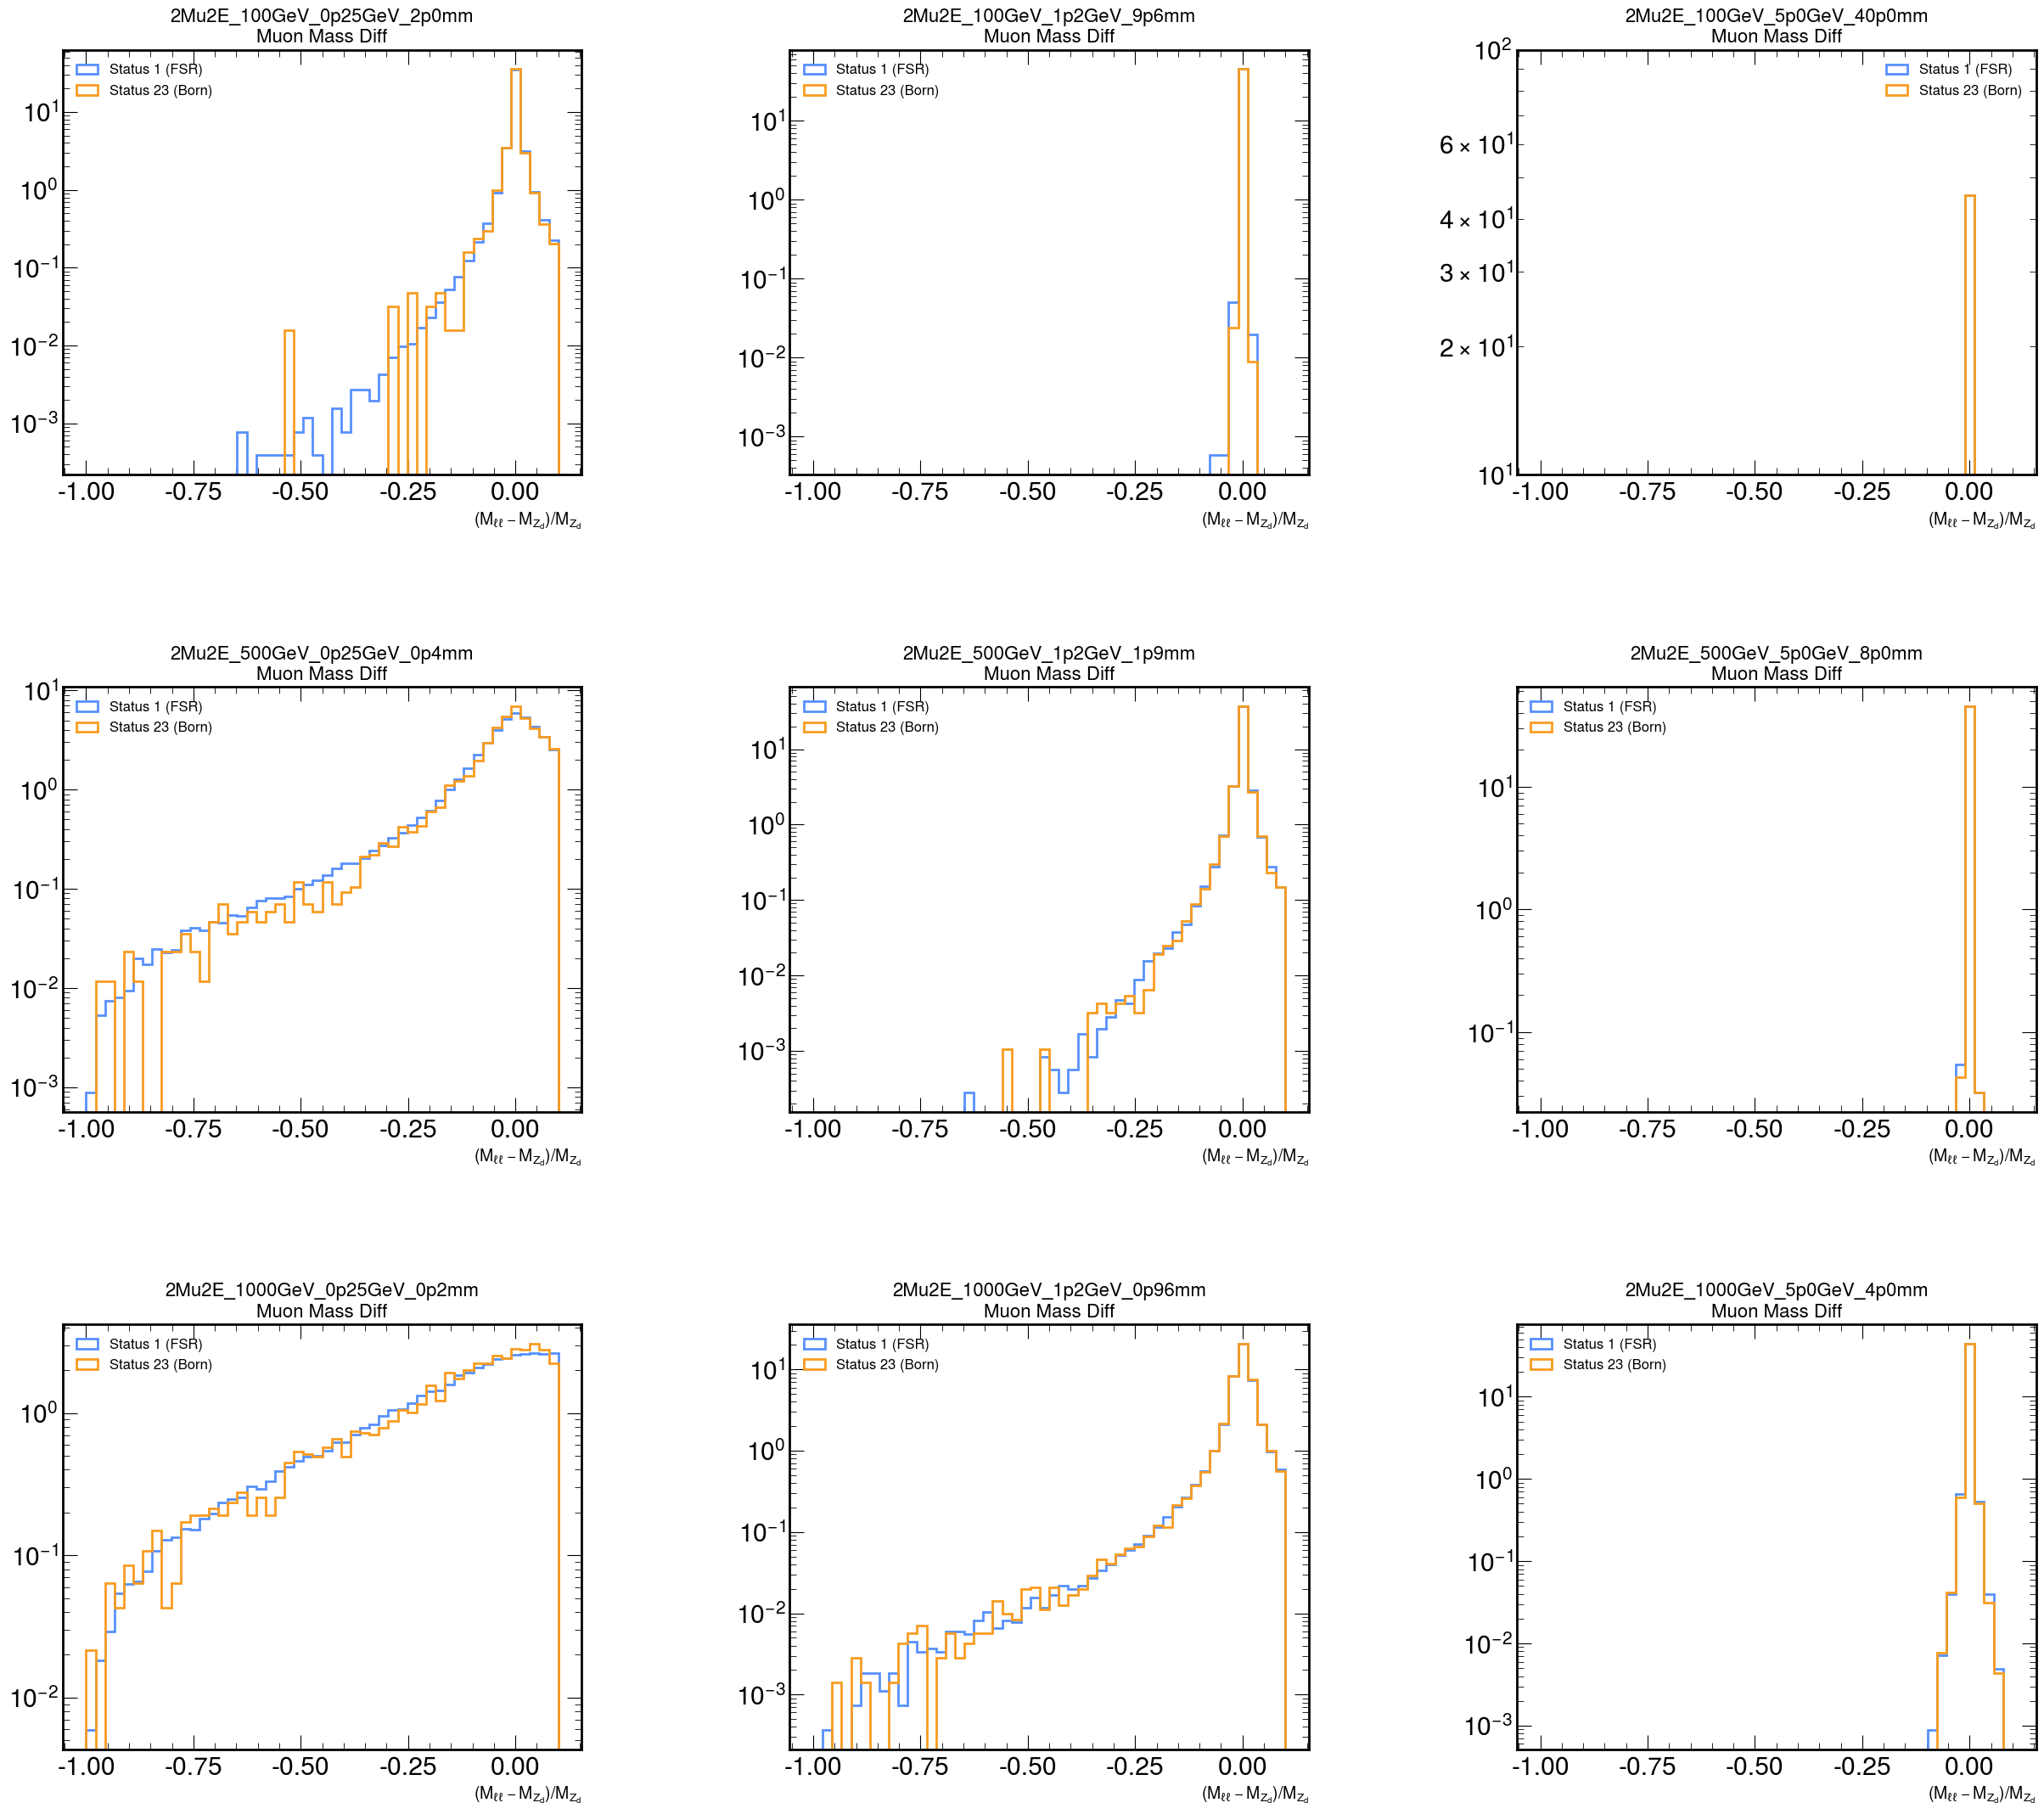

In [54]:
plot_master_grid(output, samples, plot_id=7)
plot_master_grid(output, samples, plot_id=8)
plot_master_grid(output, samples, plot_id=11)
plot_master_grid(output, samples, plot_id=12)

Above plots show that there isn't any appreciable effect of the status code on the pT of the leptons in the lab frame, for either electrons or muons. Also no appreciable effect on the Zd mass reconstructed from the two leptons

We should note here though, that as the Zd gets more massive, we do a better job of getting the mass of the Zd from the dilepton system. This is largely a consequence of resolution I believe, with the highly collimated dileptons in the light Zd / heavily boosted case suffering from reconstruction precision; Tiny differences in the 4 vectors will show up as non trivial changes a very light mass.

### Once we fix lepton masses, Zd mass looks OK

--- Generating Plot Type 9 ---


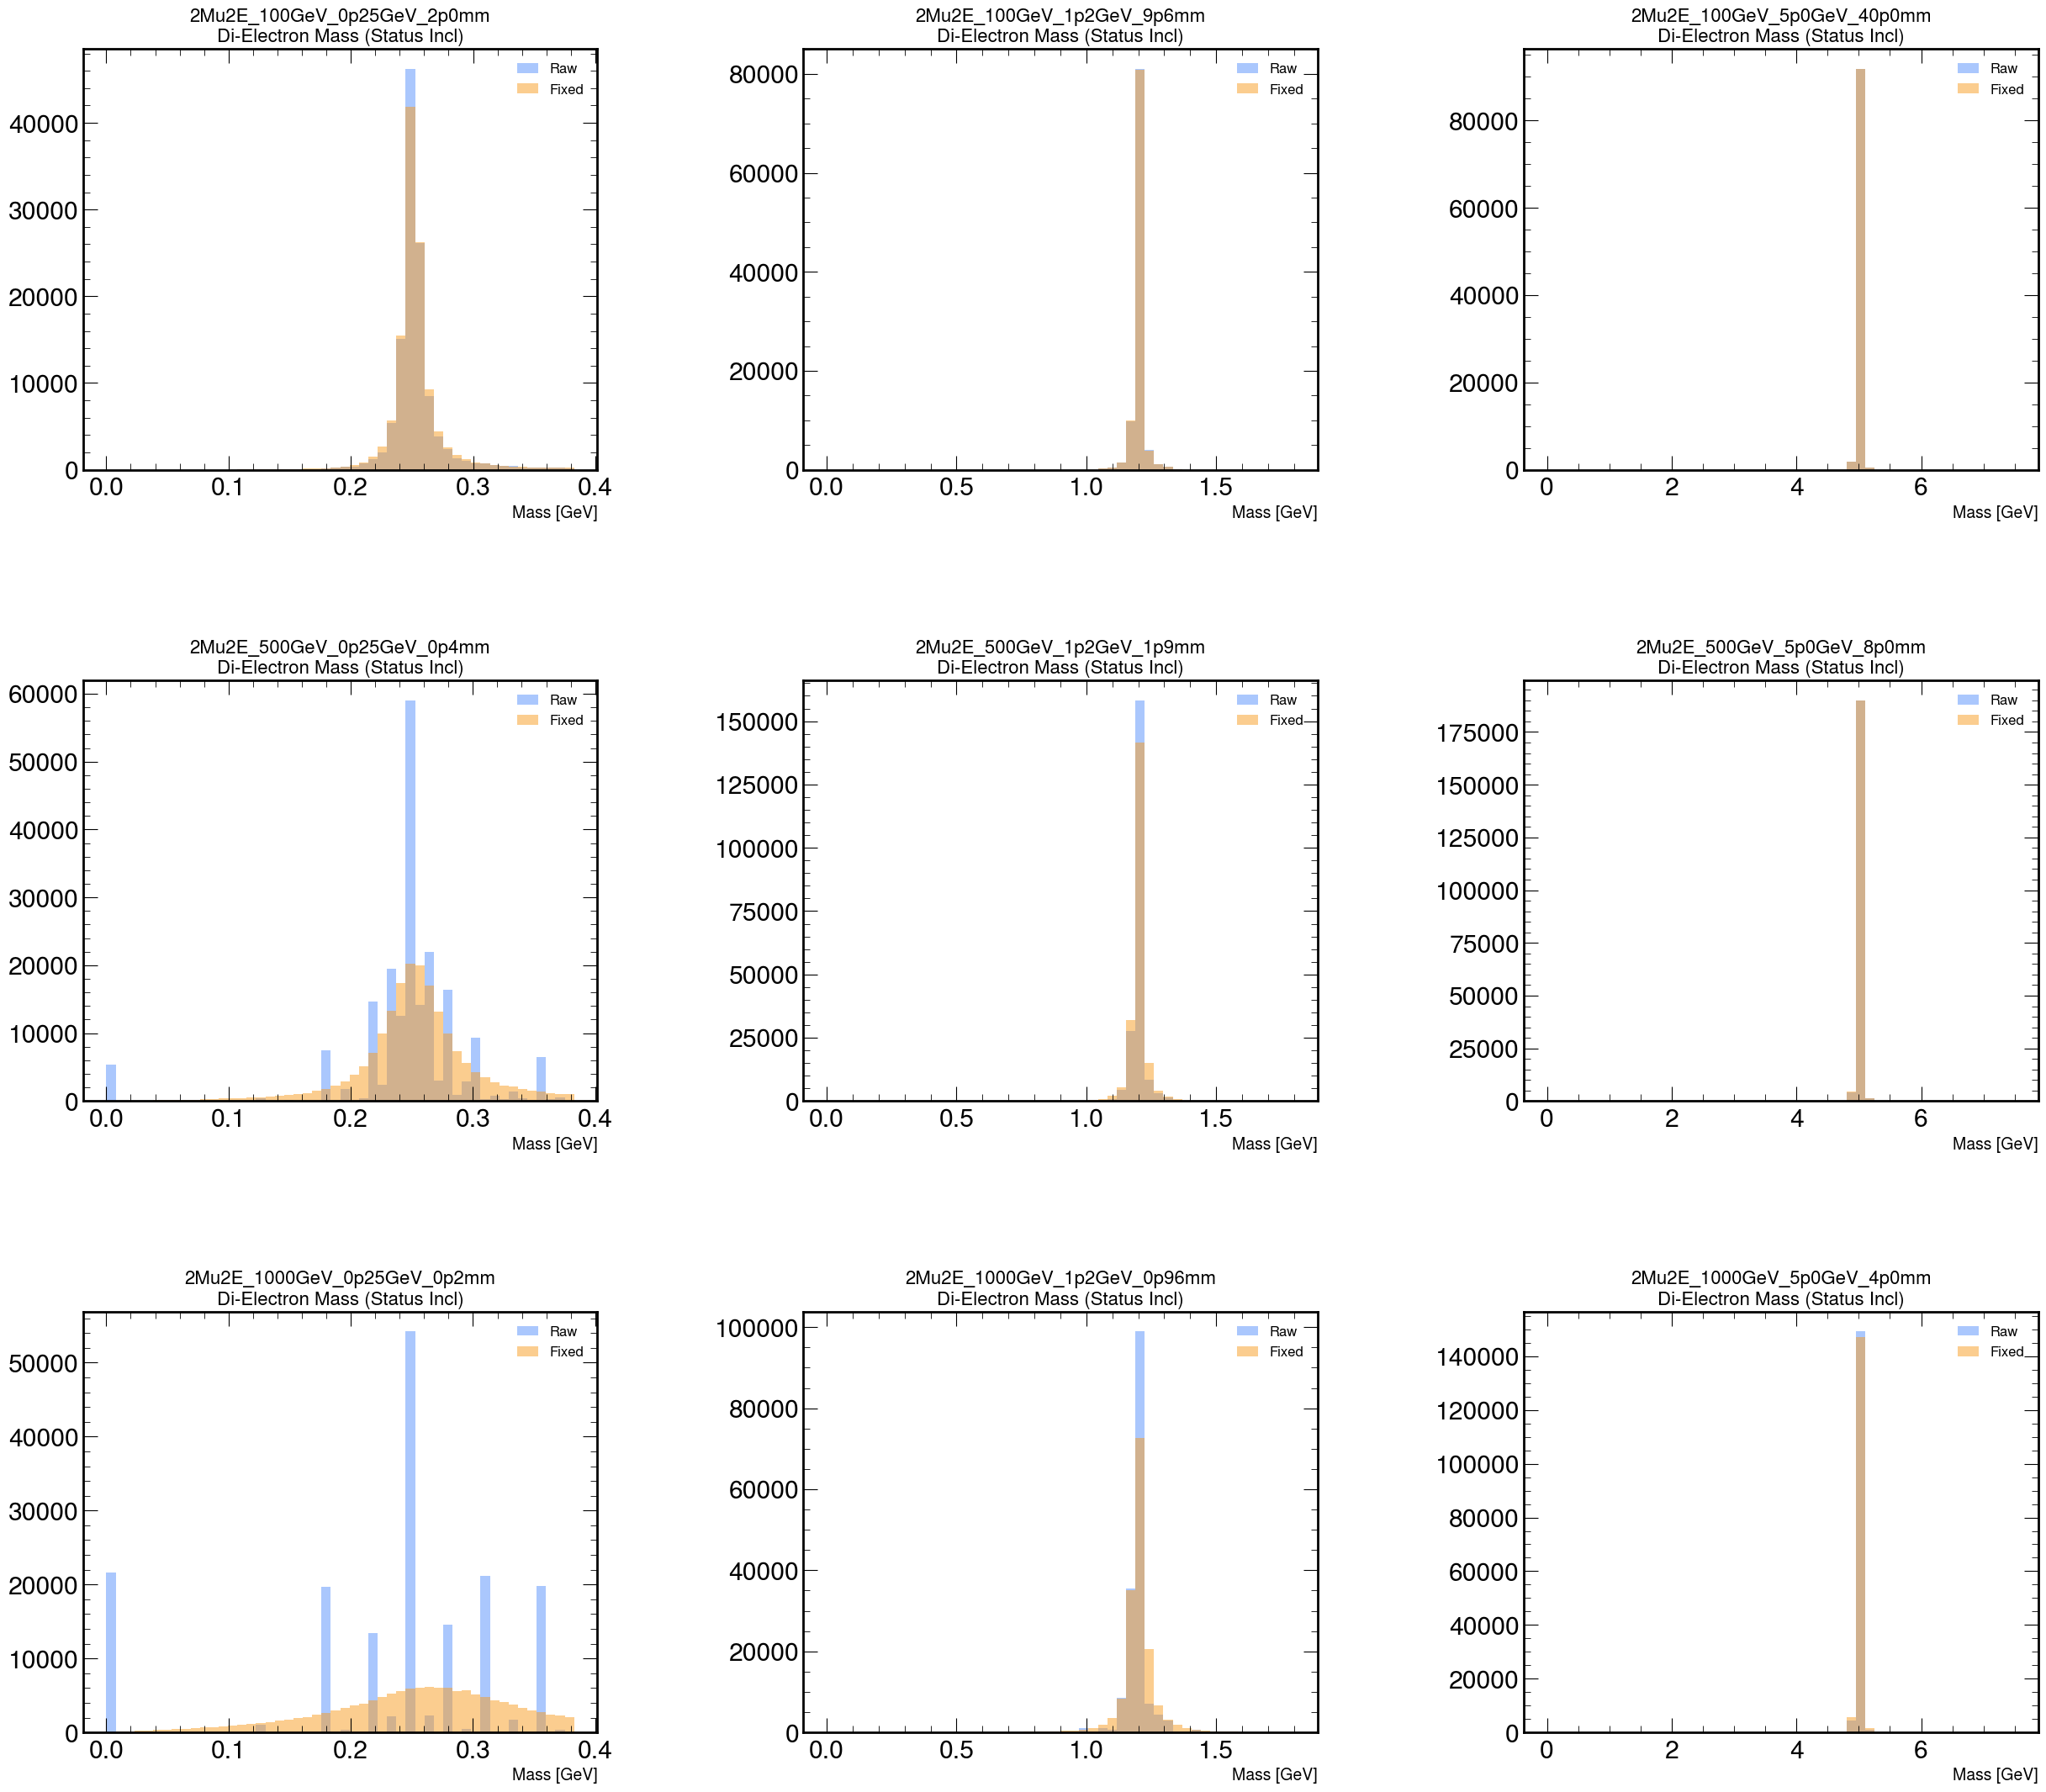

--- Generating Plot Type 10 ---


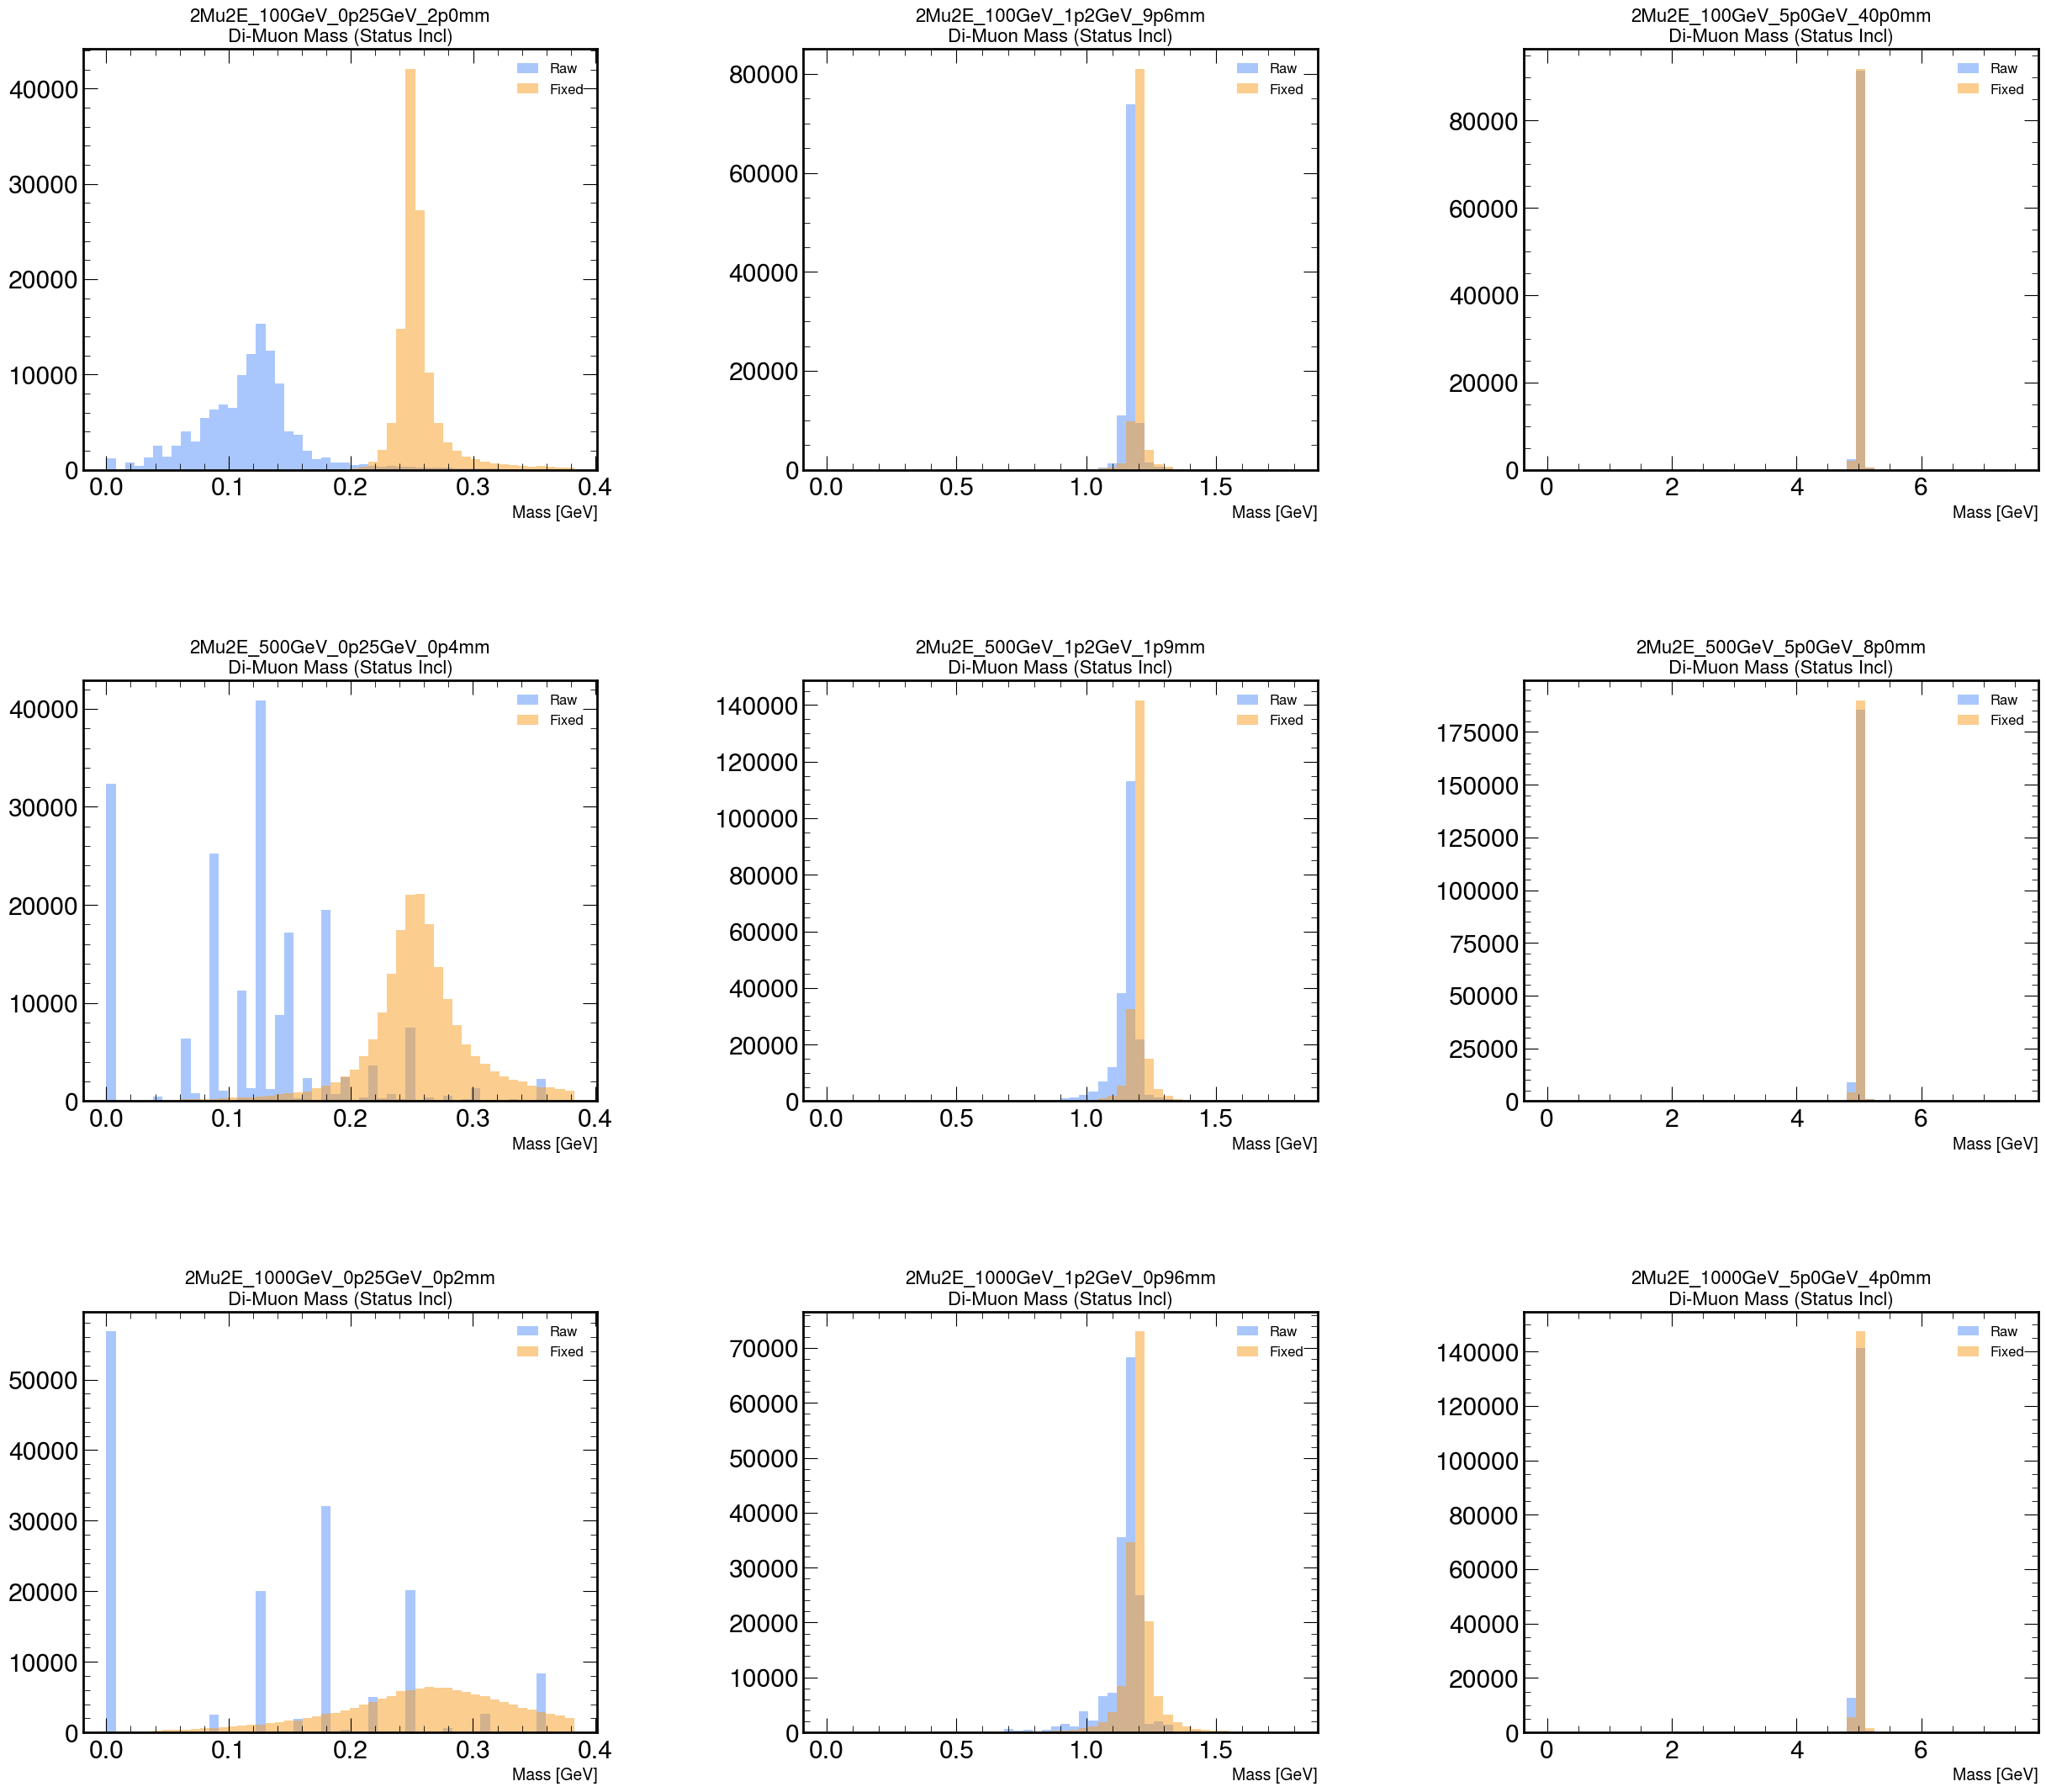

In [55]:
plot_master_grid(output, samples, plot_id=9)
plot_master_grid(output, samples, plot_id=10)

Note above the caveat with reconstruction precision affecting our Zd mass reconstruction from the dilepton system, which is most challenging when we have the most boosted and lightest Zd case. I think this is expected, and is also why we don't rely on being able to nail this reconstruction

### Zd rest frame, Lepton kinematics

--- Generating Plot Type 21 ---


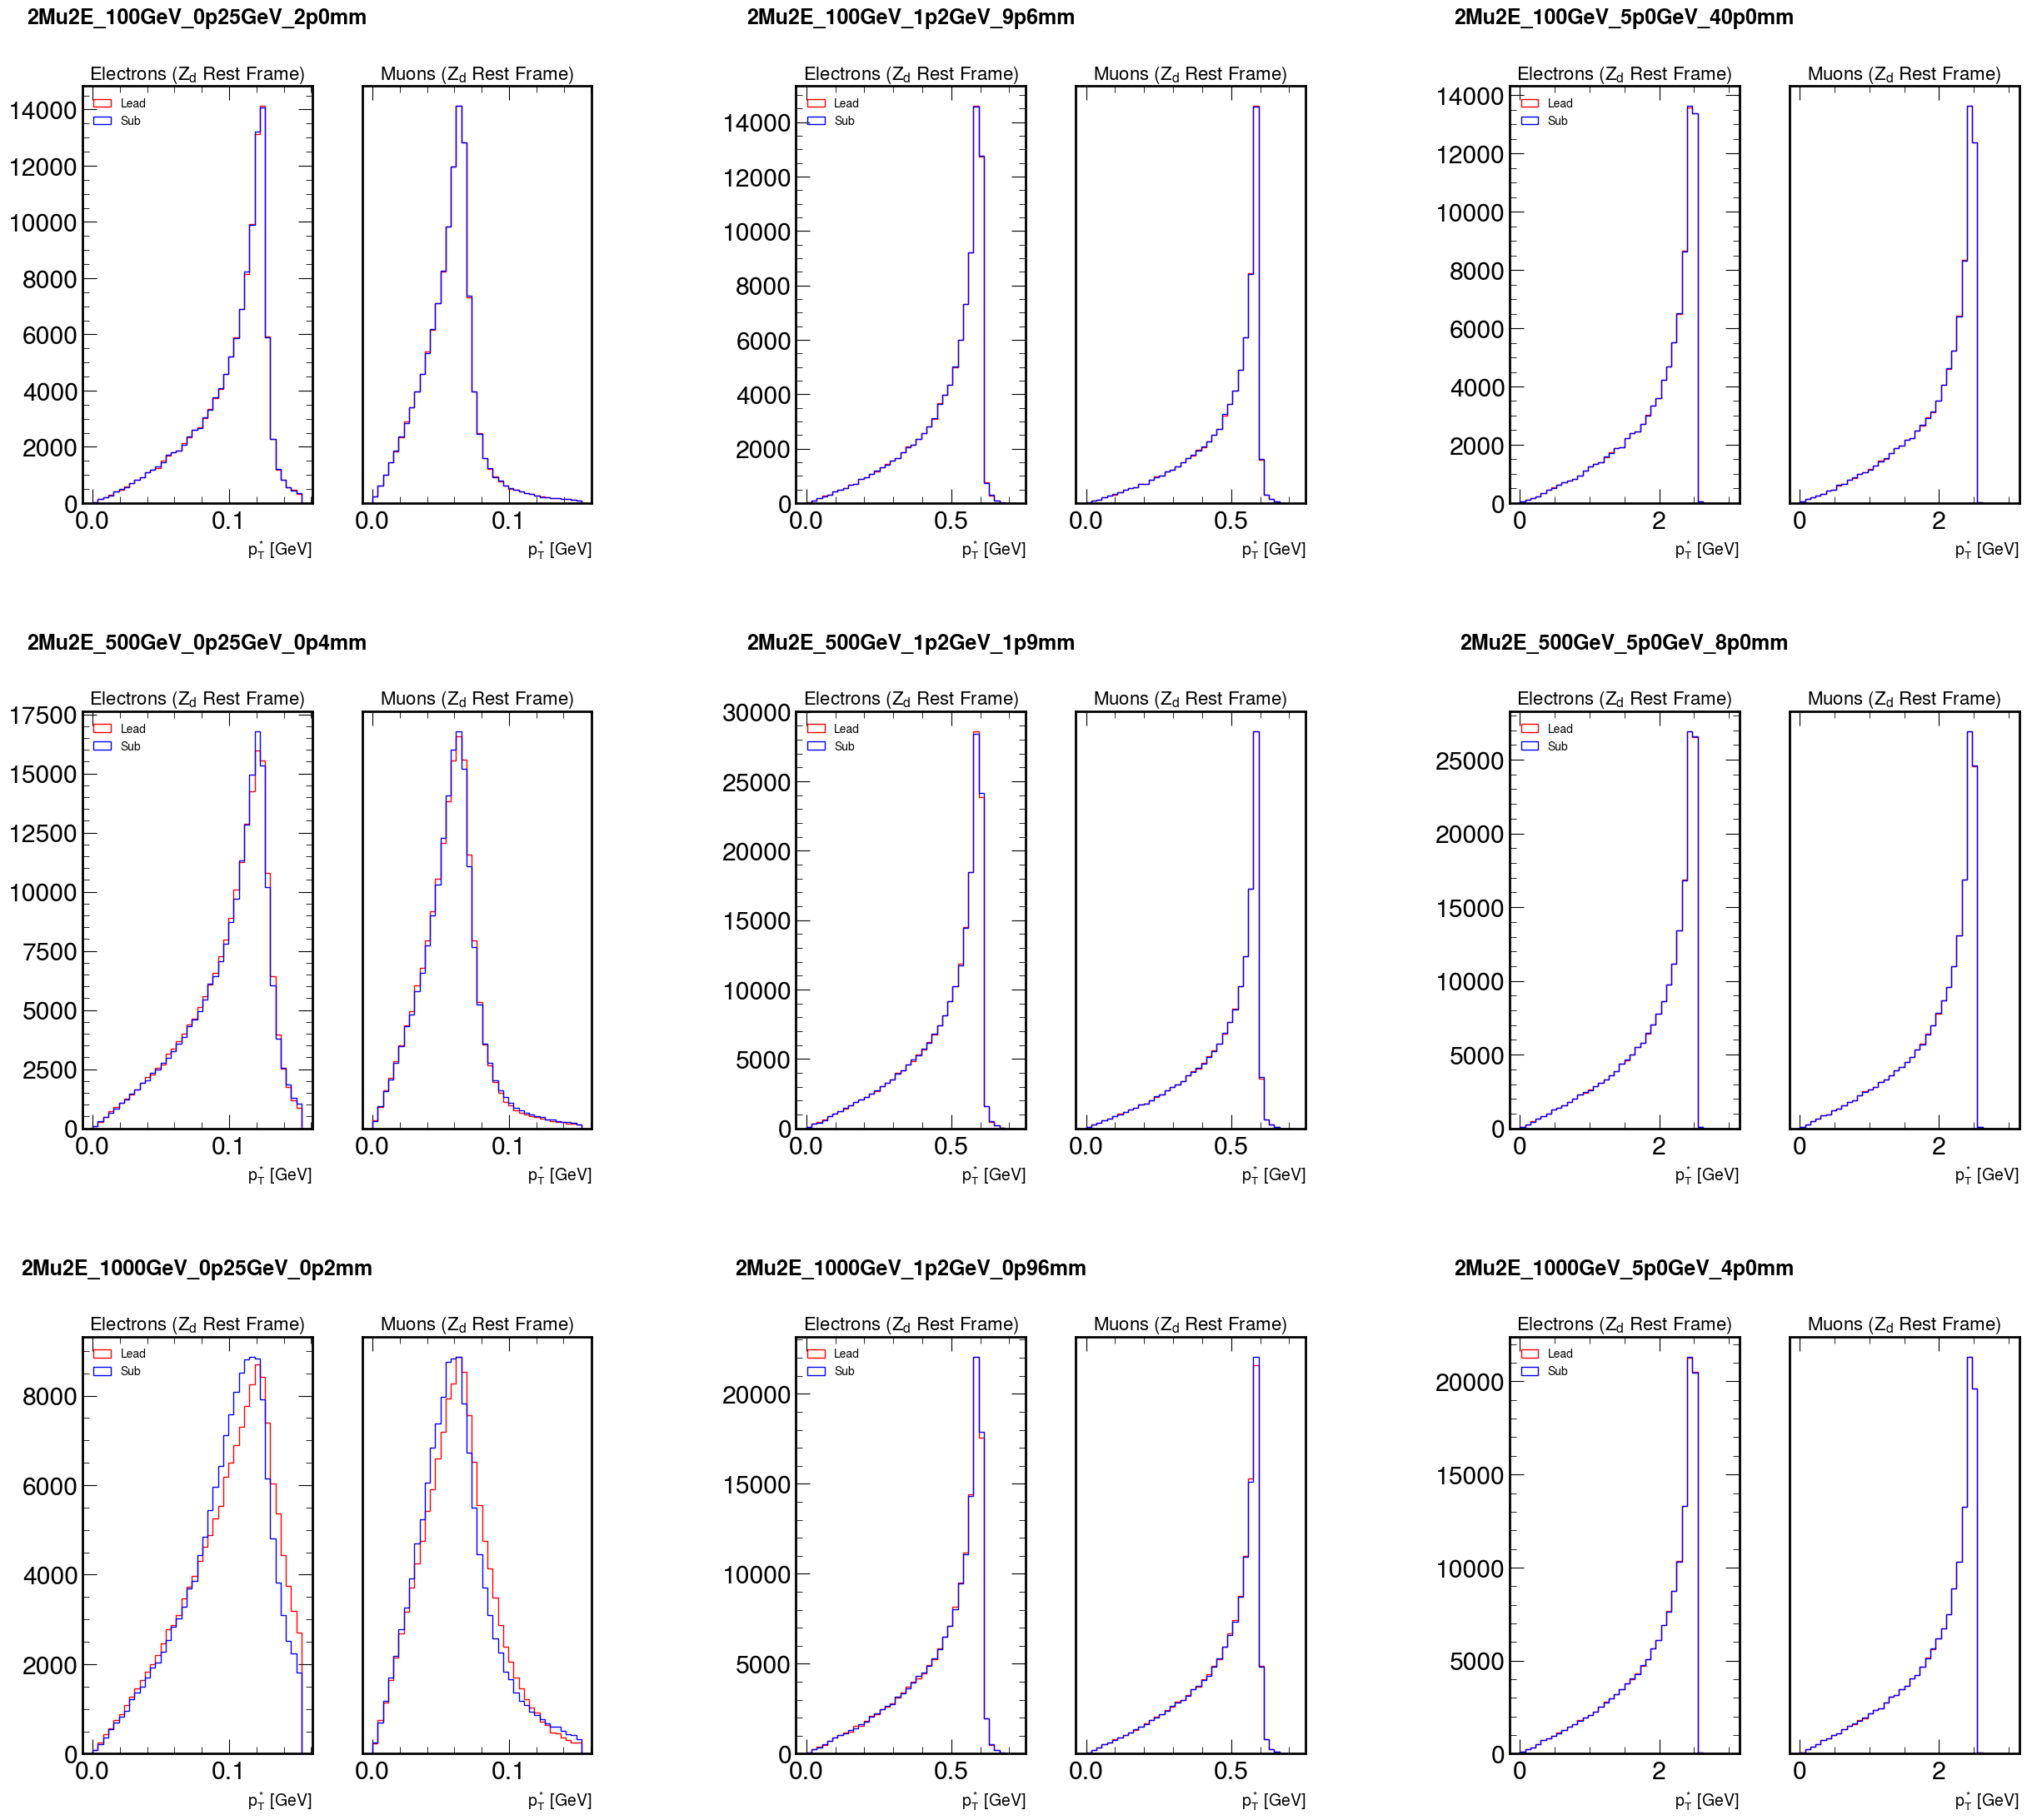

In [56]:
plot_master_grid(output, samples, plot_id=21)

As seen above, the two leptons are of course largely symmetric

--- Generating Plot Type 22 ---


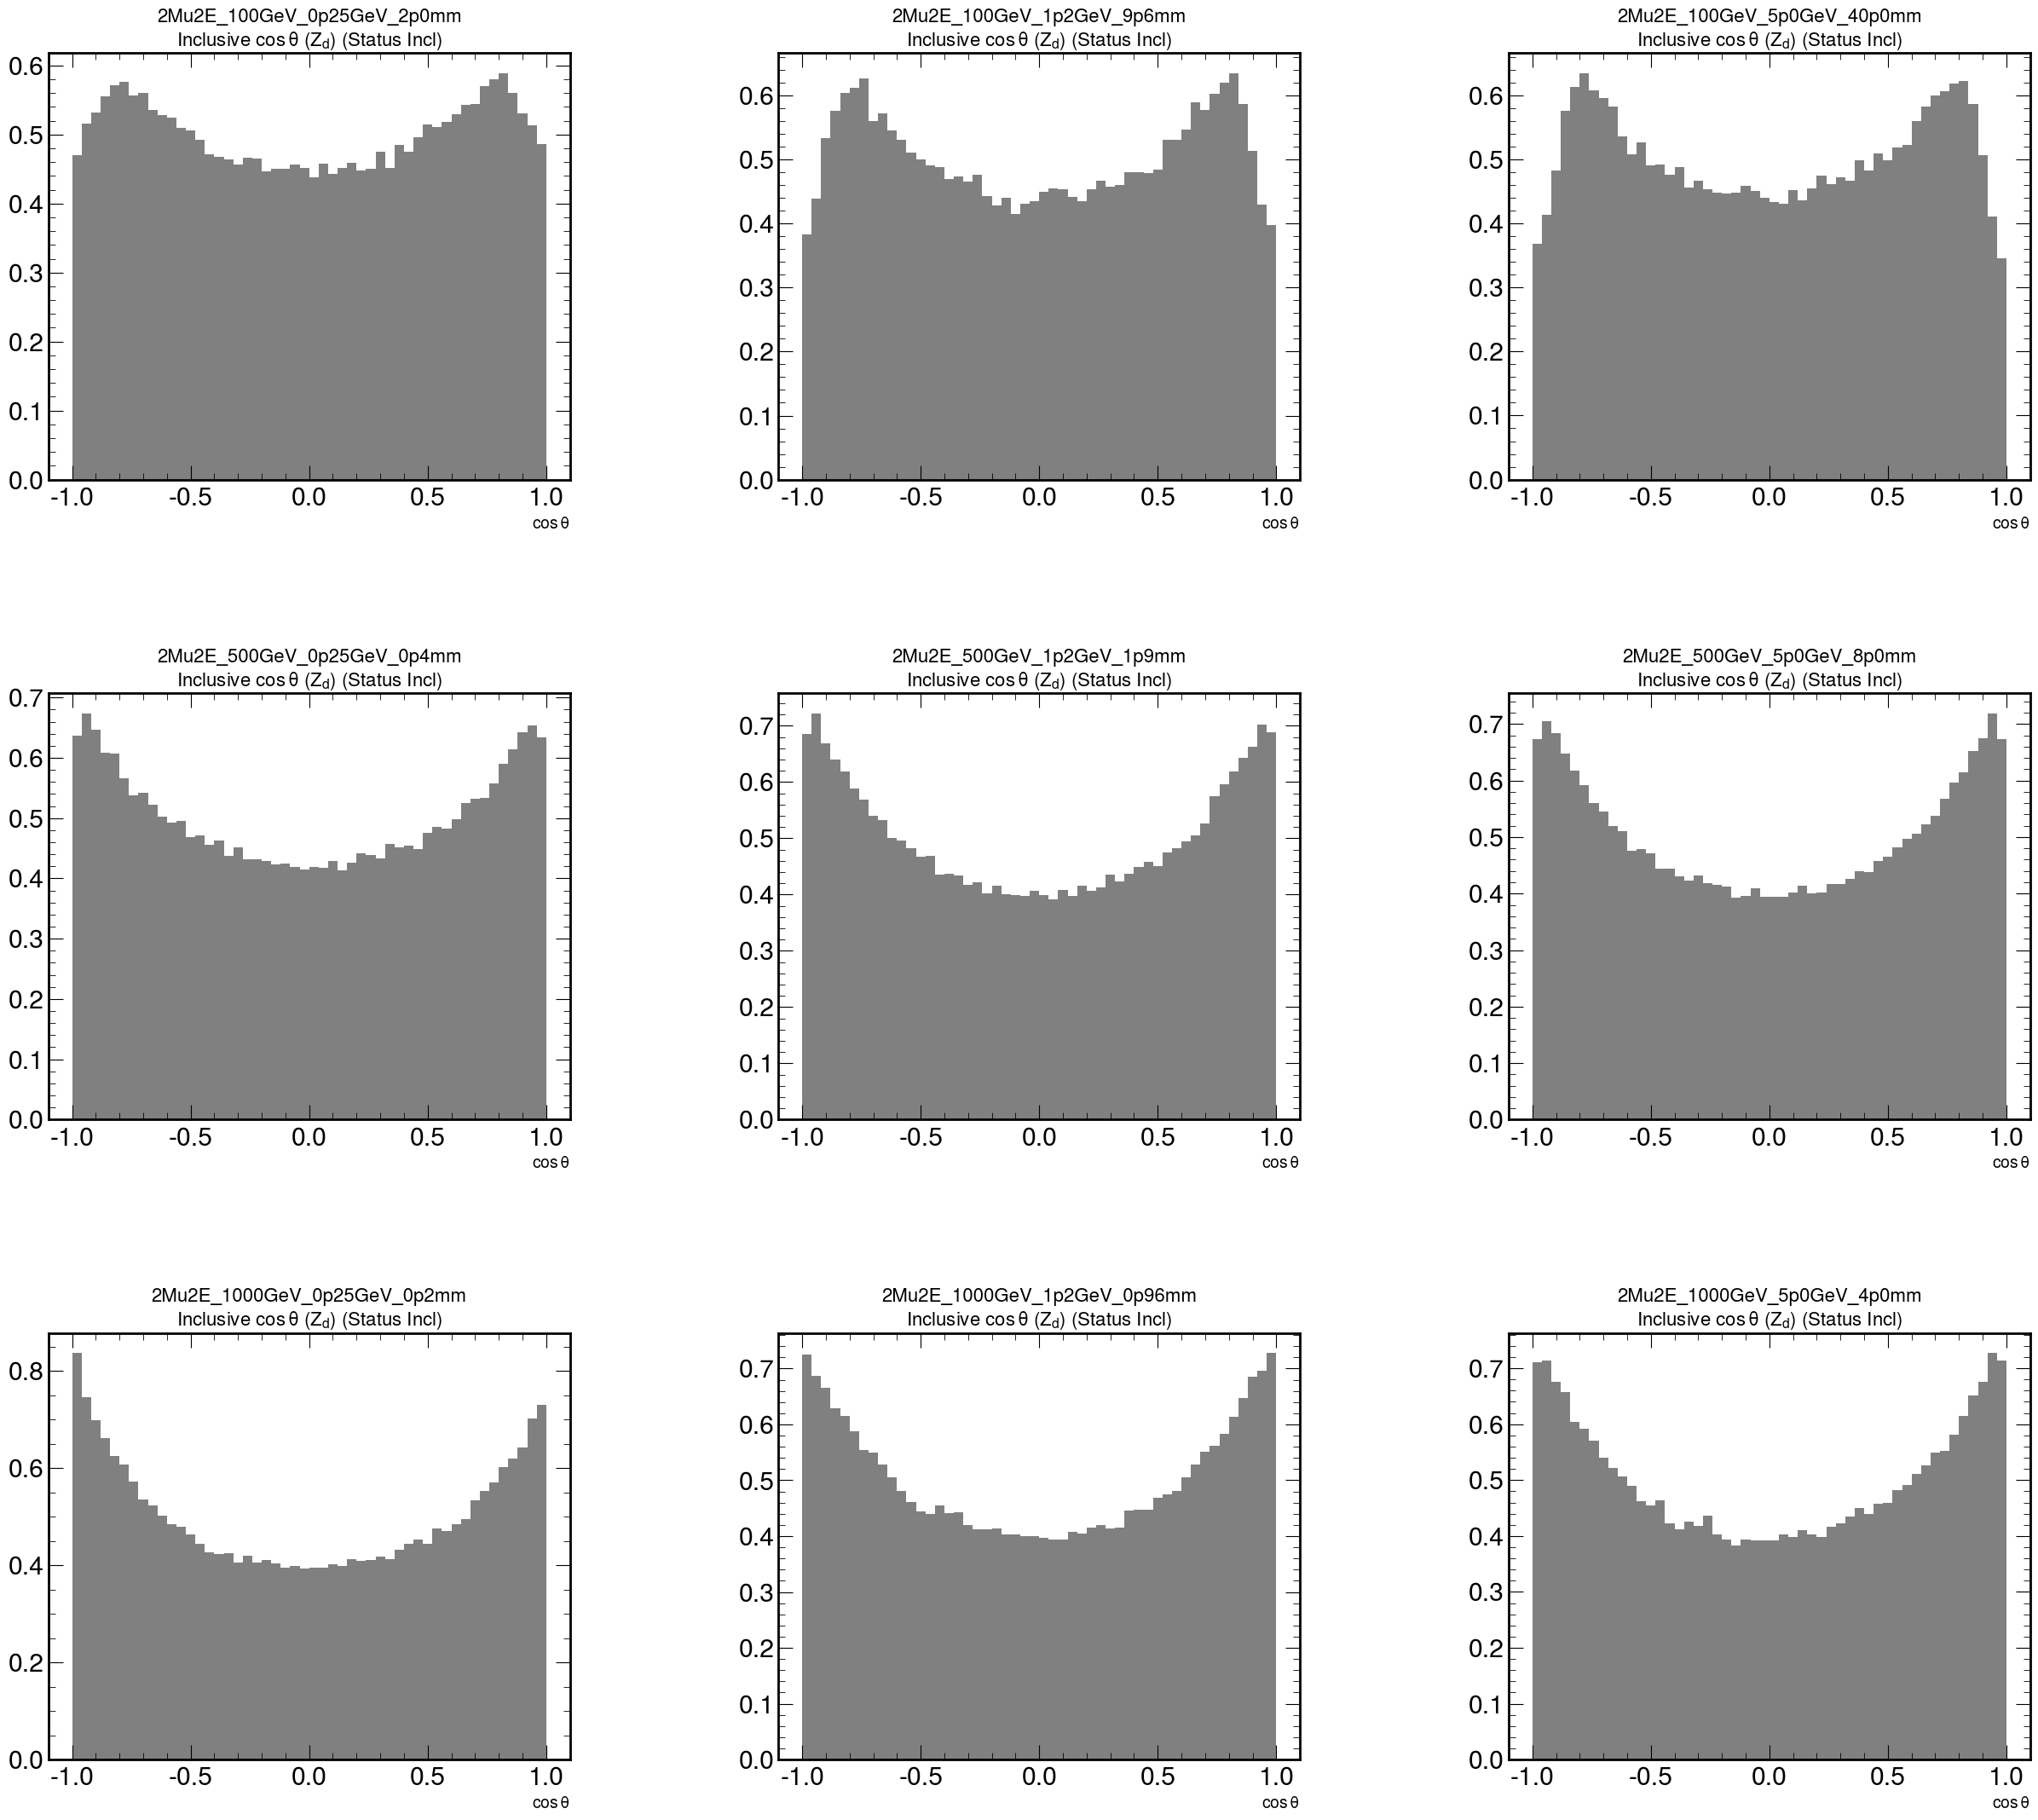

In [57]:
plot_master_grid(output, samples, plot_id=22)

The above inclusive (electrons/muons and status) plot of $\cos(\theta)$ of the leptons in the $Z_d$ frame wrt the photon boost direction is encouraging. We see an asymmetric distribution, where there are peaks along the direction of the boost. This is in line with our expectation for the Spin 1 $Z_d$ decaying to two Spin 1/2 leptons. More on this later when we will fit to these shapes for electrons and muons separately

--- Generating Plot Type 26 ---


/usr/local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4859: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


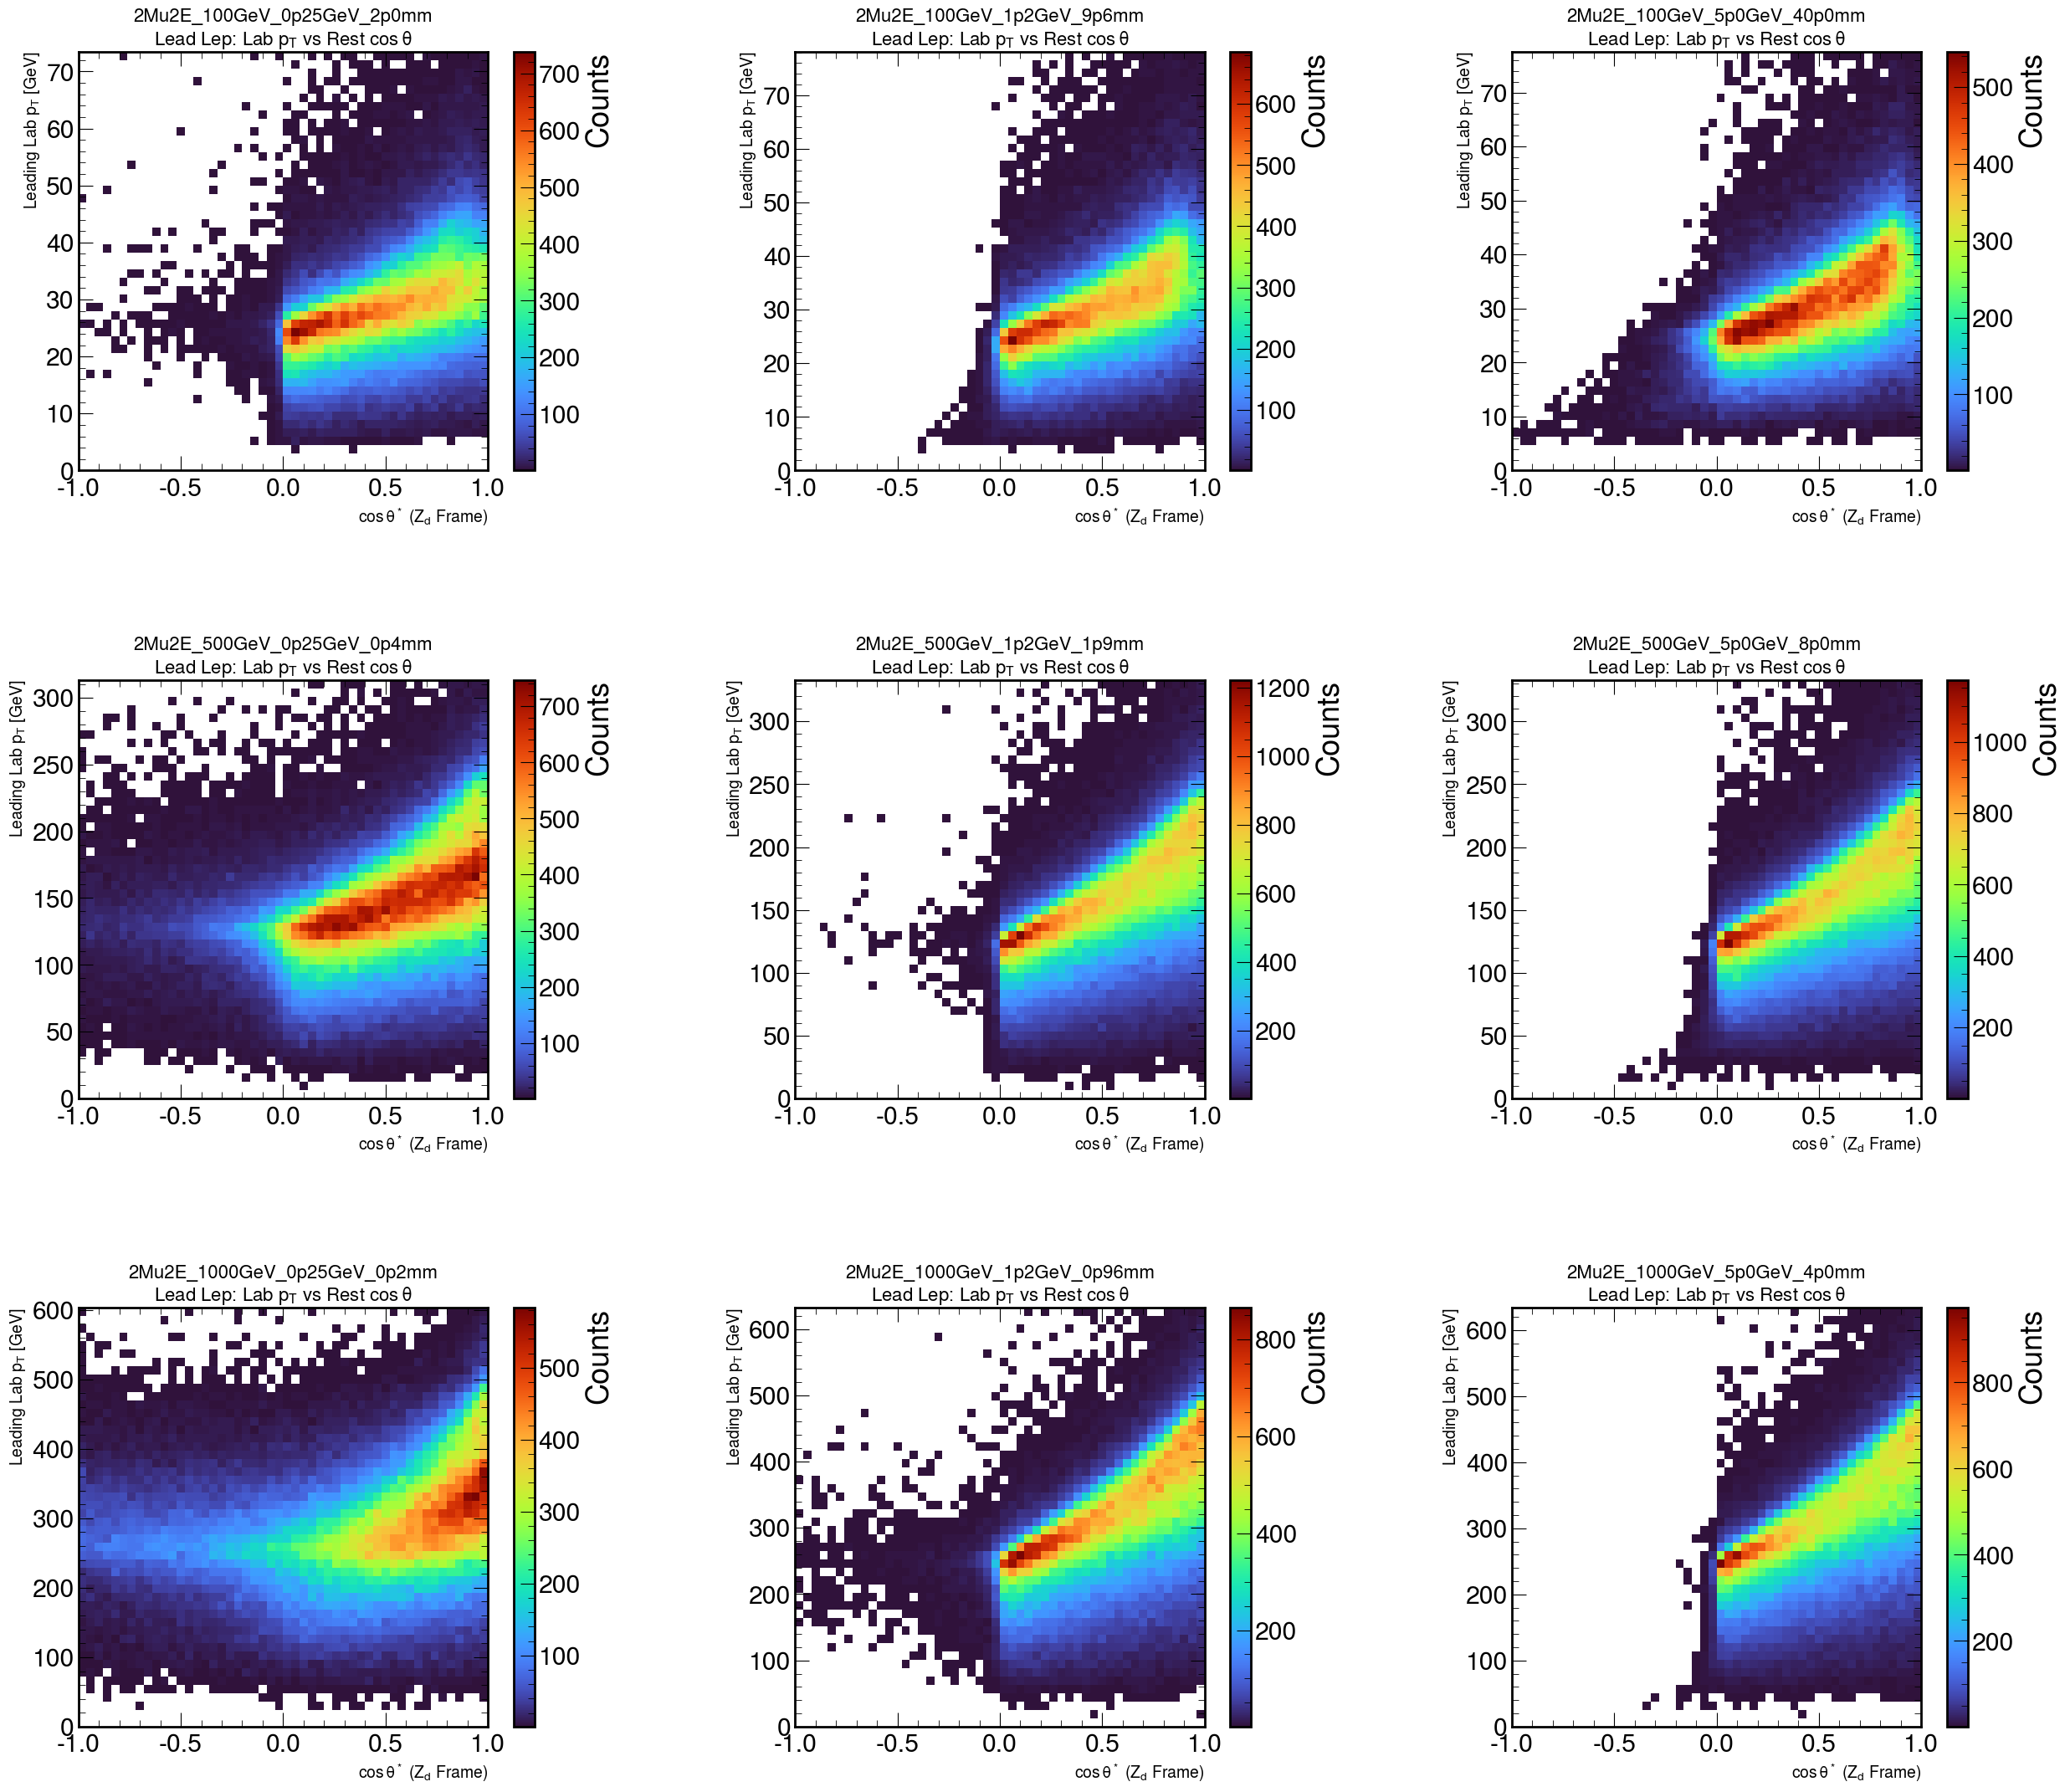

--- Generating Plot Type 27 ---


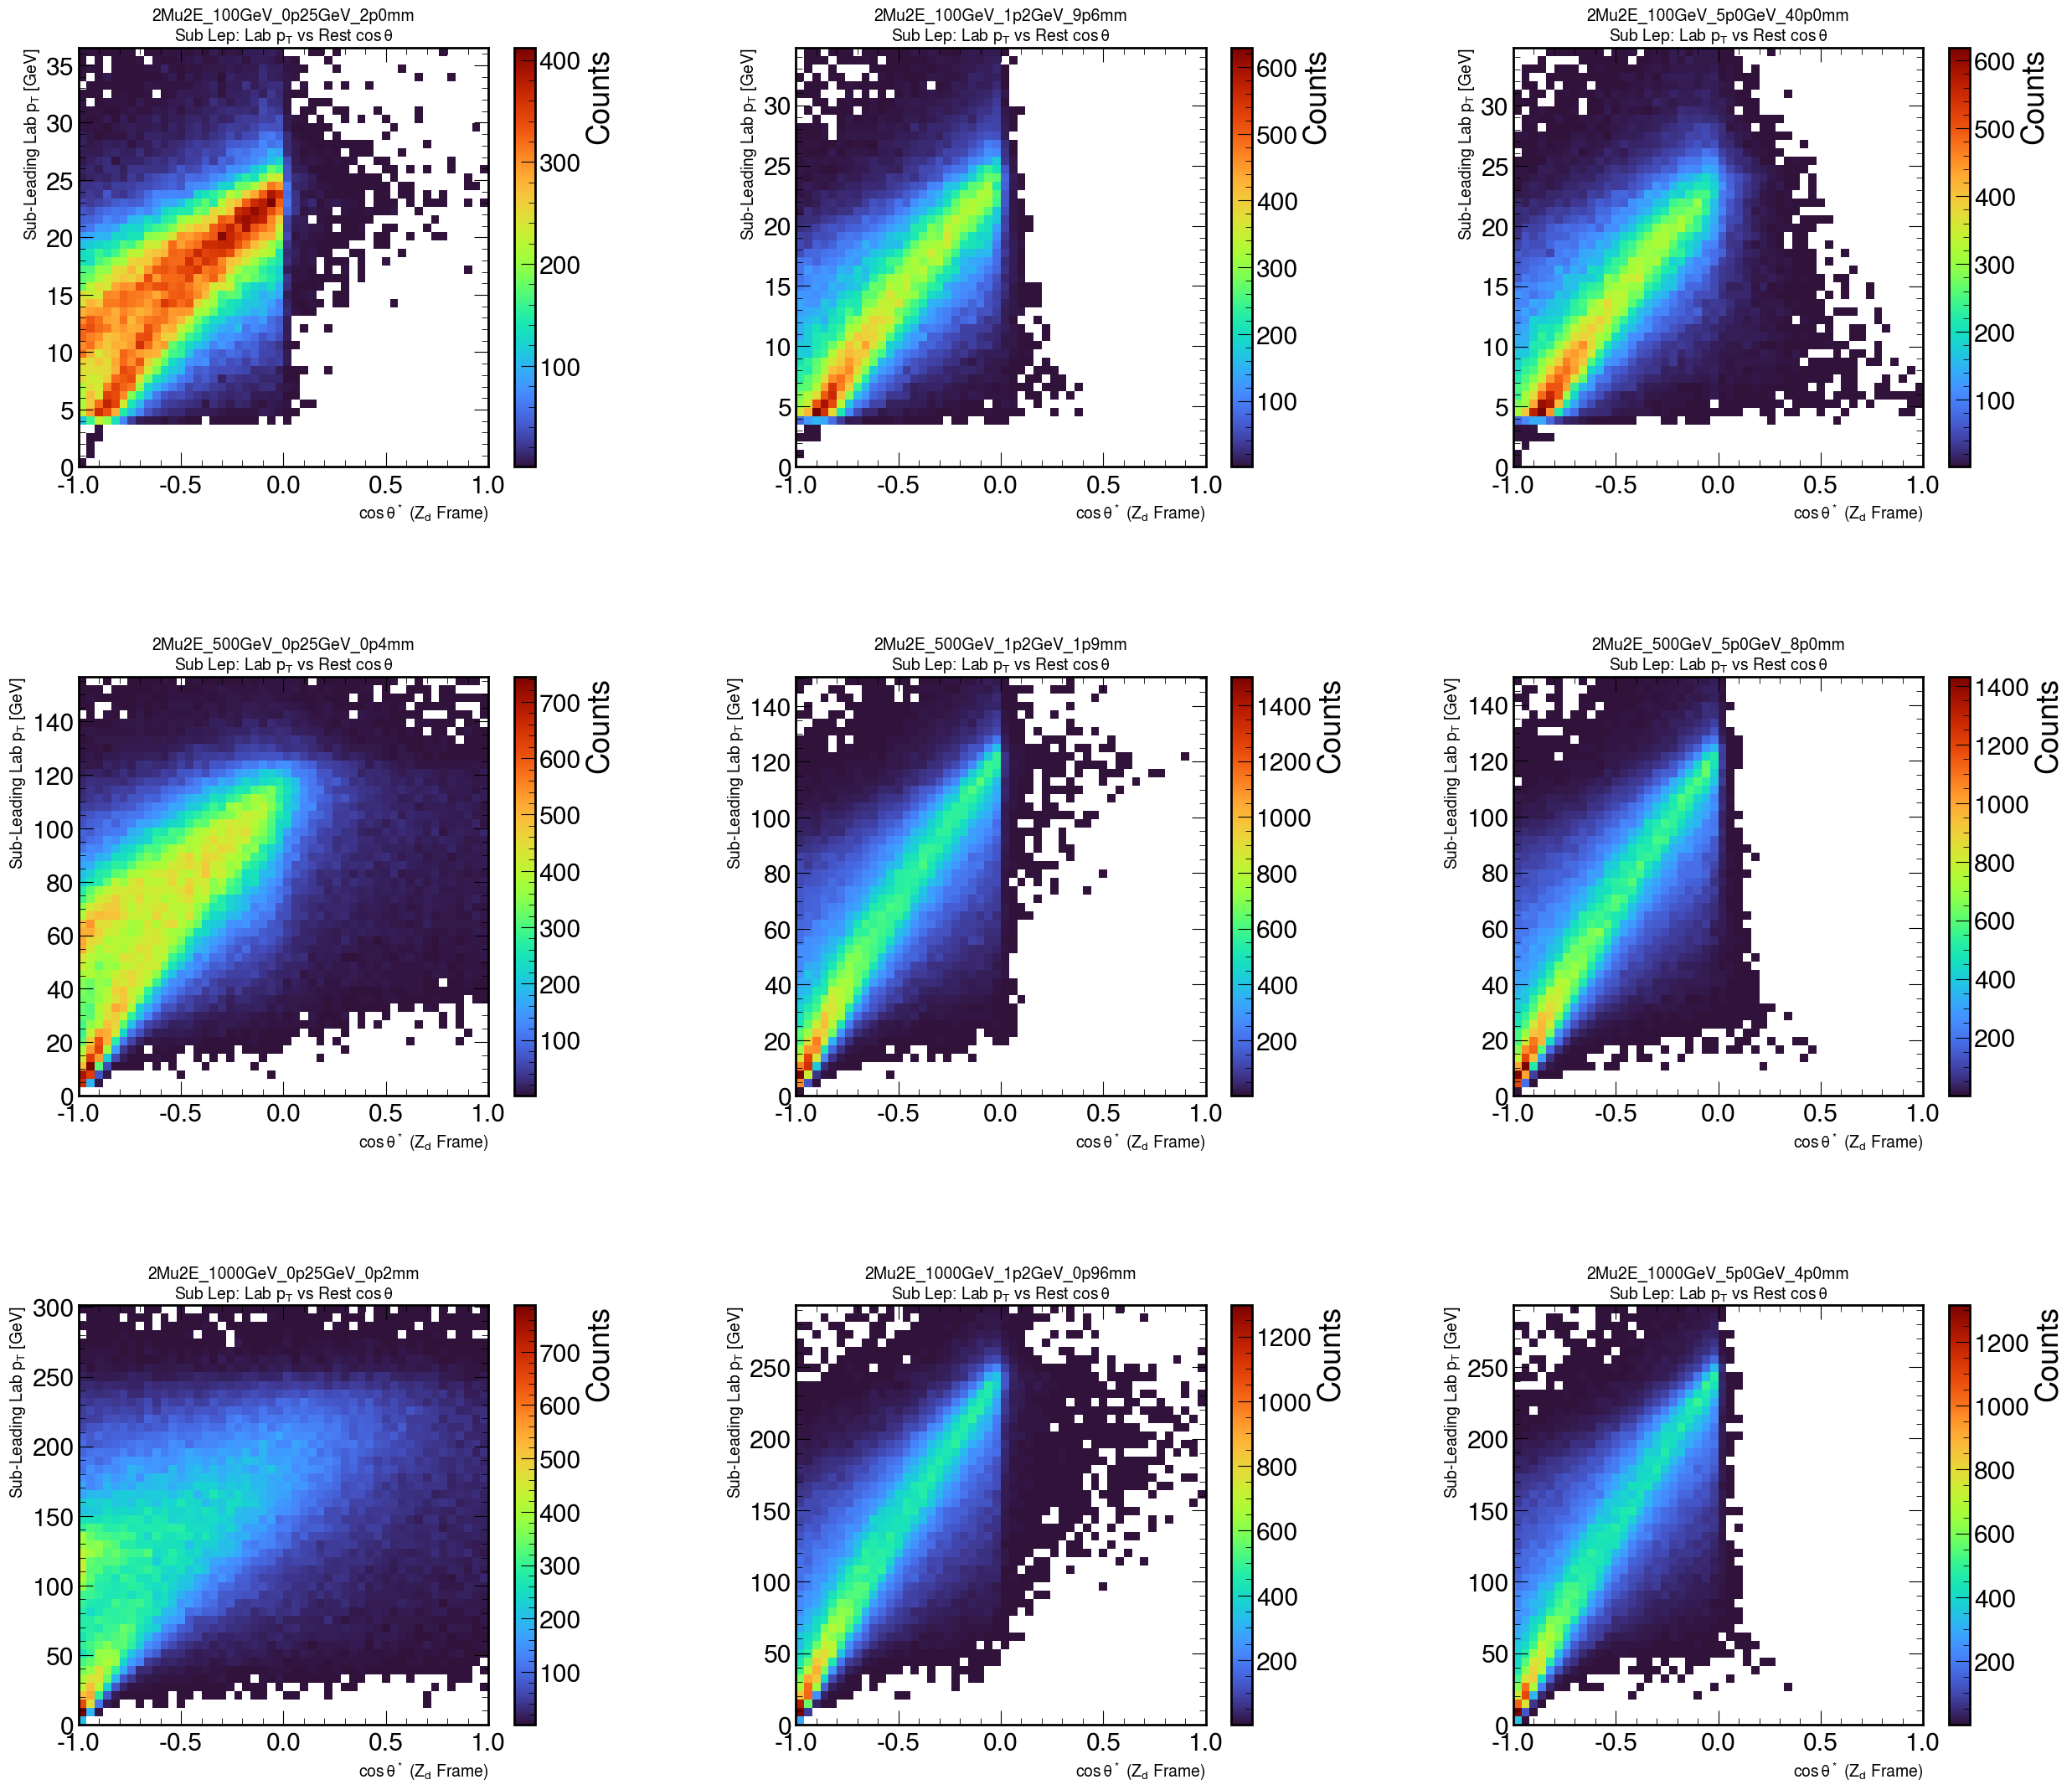

In [58]:
plot_master_grid(output, samples, plot_id=26)
plot_master_grid(output, samples, plot_id=27)

This plot above is noteworthy. It is plotting the $\cos(\theta)$ of the leading lepton in the lab frame with the Zd boost vector, versus the pT of the leading lepton, and also the sub leading lepton.

Note how particularly for the subleading leptons, we see a higher pT band for cases where the leading lepton is very collimated with the Zd. This is due to liekly due to FSR changing the angles of this lepton slightly, which is enough to spare the really steep hit this lepton gets in the lab frame when the Zd boost is applied

--- Generating Plot Type 28 ---


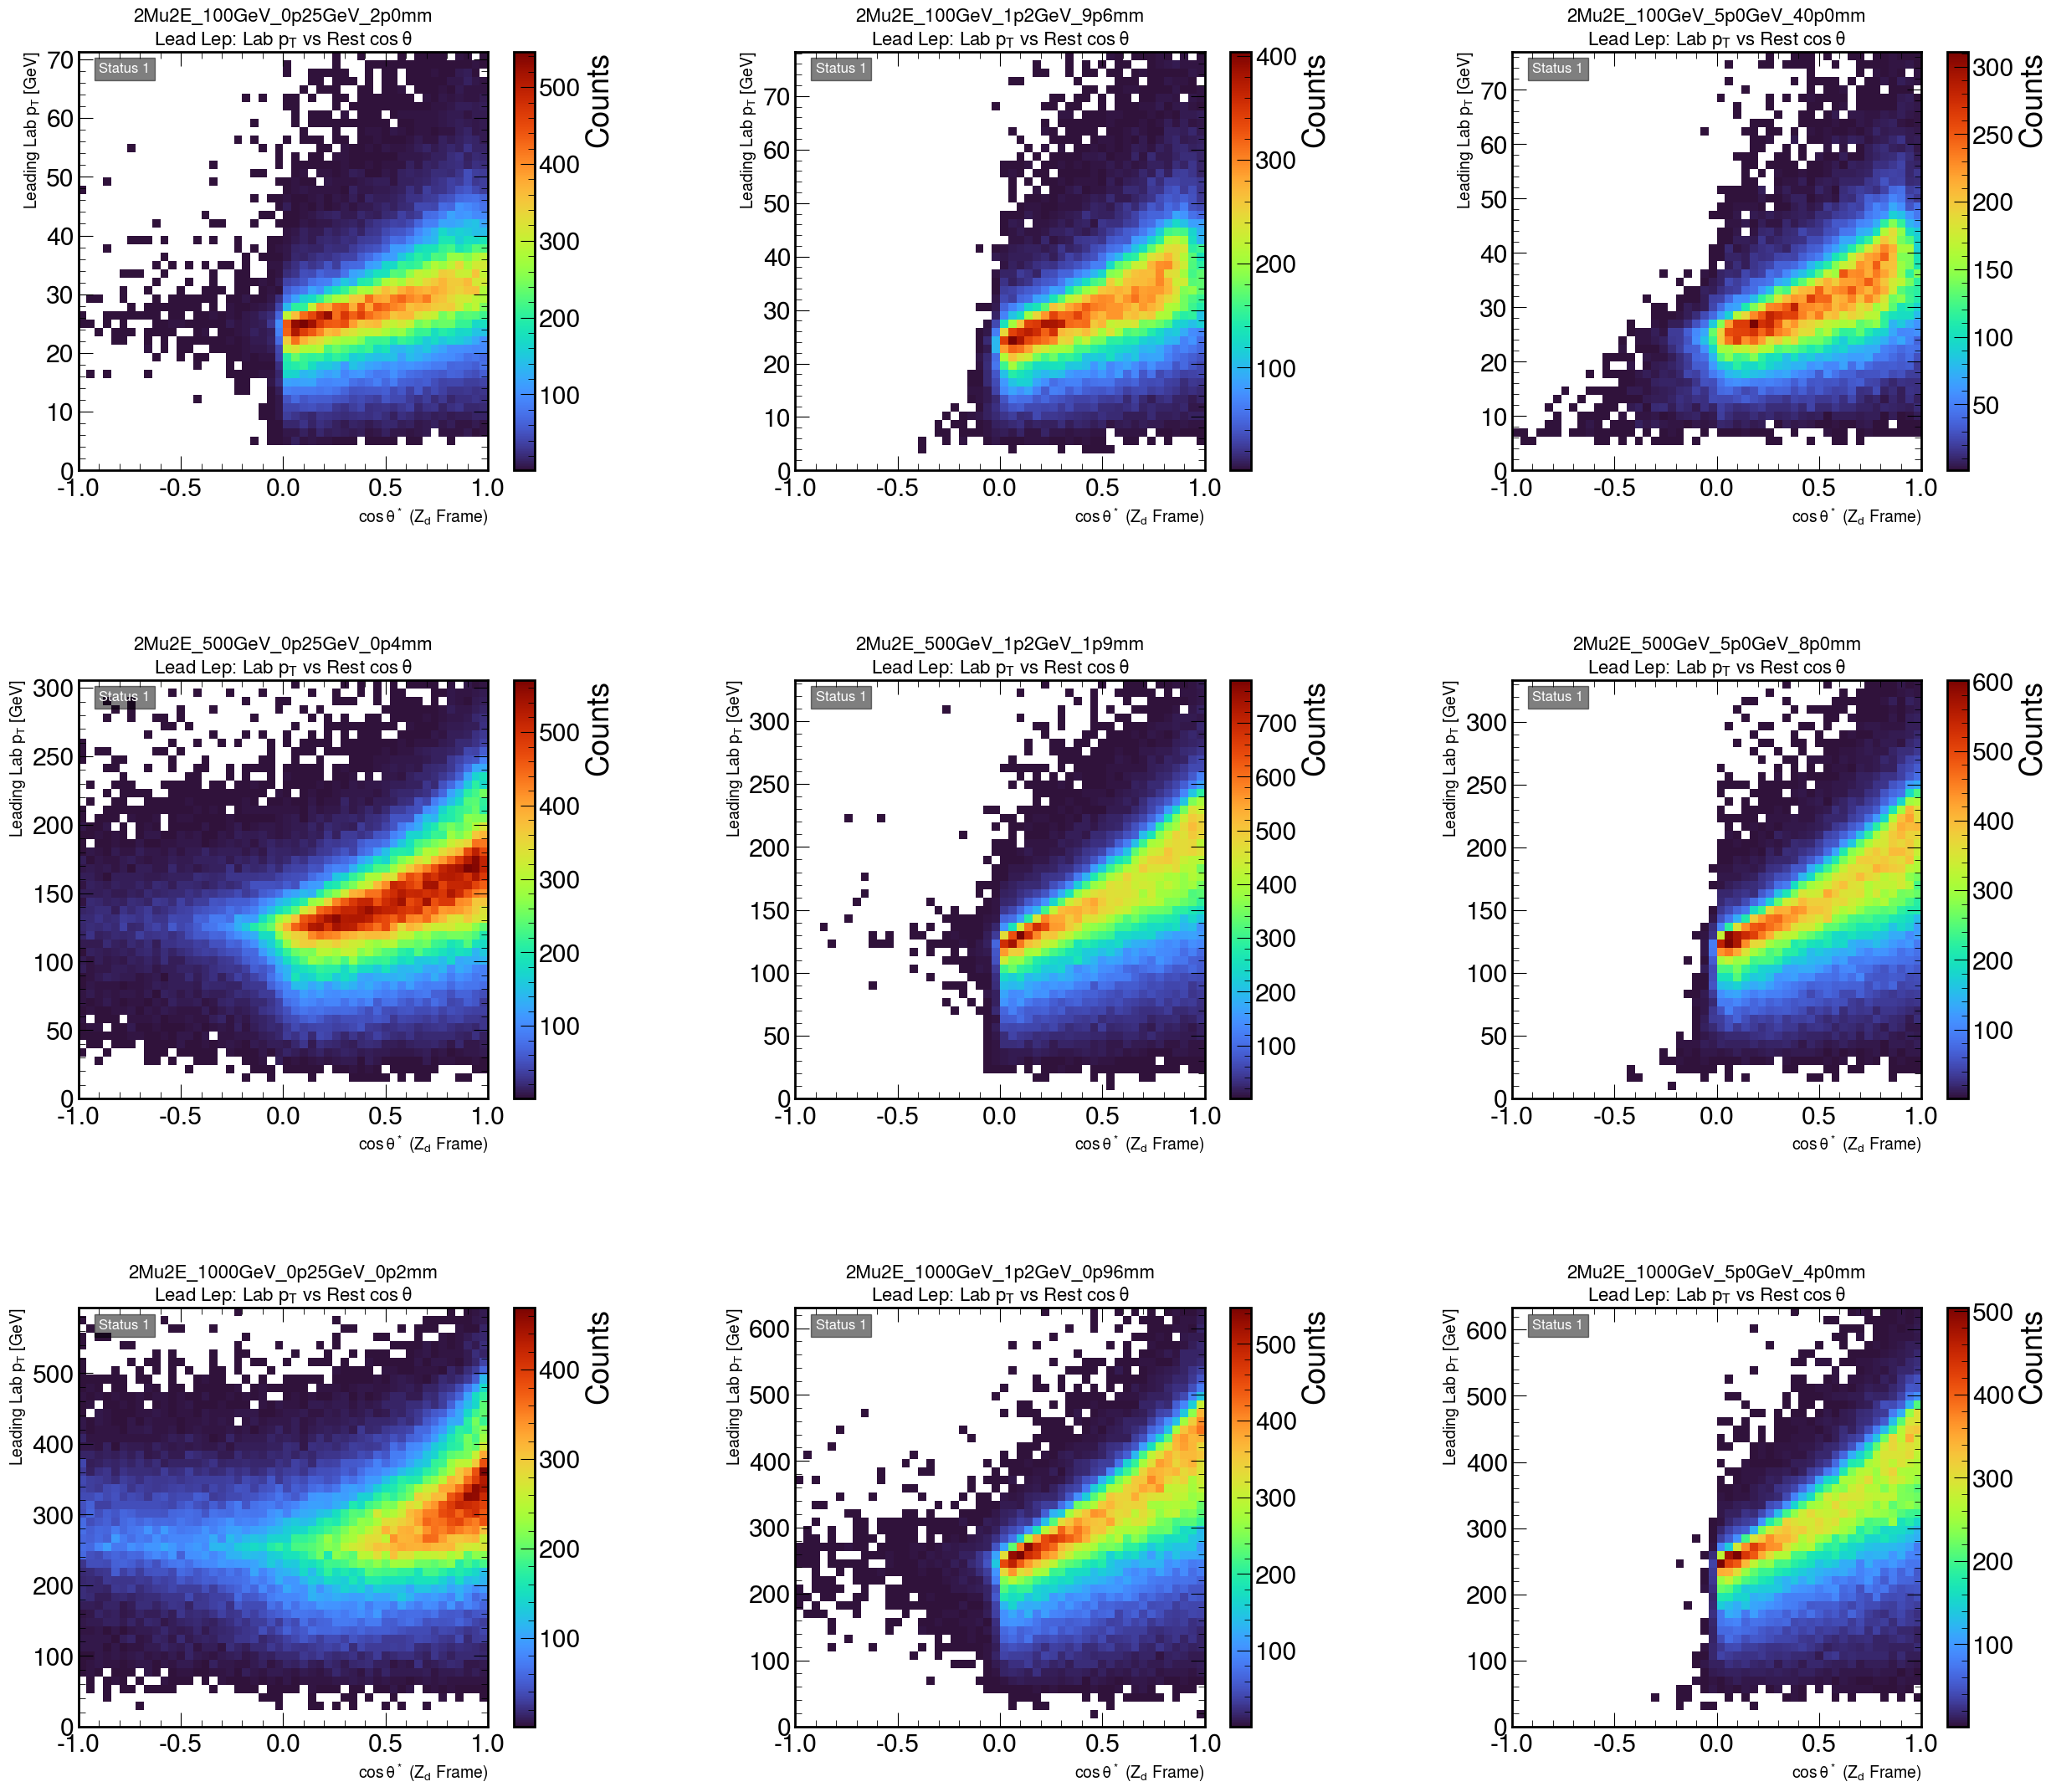

--- Generating Plot Type 29 ---


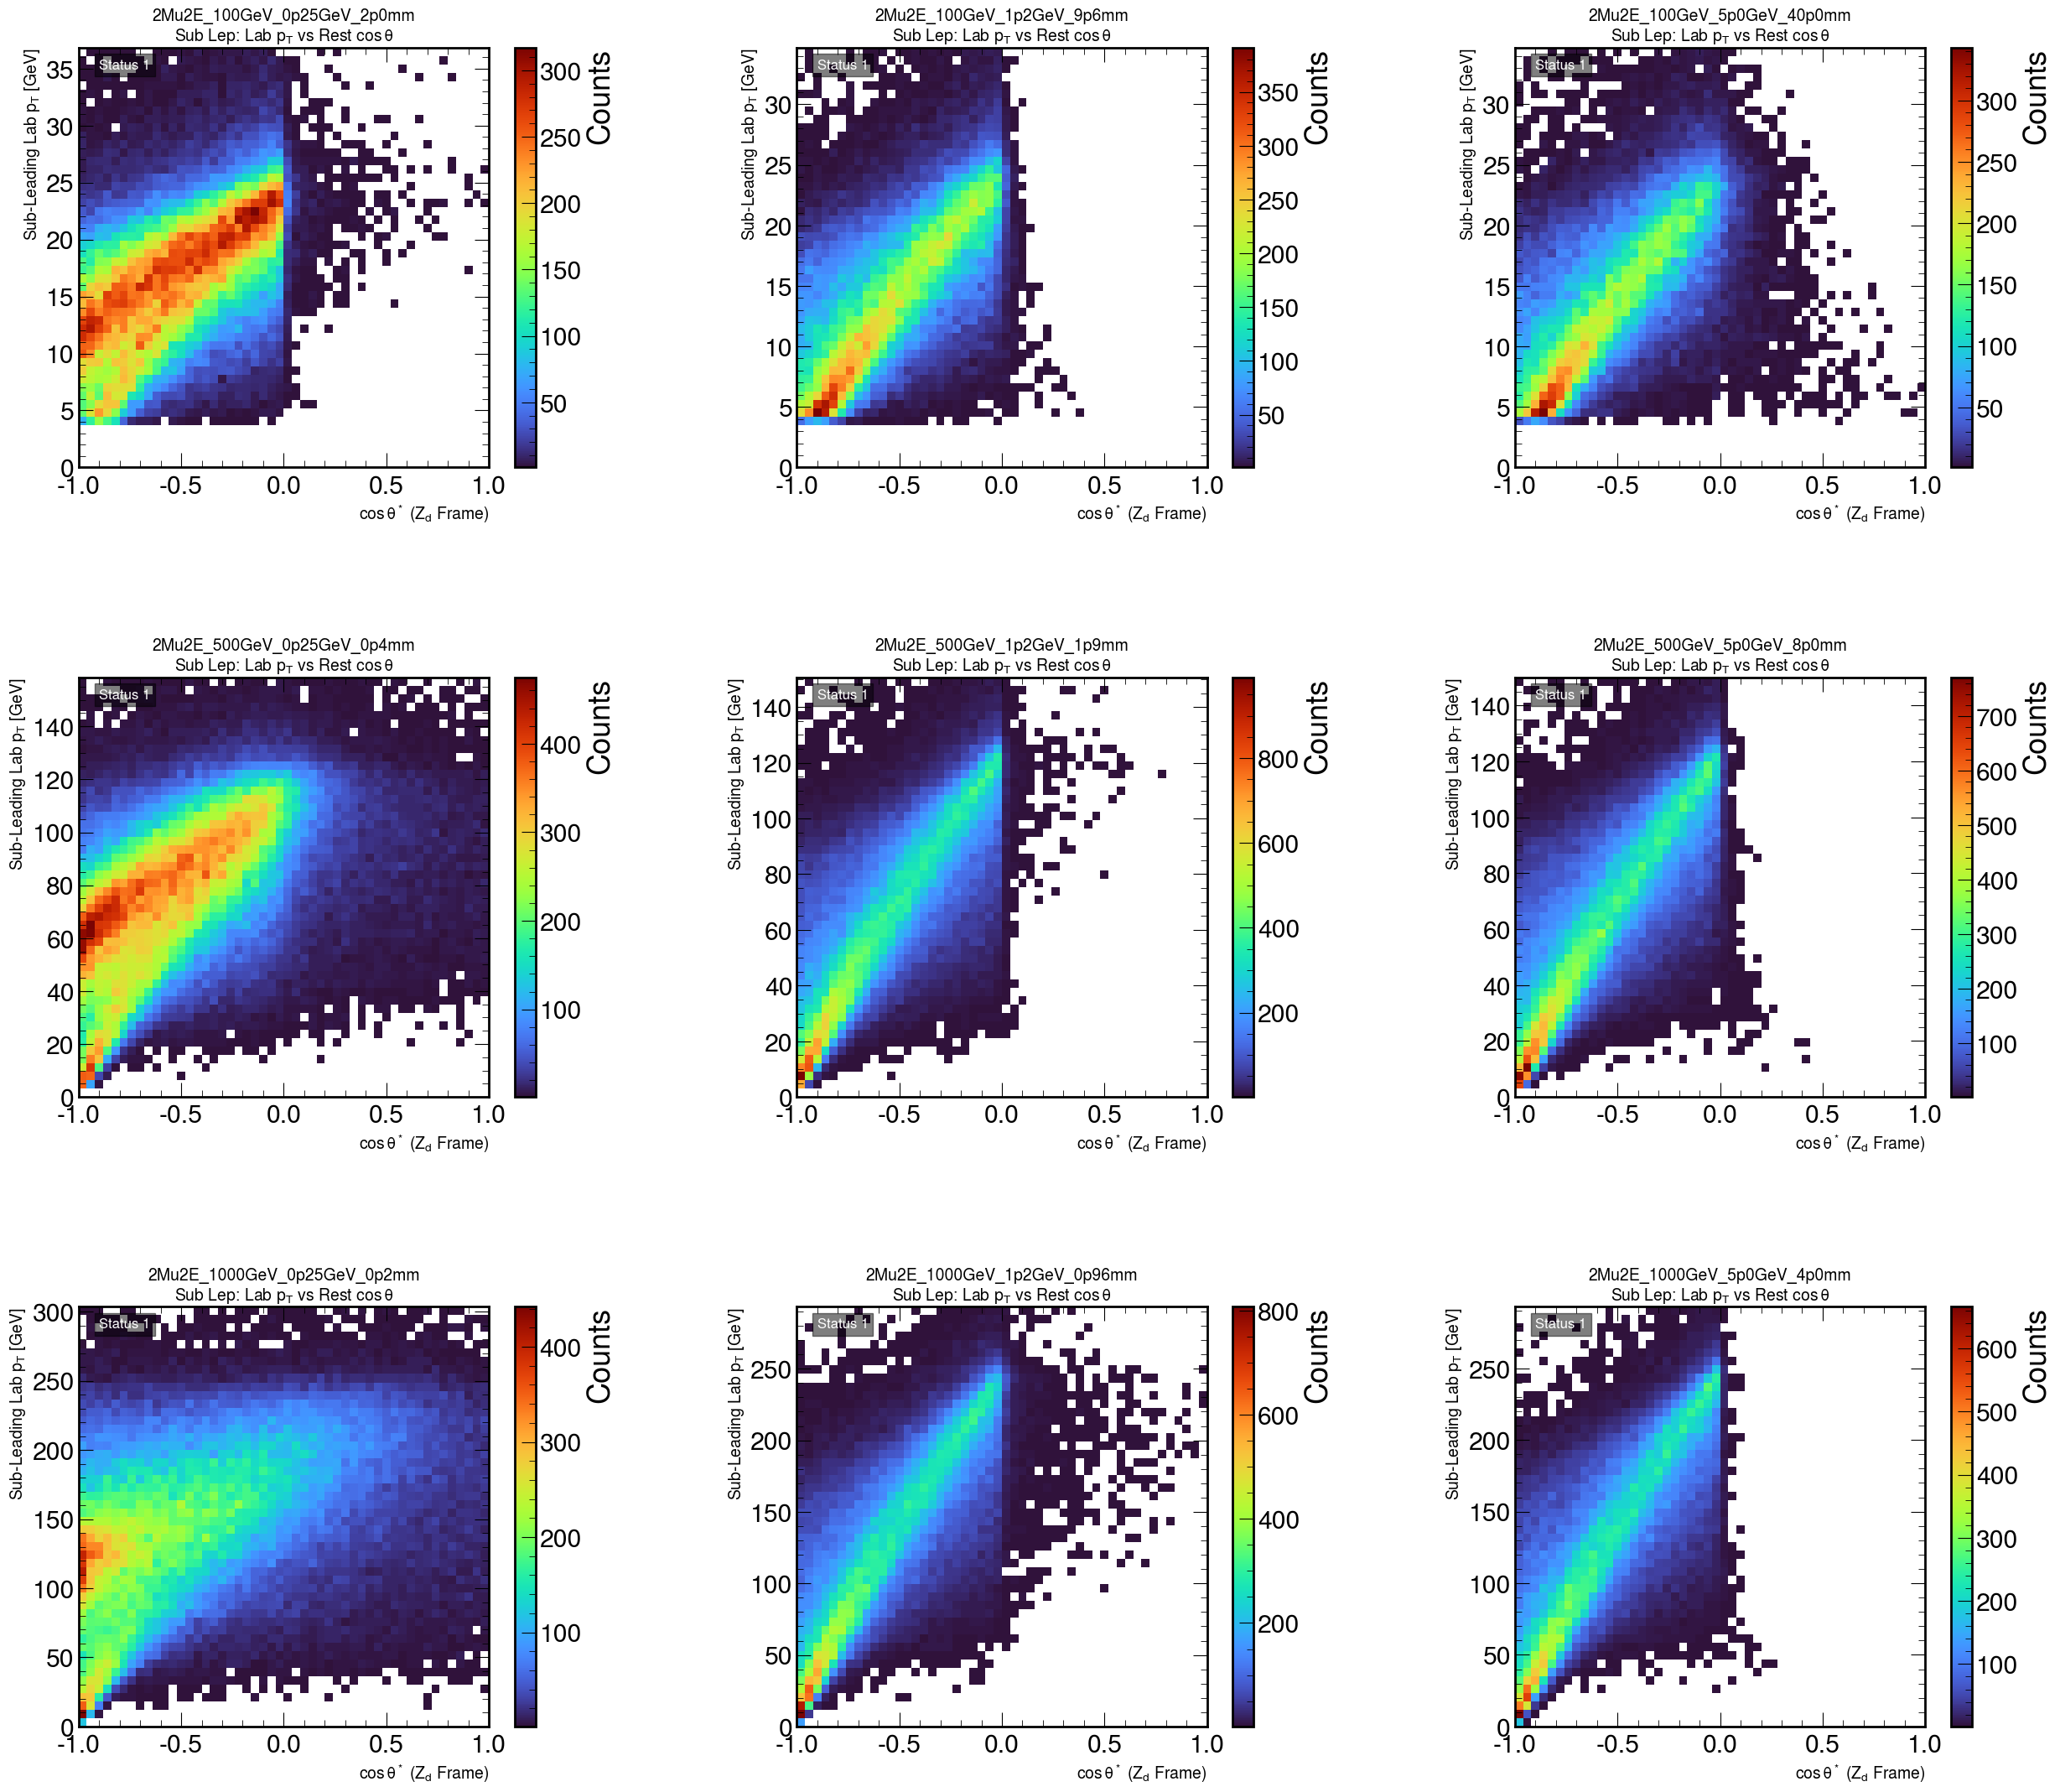

In [59]:
plot_master_grid(output, samples, plot_id=28)
plot_master_grid(output, samples, plot_id=29)

Plot above is looking at Status 1 leptons only. Technically the leading lepton might get a small hit from this, but thats hard to see. The subleading lepton is clear here as the upper band. This is most visible of course in the exterme case of the heaviest BS and lightest Zd

--- Generating Plot Type 30 ---


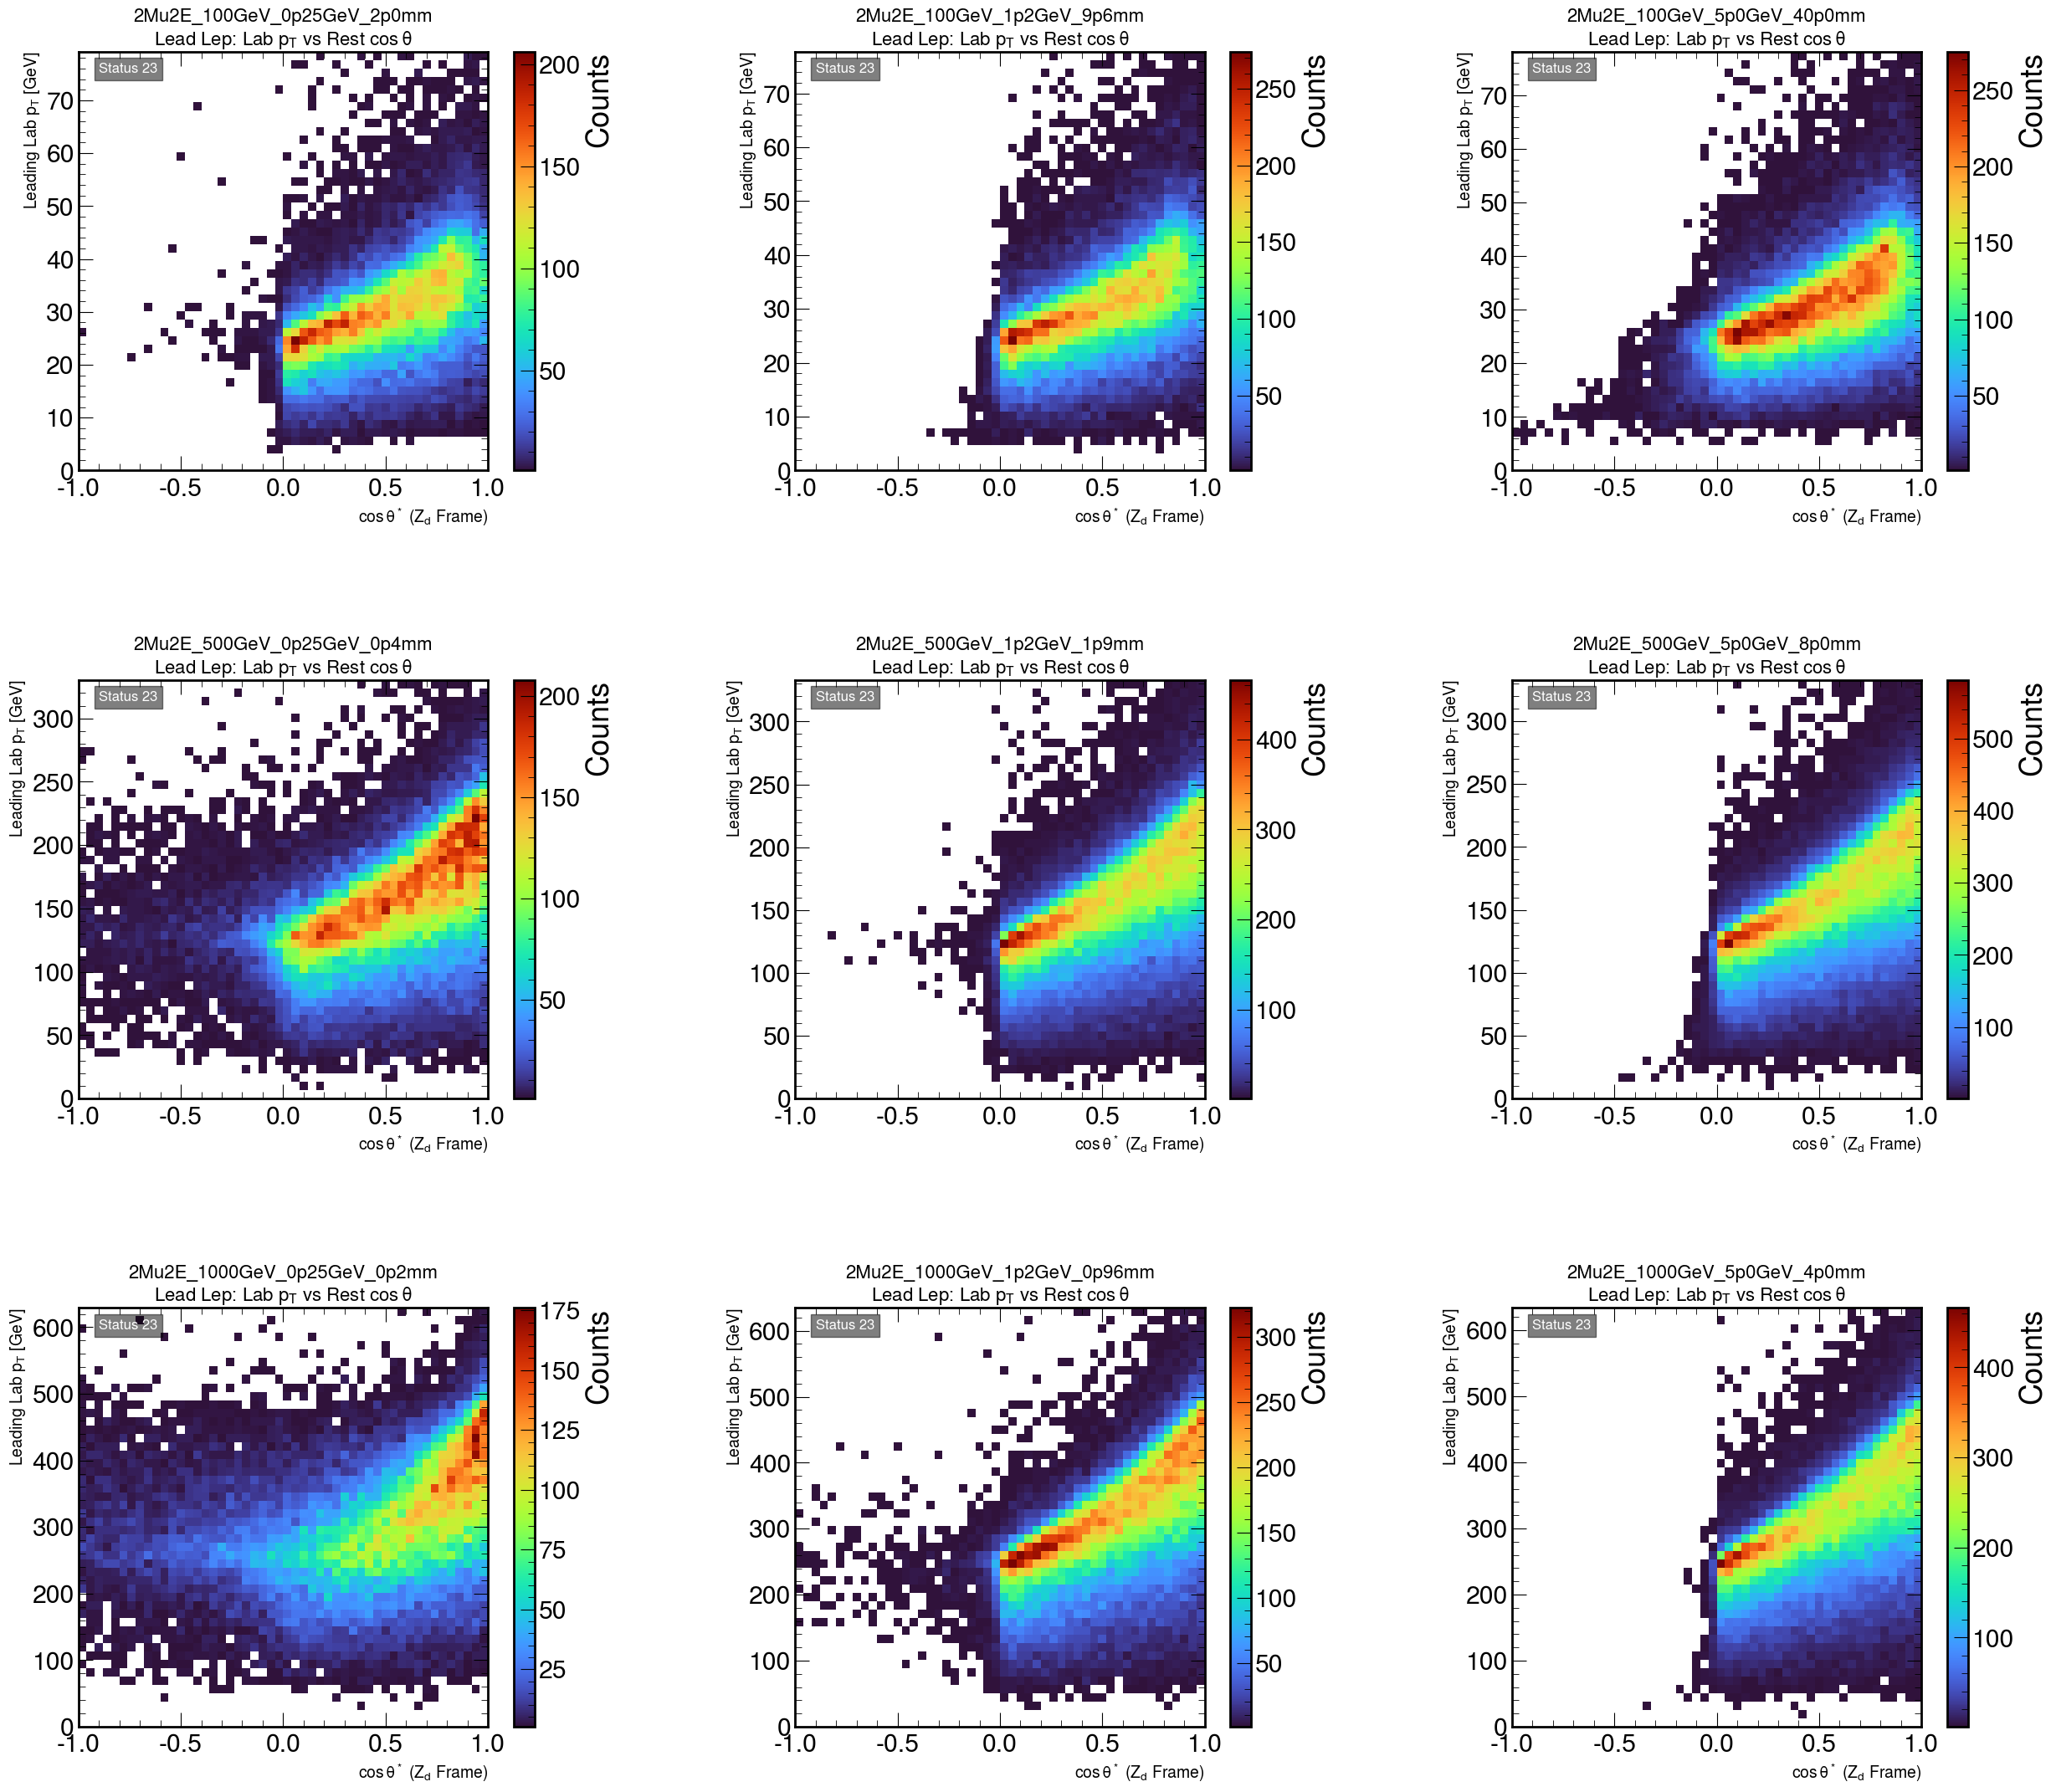

--- Generating Plot Type 31 ---


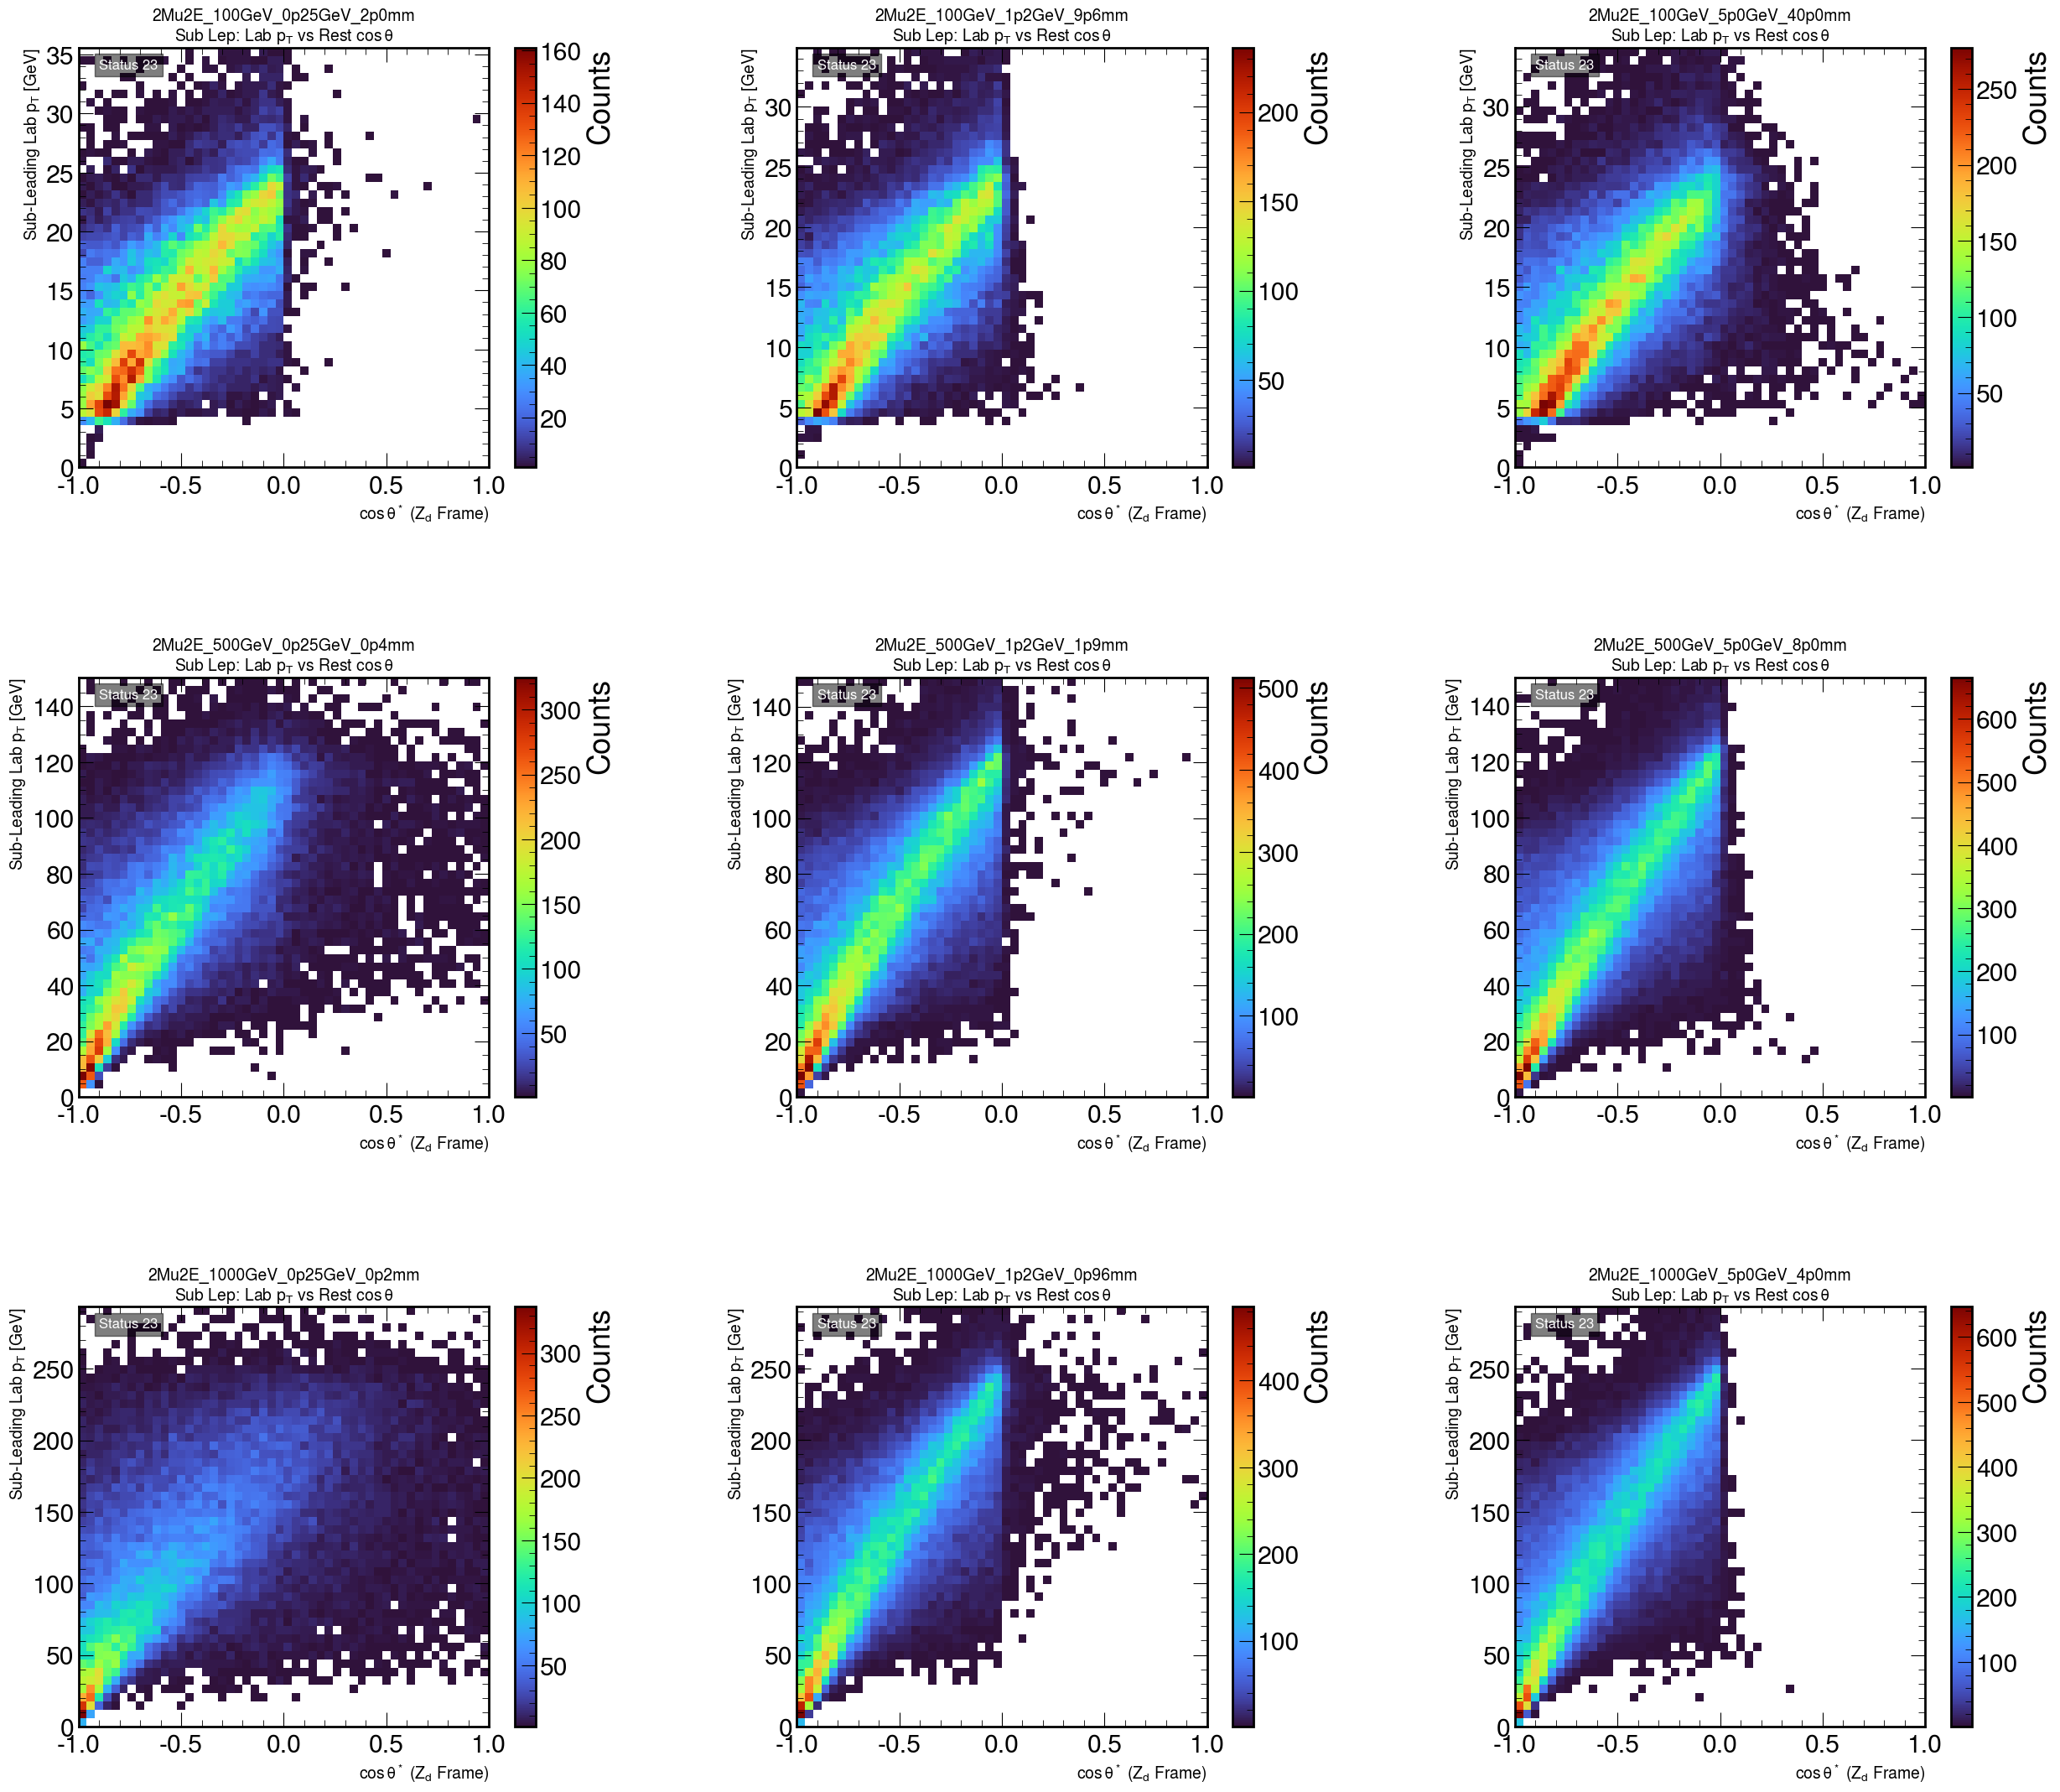

In [60]:
plot_master_grid(output, samples, plot_id=30)
plot_master_grid(output, samples, plot_id=31)

Plot above limits to just the Status 23 leptons. Here it's clear that we are seeing the expected trends, as the FSR doesn't spare the subleading lepton anymore

Sticking with these Status 23 leptons for now, let's study the angular distributions and test the idea that we are seeing the correct transverse polarization effects

--- Generating Plot Type 33 ---


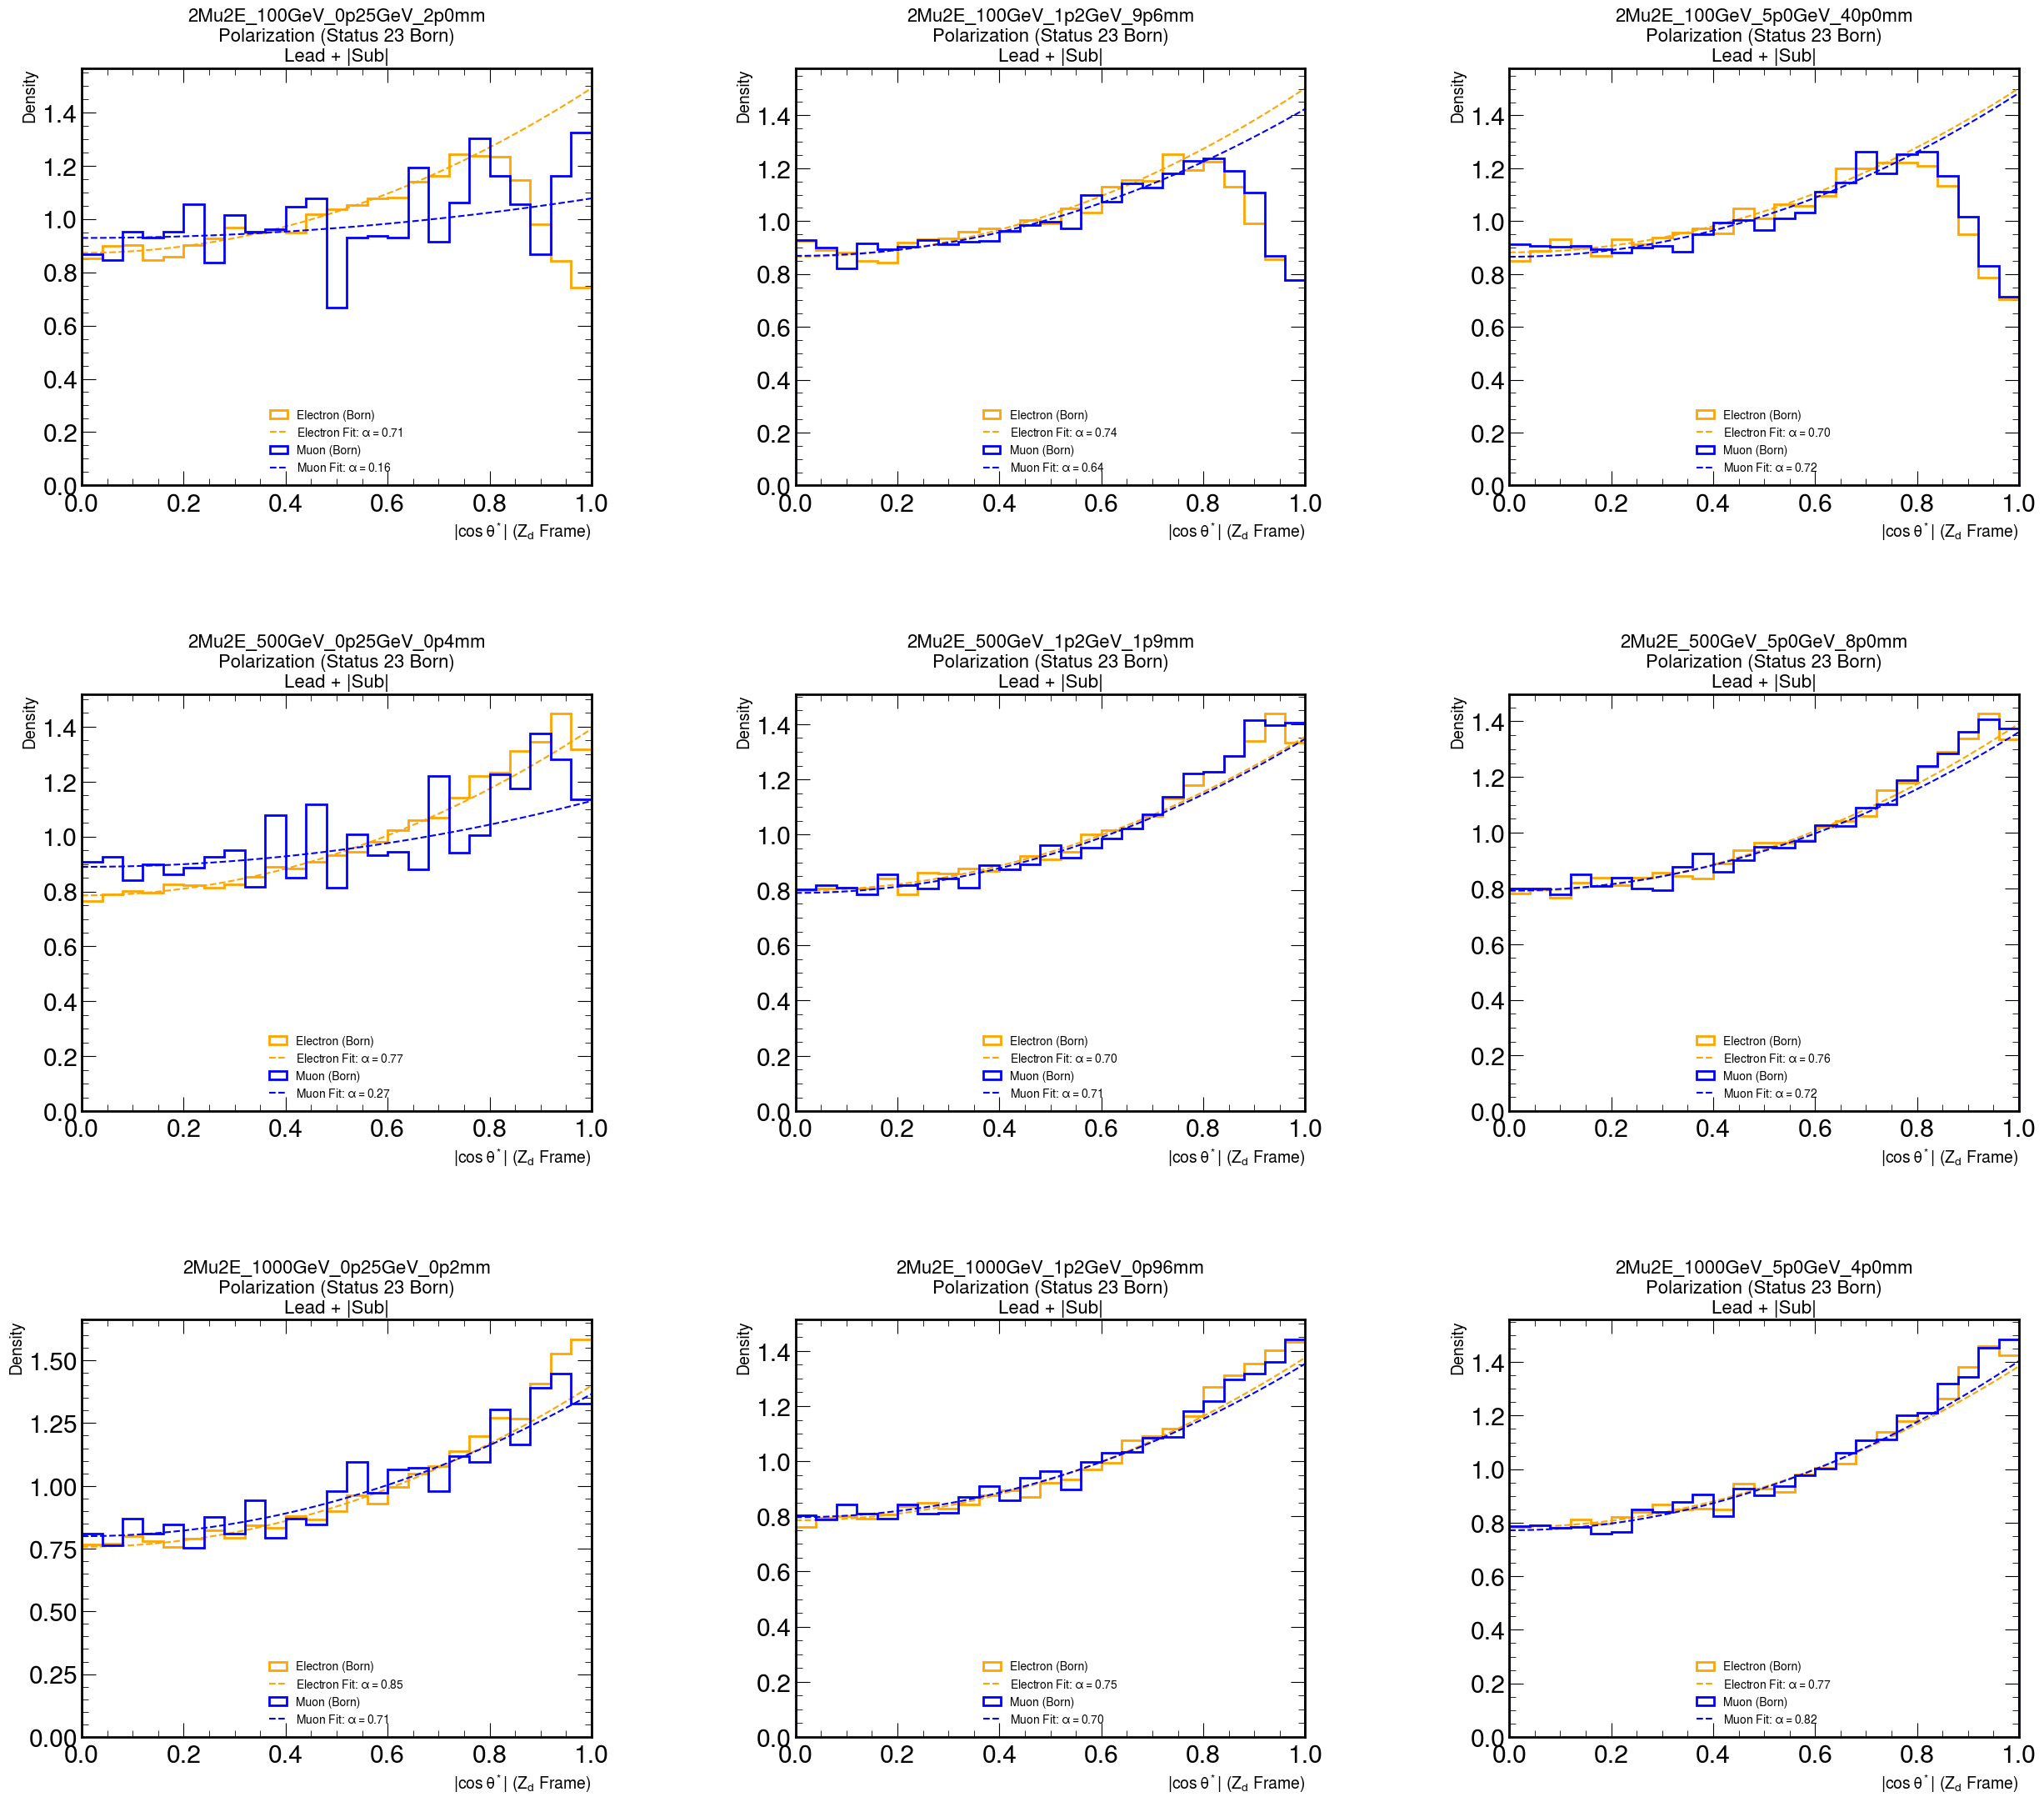

In [61]:
plot_master_grid(output, samples, plot_id=33)

And there we have it folks!

The polarization parameter α is driven by two ratios:

    MZd/MBoundState: As this ratio decreases (heavier Bound State), the Zd production becomes purely Transverse.

    mℓ/MZd: As this ratio increases (lighter Zd or heavier lepton), the decay angular distribution becomes isotropic due to velocity suppression.

The 0.25 GeV dimuon channel is kinematically forced to be nearly isotropic (α≈0.16) due to the muon mass threshold, Especially visisble at the 100 GeV bound state. But for the .25 GeV Zd, as the BS gets heavier (1000 GeV extreme case), the collimation in the lab frame gets extreme, and our ability to recover the correct angles starts to degrade when using the stored lab frame 4 vectors for the leptons and boosting using the Zd 4 vector. 

### Some other Lepton kinematics

--- Generating Plot Type 35 ---


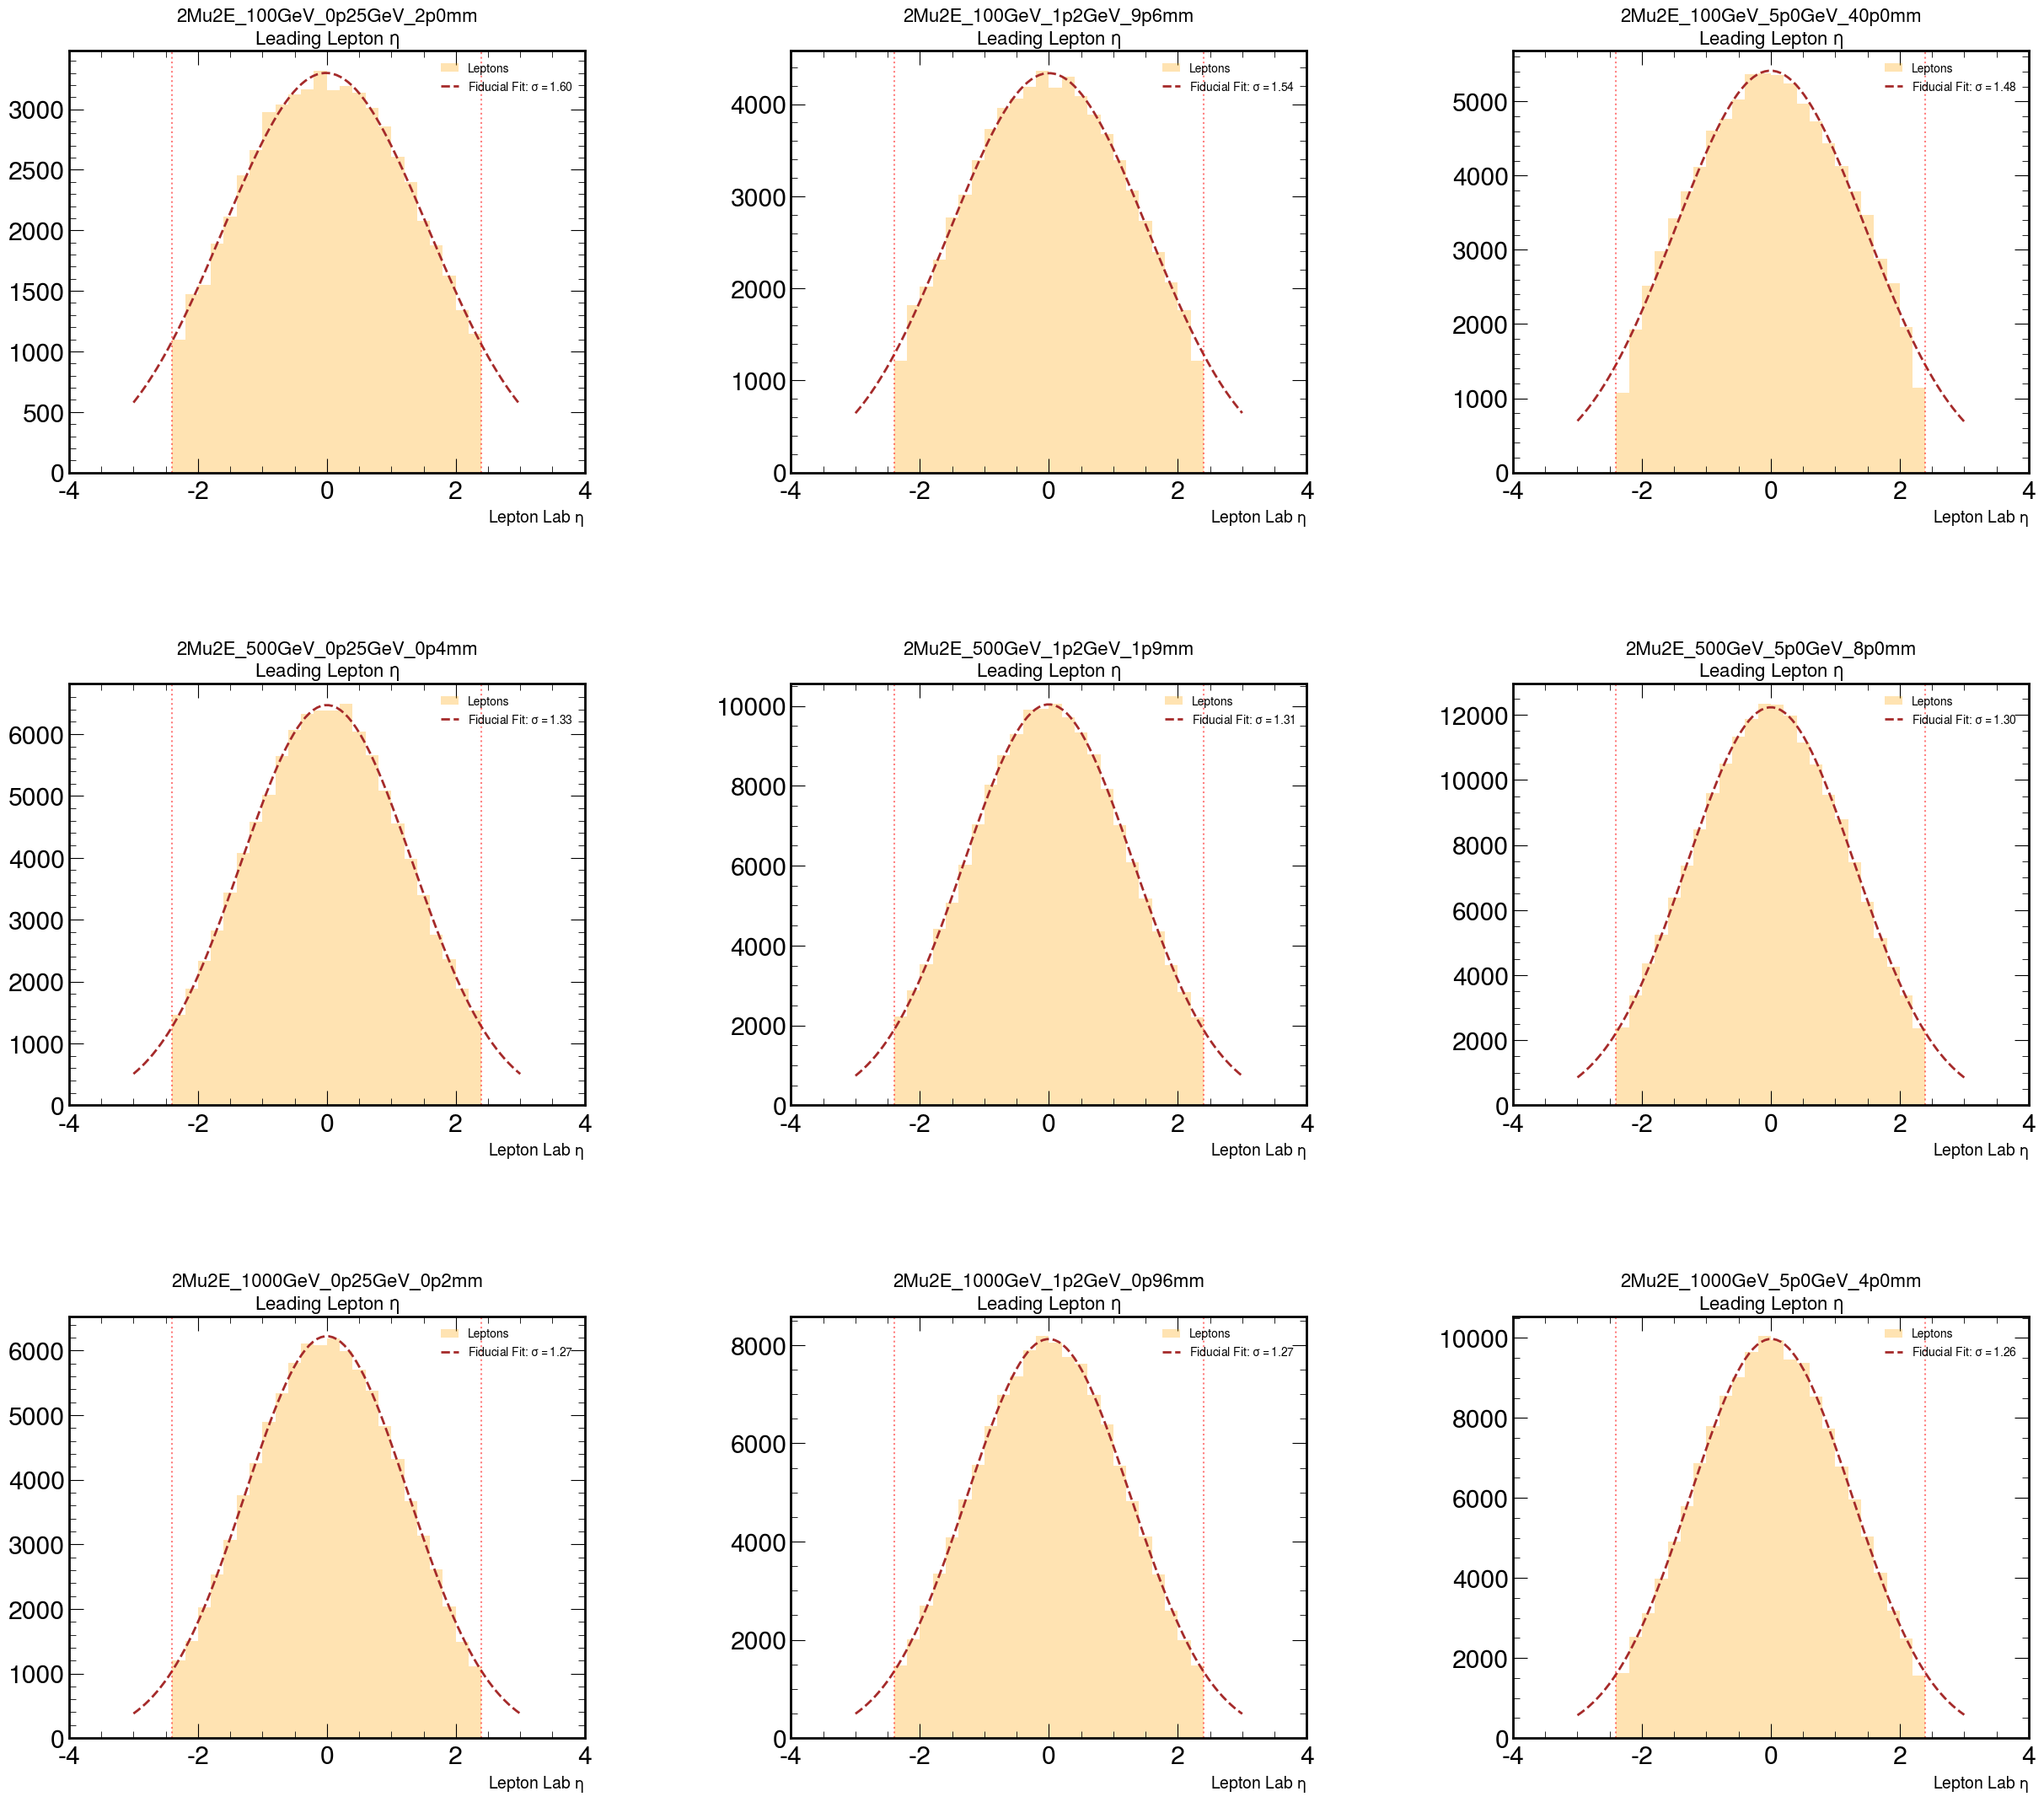

In [62]:
plot_master_grid(output, samples, plot_id=35)

The leptons pretty much look like the Zd in terms of their direction, here's the eta plot for the leading lepton

--- Generating Plot Type 36 ---


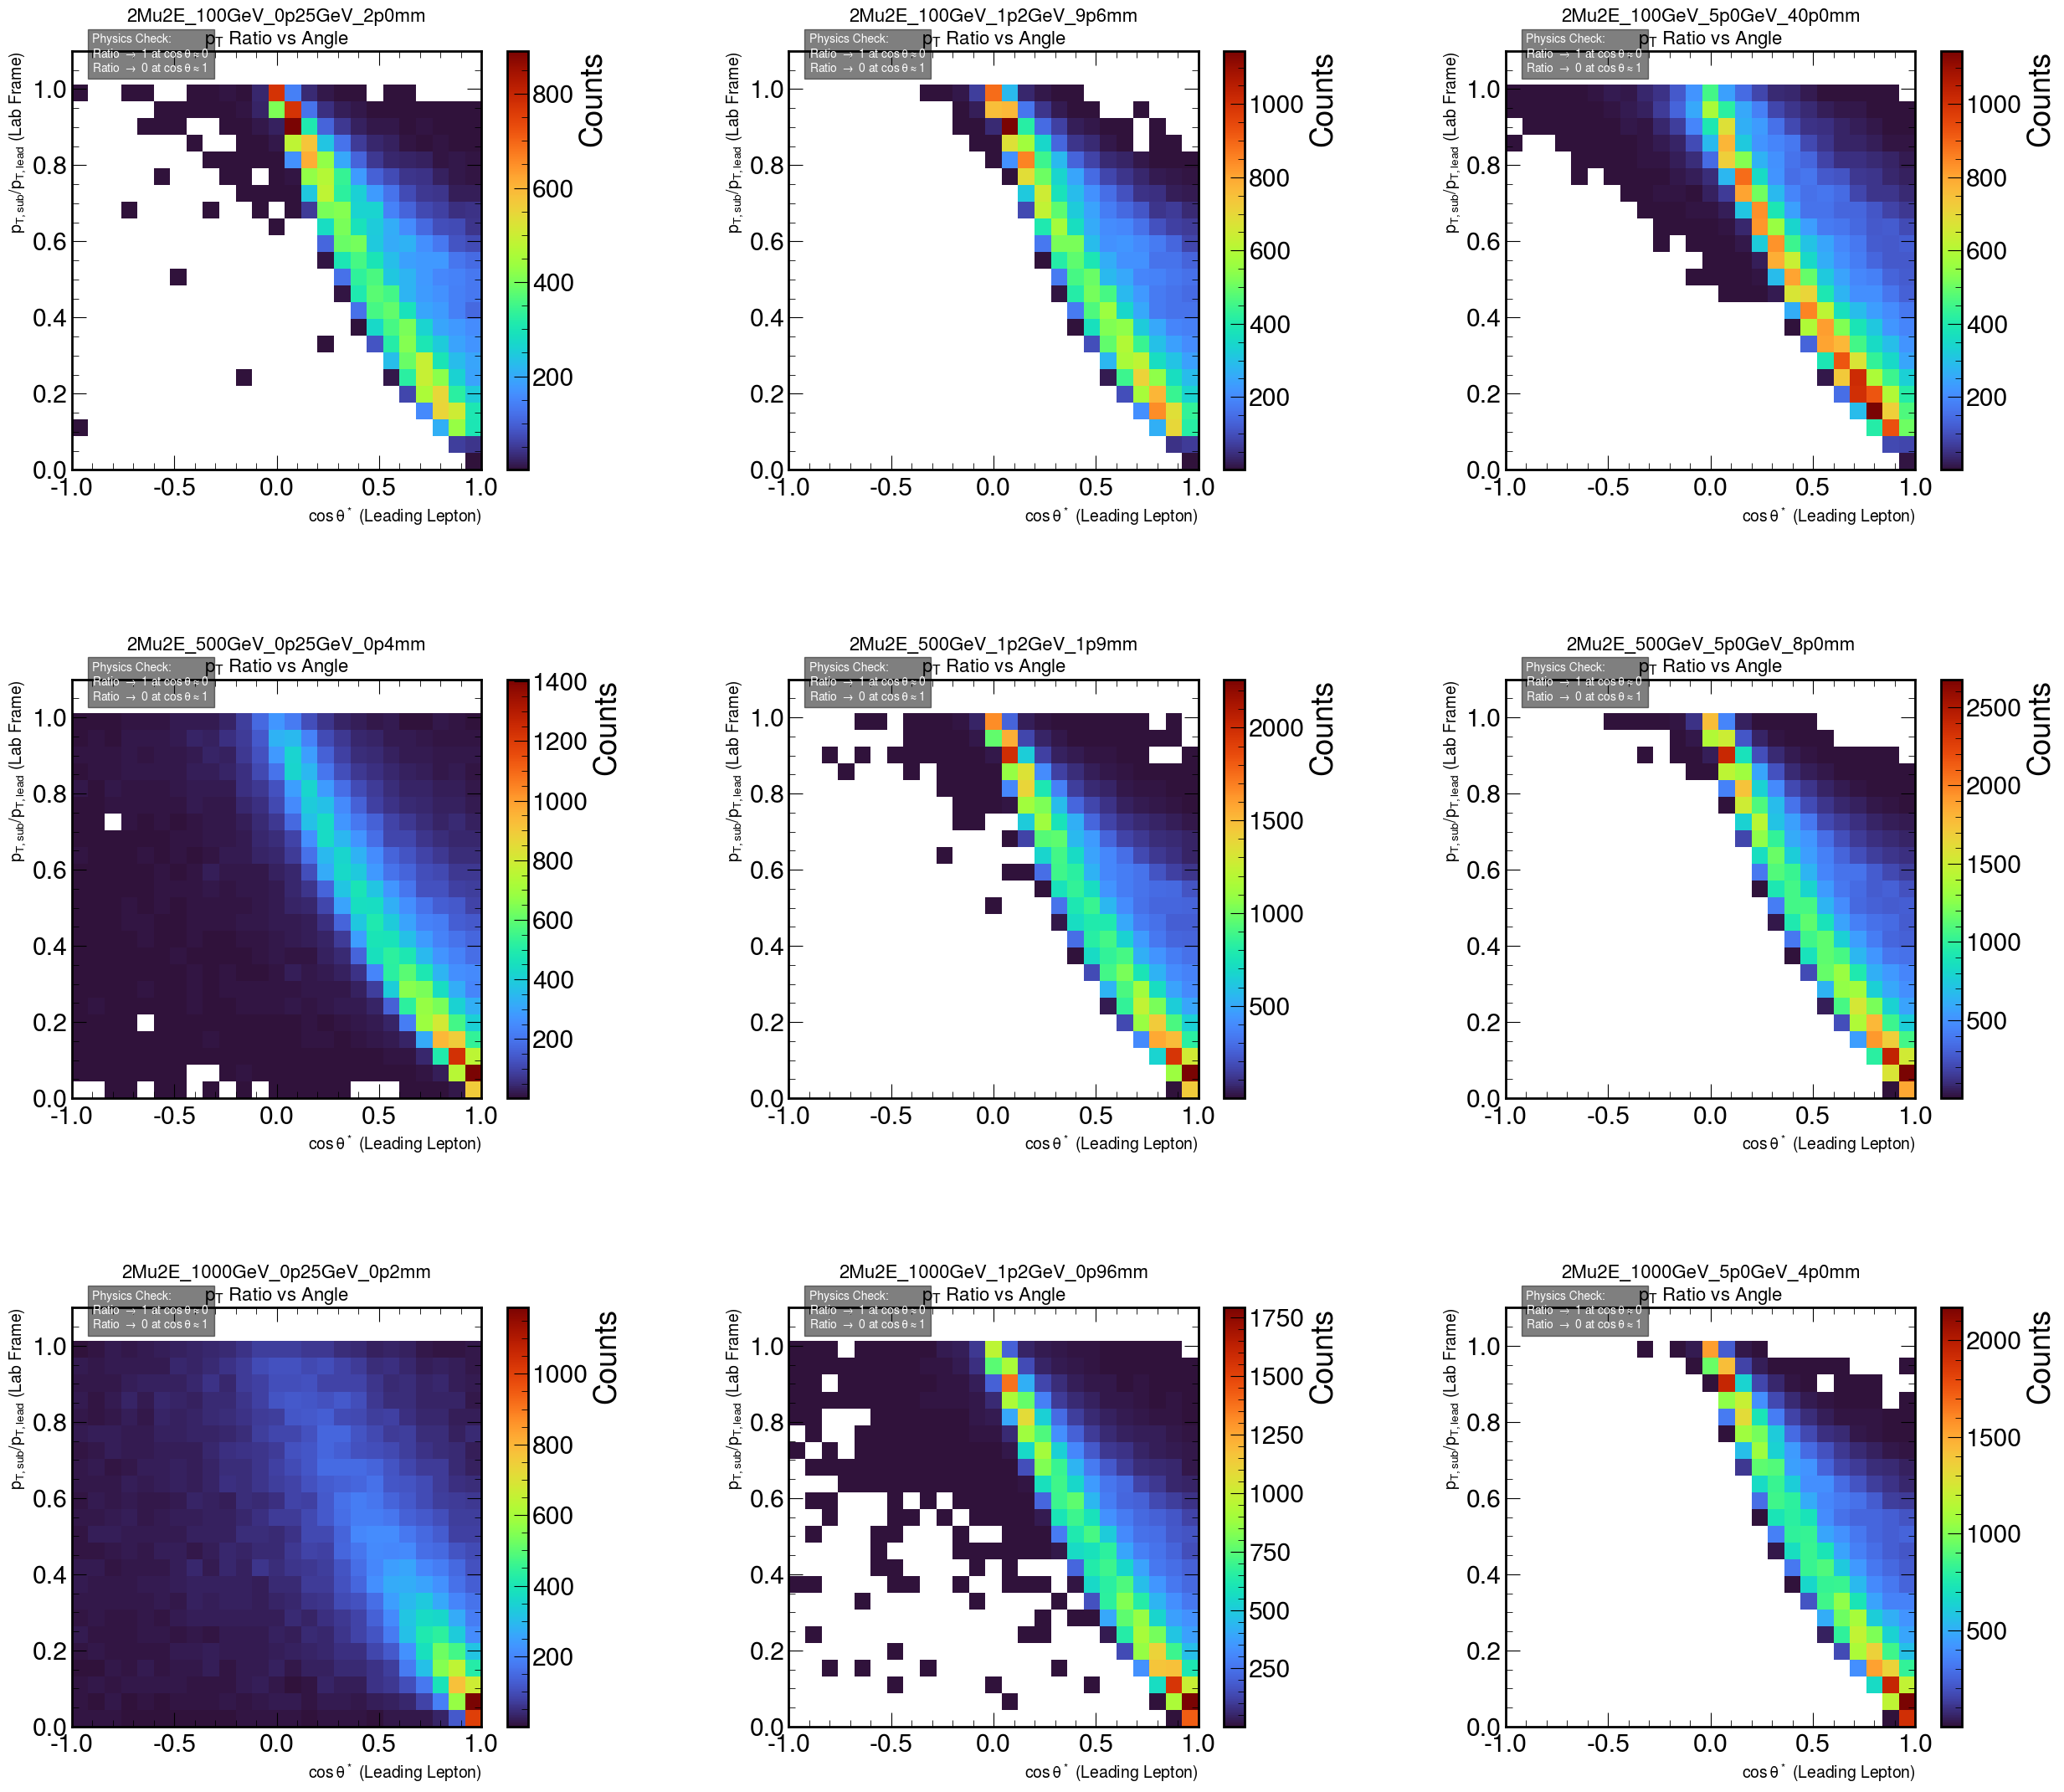

In [63]:
plot_master_grid(output, samples, plot_id=36)

A very expected trend of ratio of the sublead/lead lab frame lepton pT versus cos theta in the Zd rest frame